In [1]:
import sys
import os
module_path = os.path.abspath('/media/jary/DATA/Uni/tesi/codice')
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from networks import NoKafnet, Kafnet
import utils.datasetsUtils.MINST as MINST
from utils.datasetsUtils.taskManager import SingleTargetClassificationTask, NoTask
import configs.configClasses as configClasses
from torchvision.transforms import transforms
import torch
import networks.continual_learning as continual_learning
from Trainer import Trainer
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import numpy as np

In [3]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
GeForce GTX 1050


In [5]:
configOnline = configClasses.OnlineLearningConfig()
configOnline.L1_REG = 0
configOnline.EPOCHS = 20
configOnline.SAVE_PATH = './models/multikaf'
configOnline.IS_CONVOLUTIONAL = False
configOnline.MODEL_NAME = ''
print(configOnline)

CONFIG PARAMETERS
BATCH_SIZE: 64
DEVICE: cuda
EPOCHS: 20
EWC_IMPORTANCE: 1000
EWC_SAMPLE_SIZE: 250
EWC_TYPE: <class 'networks.continual_learning.OnlineEWC'>
GAMMA: 1.0
IS_CONVOLUTIONAL: False
ITERS: 1
L1_REG: 0
LOSS: cross_entropy
LR: 0.001
MODEL_NAME: 
OPTIMIZER: SGD
RUN_NAME: default
SAVE_PATH: ./models/multikaf
USE_EWC: True
USE_TENSORBOARD: True



In [6]:
dataset = MINST.PermutedMINST('../data/minst', download=True, n_permutation=4,
                        force_download=False, train_split=0.8, transform=None, target_transform=None)
dataset.load_dataset()

../data/minst/download
task #0 with train 56000 and test 14000 images (label: 0)
task #1 with train 56000 and test 14000 images (label: 1)
task #2 with train 56000 and test 14000 images (label: 2)
task #3 with train 56000 and test 14000 images (label: 3)


In [7]:
multikaf = Kafnet.MultiKAFMLP(len(dataset.class_to_idx), hidden_size=int(400*0.7),  kaf_init_fcn=None,
                             trainable_dict=False, kernel_combination='sum')

for n, p in multikaf.named_parameters():
    if p.requires_grad:
        print(n, p.size())

fc1.weight torch.Size([280, 784])
fc1.bias torch.Size([280])
fc2.weight torch.Size([280, 280])
fc2.bias torch.Size([280])
fc3.weight torch.Size([280, 280])
fc3.bias torch.Size([280])
fc4.weight torch.Size([10, 280])
fc4.bias torch.Size([10])
kaf1.mu torch.Size([1, 280, 3])
kaf1.alpha torch.Size([1, 280, 20])
kaf2.mu torch.Size([1, 280, 3])
kaf2.alpha torch.Size([1, 280, 20])
kaf3.mu torch.Size([1, 280, 3])
kaf3.alpha torch.Size([1, 280, 20])


In [8]:
experiments_multikaf = [('multikaf_no_cont_learning', None), 
               ('multikaf_ewc', continual_learning.OnlineEWC), 
               ('multikaf_gem', continual_learning.GEM)]
results = []

In [9]:
for name, tec in experiments_multikaf:
    print(name)
    
    n = deepcopy(multikaf)
    config = deepcopy(configOnline)
    
    config.MODEL_NAME = name

    if 'name' == 'gem':
        config.EWC_IMPORTANCE = 0.5
        
    config.EWC_TYPE = tec
    
    trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

    r = trainer.load()
    if not r:
        r = trainer.all_tasks()
    
    results.append((name, r))
    
    del trainer
    del n

multikaf_no_cont_learning


/media/jary/DATA/Uni/tesi/codice/Trainer.py:37: UserWarning: Ewc type is set to None  
  warnings.warn("Ewc type is set to None  ")
Training task 0, epoch 1: 100%|██████████| 875/875 [00:24<00:00, 50.86it/s, loss=1.07, batch#=875]
Testing task 0: 219it [00:03, 70.35it/s, batch#=219]
Training task 0, epoch 2: 100%|██████████| 875/875 [00:17<00:00, 50.72it/s, loss=0.421, batch#=875]
Testing task 0: 219it [00:03, 71.98it/s, batch#=219]
Training task 0, epoch 3: 100%|██████████| 875/875 [00:17<00:00, 51.18it/s, loss=0.333, batch#=875]
Testing task 0: 219it [00:03, 72.15it/s, batch#=219]
Training task 0, epoch 4: 100%|██████████| 875/875 [00:17<00:00, 51.02it/s, loss=0.279, batch#=875]
Testing task 0: 219it [00:03, 71.98it/s, batch#=219]
Training task 0, epoch 5: 100%|██████████| 875/875 [00:17<00:00, 51.04it/s, loss=0.248, batch#=875]
Testing task 0: 219it [00:03, 71.58it/s, batch#=219]
Training task 0, epoch 6: 100%|██████████| 875/875 [00:17<00:00, 51.52it/s, loss=0.221, batch#=875]
Test

Training task 2, epoch 3: 100%|██████████| 875/875 [00:17<00:00, 51.43it/s, loss=0.203, batch#=875]
Testing task 2: 219it [00:03, 72.38it/s, batch#=219]
Testing task 0: 219it [00:03, 72.41it/s, batch#=219]
Testing task 1: 219it [00:03, 72.60it/s, batch#=219]
Training task 2, epoch 4: 100%|██████████| 875/875 [00:17<00:00, 51.06it/s, loss=0.173, batch#=875]
Testing task 2: 219it [00:03, 72.46it/s, batch#=219]
Testing task 0: 219it [00:03, 72.59it/s, batch#=219]
Testing task 1: 219it [00:03, 72.57it/s, batch#=219]
Training task 2, epoch 5: 100%|██████████| 875/875 [00:17<00:00, 51.34it/s, loss=0.152, batch#=875]
Testing task 2: 219it [00:03, 72.67it/s, batch#=219]
Testing task 0: 219it [00:03, 72.69it/s, batch#=219]
Testing task 1: 219it [00:03, 72.71it/s, batch#=219]
Training task 2, epoch 6: 100%|██████████| 875/875 [00:17<00:00, 51.37it/s, loss=0.136, batch#=875]
Testing task 2: 219it [00:03, 72.13it/s, batch#=219]
Testing task 0: 219it [00:03, 72.36it/s, batch#=219]
Testing task 1: 2

Training task 3, epoch 12: 100%|██████████| 875/875 [00:17<00:00, 51.11it/s, loss=0.0792, batch#=875]
Testing task 3: 219it [00:03, 72.04it/s, batch#=219]
Testing task 0: 219it [00:03, 72.22it/s, batch#=219]
Testing task 1: 219it [00:03, 72.54it/s, batch#=219]
Testing task 2: 219it [00:03, 72.34it/s, batch#=219]
Training task 3, epoch 13: 100%|██████████| 875/875 [00:17<00:00, 51.43it/s, loss=0.0755, batch#=875]
Testing task 3: 219it [00:03, 72.57it/s, batch#=219]
Testing task 0: 219it [00:03, 72.66it/s, batch#=219]
Testing task 1: 219it [00:03, 72.65it/s, batch#=219]
Testing task 2: 219it [00:03, 72.16it/s, batch#=219]
Training task 3, epoch 14: 100%|██████████| 875/875 [00:17<00:00, 51.52it/s, loss=0.0712, batch#=875]
Testing task 3: 219it [00:03, 72.78it/s, batch#=219]
Testing task 0: 219it [00:03, 72.67it/s, batch#=219]
Testing task 1: 219it [00:03, 72.41it/s, batch#=219]
Testing task 2: 219it [00:03, 72.59it/s, batch#=219]
Training task 3, epoch 15: 100%|██████████| 875/875 [00:17

multikaf_ewc


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:17<00:00, 50.90it/s, loss=1.08, batch#=875]
Testing task 0: 219it [00:03, 72.36it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:17<00:00, 51.06it/s, loss=0.422, batch#=875]
Testing task 0: 219it [00:03, 71.85it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:17<00:00, 51.15it/s, loss=0.331, batch#=875]
Testing task 0: 219it [00:03, 72.11it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:17<00:00, 50.94it/s, loss=0.282, batch#=875]
Testing task 0: 219it [00:03, 72.29it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:17<00:00, 50.91it/s, loss=0.247, batch#=875]
Testing task 0: 219it [00:03, 71.93it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:17<00:00, 50.45it/s, loss=0.222, batch#=875]
Testing task 0: 219it [00:03, 71.89it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|██████████

Testing task 1: 219it [00:03, 71.08it/s, batch#=219]
Training task (ewc) 2, epoch 3: 100%|██████████| 875/875 [00:23<00:00, 37.25it/s, loss=2.16, batch#=875]
Testing task 2: 219it [00:03, 72.18it/s, batch#=219]
Testing task 0: 219it [00:03, 72.15it/s, batch#=219]
Testing task 1: 219it [00:03, 71.99it/s, batch#=219]
Training task (ewc) 2, epoch 4: 100%|██████████| 875/875 [00:23<00:00, 37.25it/s, loss=2.06, batch#=875]
Testing task 2: 219it [00:03, 71.61it/s, batch#=219]
Testing task 0: 219it [00:03, 71.60it/s, batch#=219]
Testing task 1: 219it [00:03, 72.10it/s, batch#=219]
Training task (ewc) 2, epoch 5: 100%|██████████| 875/875 [00:23<00:00, 37.31it/s, loss=2, batch#=875]   
Testing task 2: 219it [00:03, 71.66it/s, batch#=219]
Testing task 0: 219it [00:03, 71.69it/s, batch#=219]
Testing task 1: 219it [00:03, 72.04it/s, batch#=219]
Training task (ewc) 2, epoch 6: 100%|██████████| 875/875 [00:23<00:00, 37.27it/s, loss=1.96, batch#=875]
Testing task 2: 219it [00:03, 71.90it/s, batch#=21

Testing task 3: 219it [00:03, 72.06it/s, batch#=219]
Testing task 0: 219it [00:03, 72.03it/s, batch#=219]
Testing task 1: 219it [00:03, 71.88it/s, batch#=219]
Testing task 2: 219it [00:03, 71.87it/s, batch#=219]
Training task (ewc) 3, epoch 12: 100%|██████████| 875/875 [00:23<00:00, 37.26it/s, loss=3.2, batch#=875] 
Testing task 3: 219it [00:03, 72.32it/s, batch#=219]
Testing task 0: 219it [00:03, 72.24it/s, batch#=219]
Testing task 1: 219it [00:03, 72.31it/s, batch#=219]
Testing task 2: 219it [00:03, 72.11it/s, batch#=219]
Training task (ewc) 3, epoch 13: 100%|██████████| 875/875 [00:23<00:00, 37.27it/s, loss=3.18, batch#=875]
Testing task 3: 219it [00:03, 72.00it/s, batch#=219]
Testing task 0: 219it [00:03, 72.06it/s, batch#=219]
Testing task 1: 219it [00:03, 71.88it/s, batch#=219]
Testing task 2: 219it [00:03, 71.96it/s, batch#=219]
Training task (ewc) 3, epoch 14: 100%|██████████| 875/875 [00:23<00:00, 37.27it/s, loss=3.16, batch#=875]
Testing task 3: 219it [00:03, 71.80it/s, batch

multikaf_gem


Training task (ewc) 0, epoch 1: 100%|██████████| 875/875 [00:17<00:00, 51.16it/s, loss=1.08, batch#=875]
Testing task 0: 219it [00:03, 72.07it/s, batch#=219]
Training task (ewc) 0, epoch 2: 100%|██████████| 875/875 [00:17<00:00, 51.21it/s, loss=0.423, batch#=875]
Testing task 0: 219it [00:03, 72.26it/s, batch#=219]
Training task (ewc) 0, epoch 3: 100%|██████████| 875/875 [00:17<00:00, 51.07it/s, loss=0.334, batch#=875]
Testing task 0: 219it [00:03, 72.06it/s, batch#=219]
Training task (ewc) 0, epoch 4: 100%|██████████| 875/875 [00:17<00:00, 50.70it/s, loss=0.281, batch#=875]
Testing task 0: 219it [00:03, 71.66it/s, batch#=219]
Training task (ewc) 0, epoch 5: 100%|██████████| 875/875 [00:17<00:00, 51.13it/s, loss=0.248, batch#=875]
Testing task 0: 219it [00:03, 71.77it/s, batch#=219]
Training task (ewc) 0, epoch 6: 100%|██████████| 875/875 [00:17<00:00, 50.73it/s, loss=0.222, batch#=875]
Testing task 0: 219it [00:03, 72.25it/s, batch#=219]
Training task (ewc) 0, epoch 7: 100%|██████████

Testing task 1: 219it [00:03, 71.86it/s, batch#=219]
Training task (ewc) 2, epoch 3: 100%|██████████| 875/875 [00:38<00:00, 22.72it/s, loss=0.511, batch#=875]
Testing task 2: 219it [00:03, 71.92it/s, batch#=219]
Testing task 0: 219it [00:03, 71.99it/s, batch#=219]
Testing task 1: 219it [00:03, 71.77it/s, batch#=219]
Training task (ewc) 2, epoch 4: 100%|██████████| 875/875 [00:38<00:00, 22.89it/s, loss=0.435, batch#=875]
Testing task 2: 219it [00:03, 71.61it/s, batch#=219]
Testing task 0: 219it [00:03, 71.48it/s, batch#=219]
Testing task 1: 219it [00:03, 71.94it/s, batch#=219]
Training task (ewc) 2, epoch 5: 100%|██████████| 875/875 [00:37<00:00, 23.15it/s, loss=0.399, batch#=875]
Testing task 2: 219it [00:03, 71.39it/s, batch#=219]
Testing task 0: 219it [00:03, 71.48it/s, batch#=219]
Testing task 1: 219it [00:03, 71.70it/s, batch#=219]
Training task (ewc) 2, epoch 6: 100%|██████████| 875/875 [00:44<00:00, 18.71it/s, loss=0.377, batch#=875]
Testing task 2: 219it [00:03, 62.82it/s, batch

Testing task 3: 219it [00:03, 68.65it/s, batch#=219]
Testing task 0: 219it [00:03, 69.45it/s, batch#=219]
Testing task 1: 219it [00:03, 69.39it/s, batch#=219]
Testing task 2: 219it [00:03, 68.76it/s, batch#=219]
Training task (ewc) 3, epoch 12: 100%|██████████| 875/875 [00:57<00:00, 15.11it/s, loss=0.449, batch#=875]
Testing task 3: 219it [00:03, 68.73it/s, batch#=219]
Testing task 0: 219it [00:03, 69.79it/s, batch#=219]
Testing task 1: 219it [00:03, 69.14it/s, batch#=219]
Testing task 2: 219it [00:03, 69.20it/s, batch#=219]
Training task (ewc) 3, epoch 13: 100%|██████████| 875/875 [00:57<00:00, 15.13it/s, loss=0.426, batch#=875]
Testing task 3: 219it [00:03, 68.70it/s, batch#=219]
Testing task 0: 219it [00:03, 69.71it/s, batch#=219]
Testing task 1: 219it [00:03, 68.39it/s, batch#=219]
Testing task 2: 219it [00:03, 69.09it/s, batch#=219]
Training task (ewc) 3, epoch 14: 100%|██████████| 875/875 [00:58<00:00, 14.98it/s, loss=0.423, batch#=875]
Testing task 3: 219it [00:03, 69.07it/s, ba

In [10]:
print('RESULTS')
for name, r in results:
    print(name, r['metrics'])
    print()

RESULTS
multikaf_no_cont_learning {'fwt': 0.5057499999999999, 'bwt': -0.46335714285714286, 'remembering': 0.5366428571428572, 'pbwt': 0, 'accuracy': 0.4422071428571428}

multikaf_ewc {'fwt': 0.9334880952380953, 'bwt': -0.010059523809523796, 'remembering': 0.9899404761904762, 'pbwt': 0, 'accuracy': 0.41806428571428567}

multikaf_gem {'fwt': 0.9631428571428572, 'bwt': 0.005809523809523802, 'remembering': 1, 'pbwt': 0.005809523809523802, 'accuracy': 0.4300428571428571}



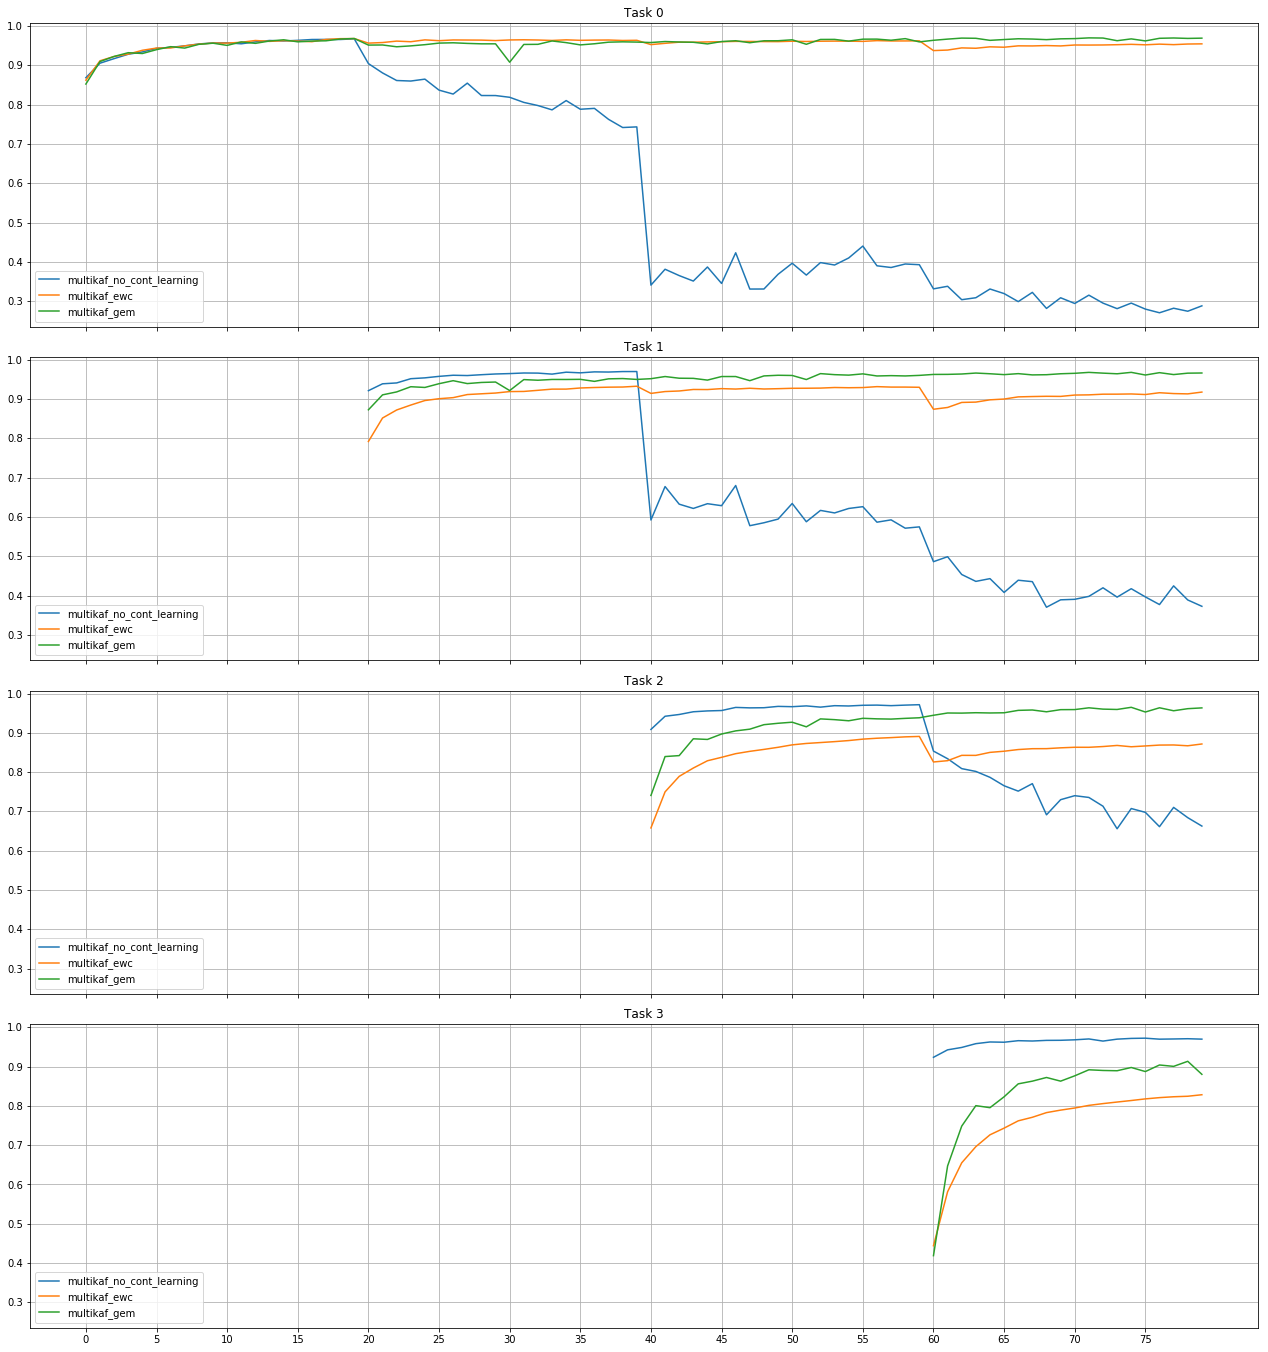

In [11]:
n_task = len(results[0][1]['tasks'])

tot_epochs = 0

for _, r in results:
    for k, v in r['tasks'].items():
        tot_epochs = max(tot_epochs, len(v['accuracy']))
      
fig, ax = plt.subplots(nrows=n_task, ncols=1, figsize=(22, 24), sharex=True, sharey=True)

for name, r in results:
    for i, task in enumerate(r['tasks'].keys()):

        com = r['tasks'][task]

        x = range(tot_epochs-len(com['accuracy']), tot_epochs)

        ax[i].plot(x, com['accuracy'], label=name)
        ax[i].set_xticks(range(0, tot_epochs, 5),minor=False)

        ax[i].set_title("Task {}".format(task))
        ax[i].legend(loc="lower left")
        ax[i].grid(True, axis='both')

        
fig.subplots_adjust(hspace=0.1, wspace=0.01)


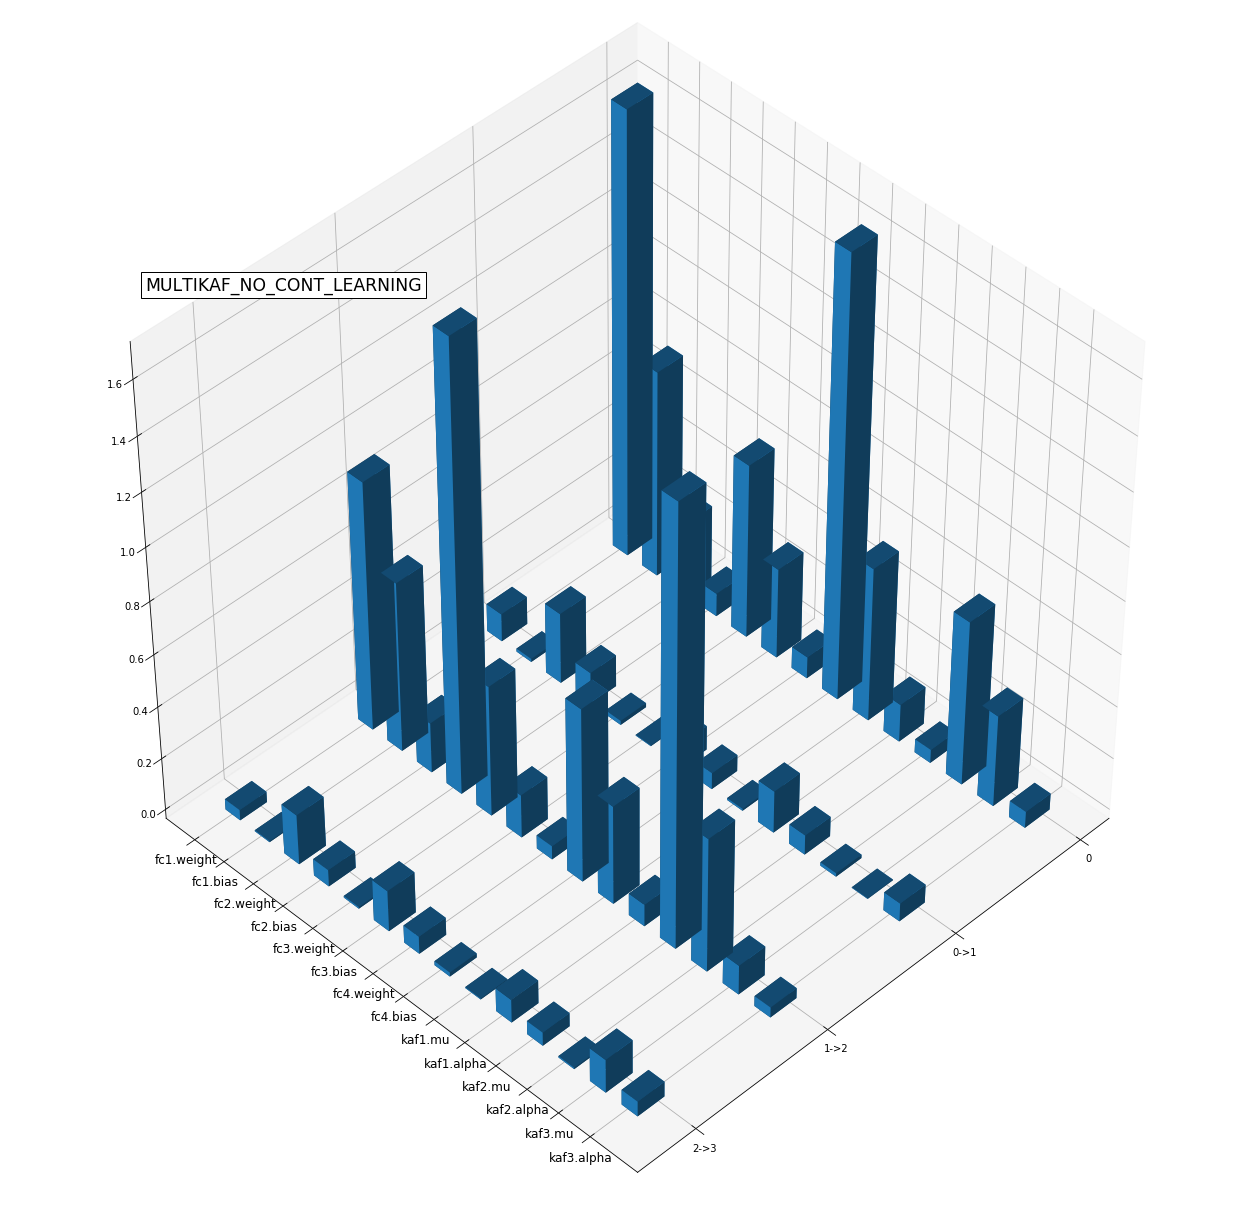

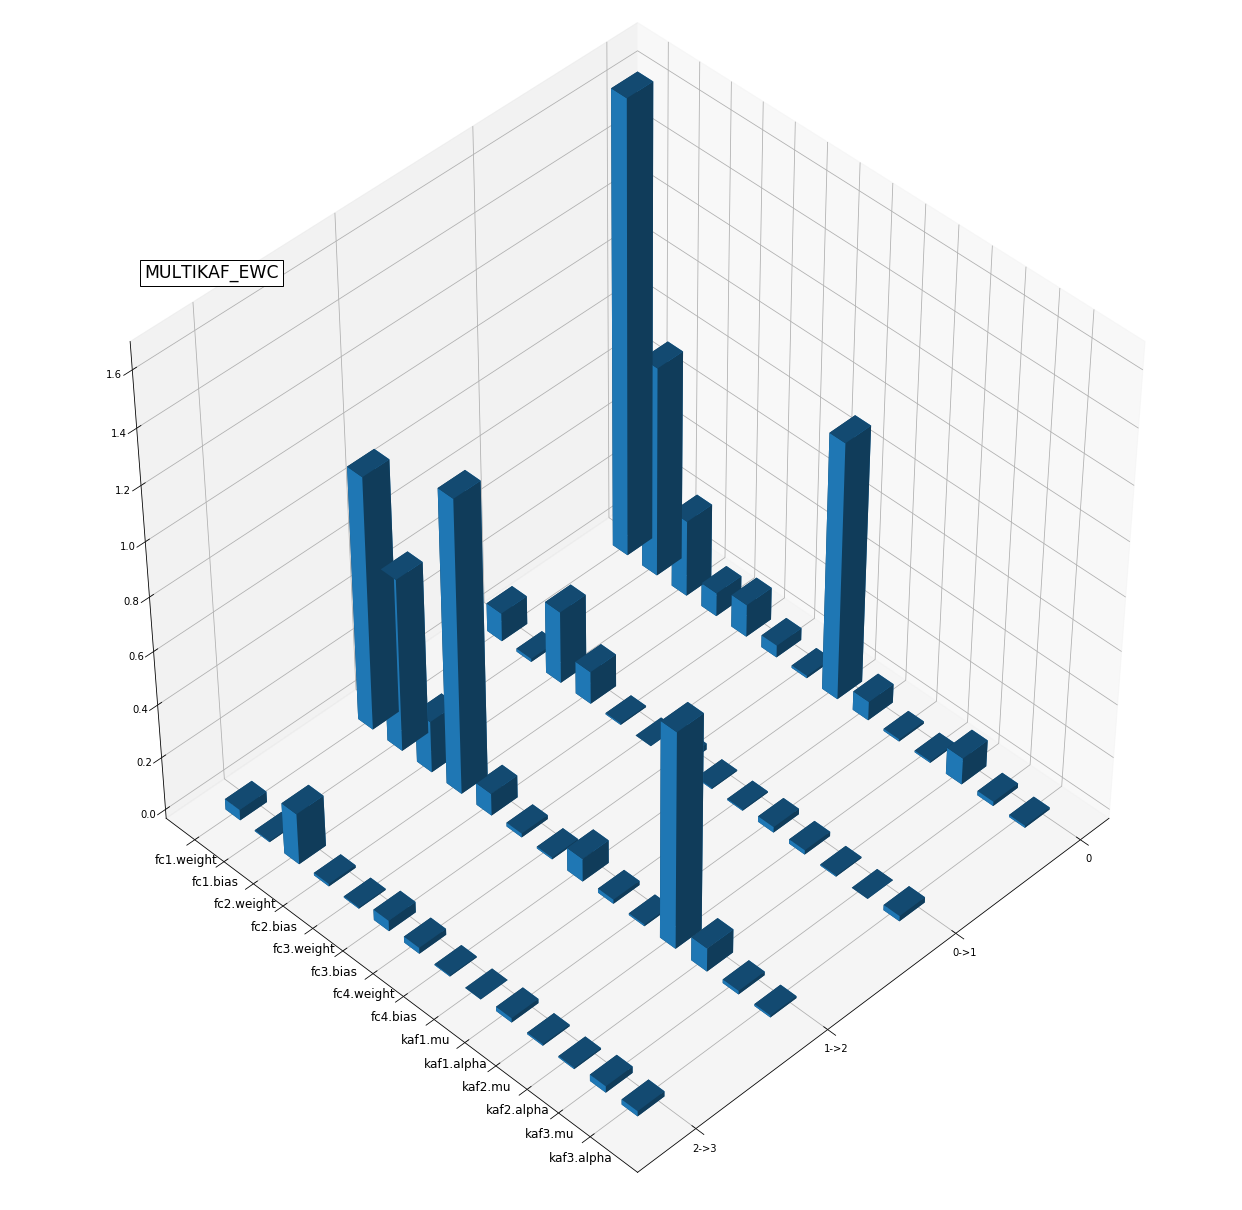

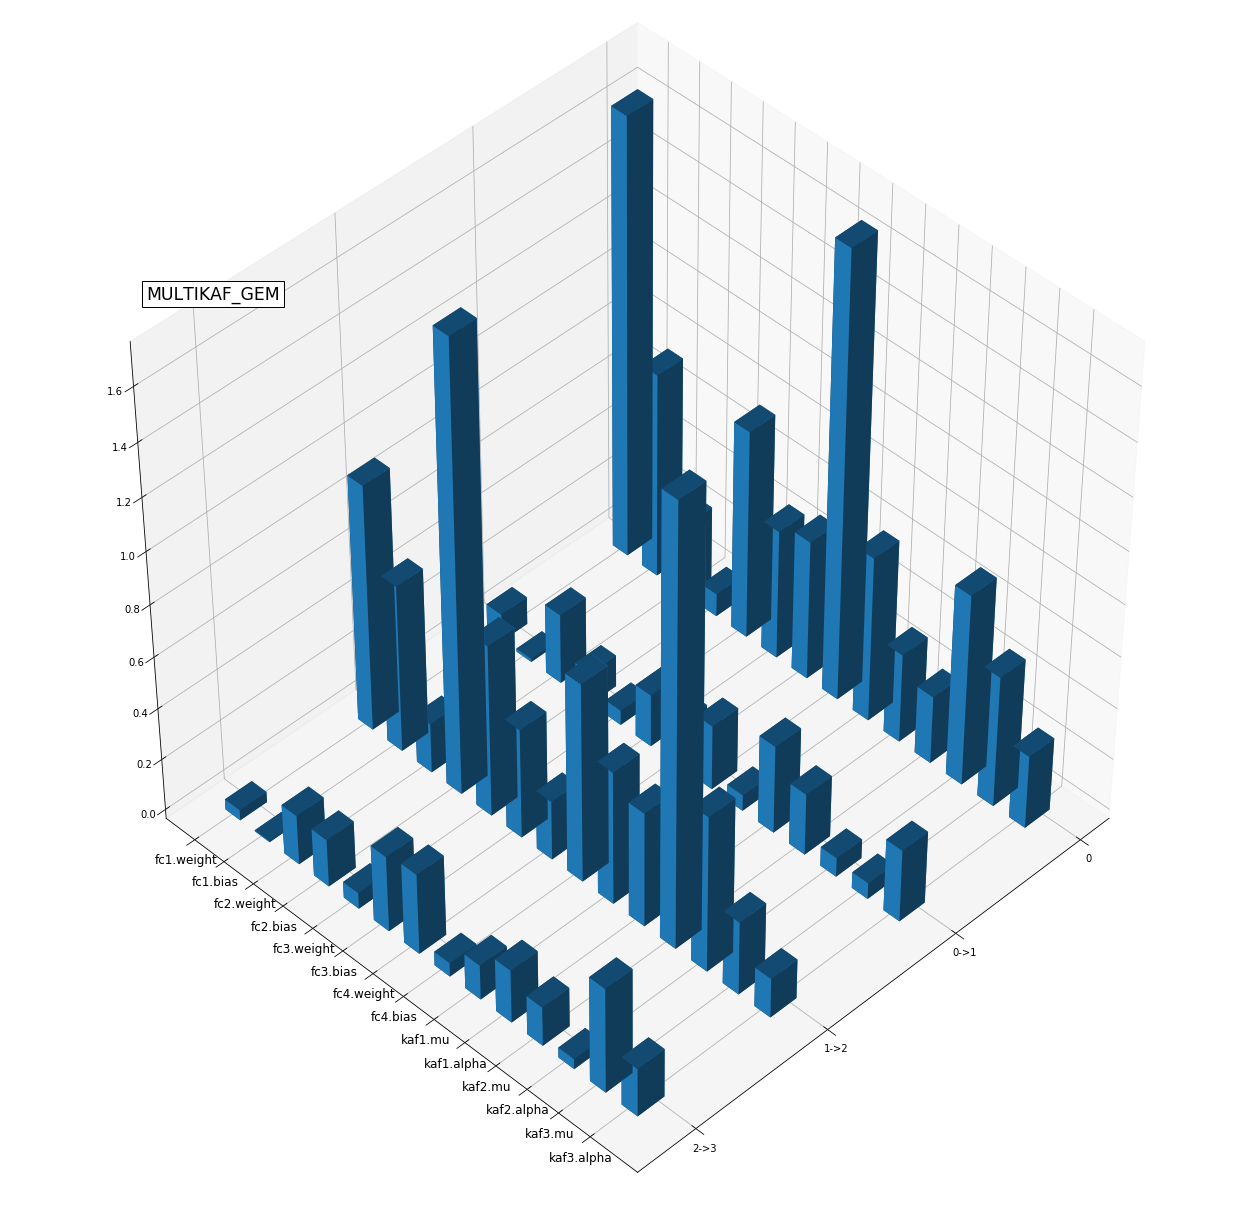

In [12]:
from mpl_toolkits.mplot3d import Axes3D

for name, tec in experiments_multikaf:
    
    net = multikaf

    current_w = {n:p.cpu() for n, p in multikaf.named_parameters() if p.requires_grad}

    x = np.arange(4)
    y = np.arange(len(current_w))
    
    xx, yy = np.meshgrid(x, y)
    z = np.zeros(shape=(len(x), len(y)))
    
    fig = plt.figure(figsize=(22, 22))
    ax = fig.add_subplot(111, projection='3d')
    
    x_labels = []
    
    for i in x:

        if i == 0:
            x_labels.append('0')
        else:
            x_labels.append('{}->{}'.format(i-1, i))
            
        n = deepcopy(net)
        config = deepcopy(configOnline)

        config.MODEL_NAME = name
                                                                                                                                    
        if 'name' == 'gem':
            config.EWC_IMPORTANCE = 0.5

        config.EWC_TYPE = tec

        trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

        r = trainer.load(i)
            
        diff = {n: torch.dist(p.cpu(), current_w[n]) for n, p in trainer.model.named_parameters() if p.requires_grad }
        current_w = {n: p.cpu() for n, p in trainer.model.named_parameters() if p.requires_grad }
        
        for j, (_, d) in enumerate(diff.items()):
            z[i, j] = d
    
    
    z_n = z.flatten()

    ax.view_init(45, 45)
    
    ax.bar3d(xx.flatten(),
          yy.flatten(),
          np.zeros(len(z_n)),
          0.2, 0.5, z_n )
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    
    ax.set_yticks(y)
    ax.set_yticklabels(list(diff.keys()), fontdict={'fontsize':12})
    
    ax.text(3.5, 0, 2, name.upper(), color='black',  fontsize='xx-large', 
        bbox=dict(facecolor='white', edgecolor='black'))
    
    plt.show()
    

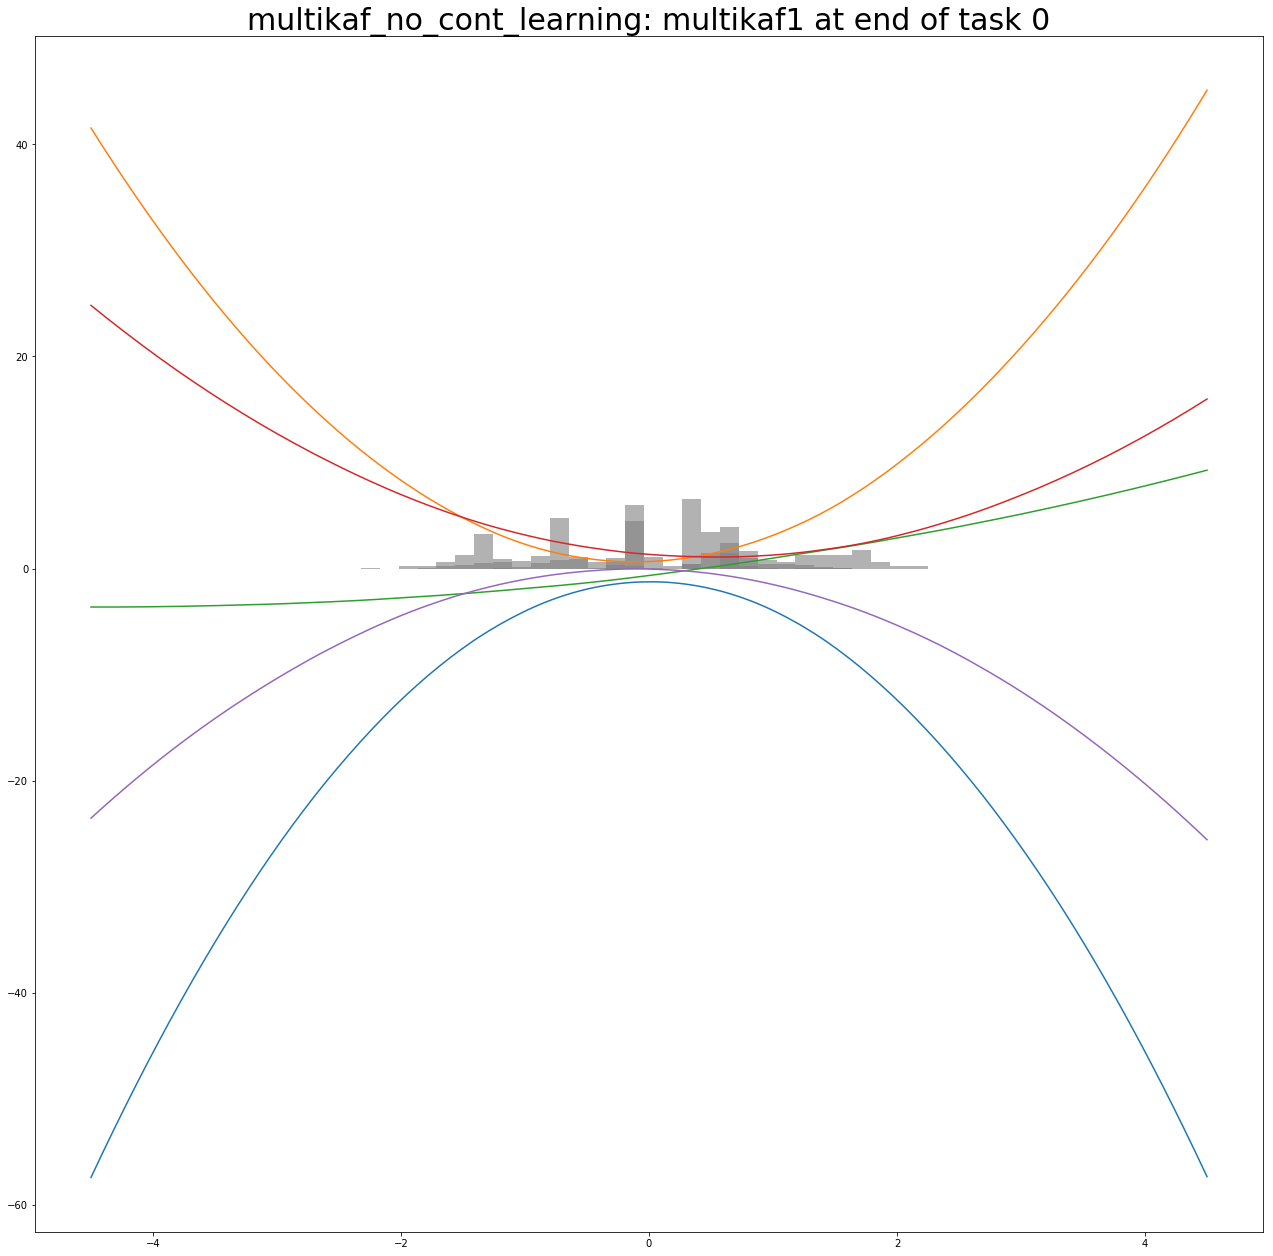

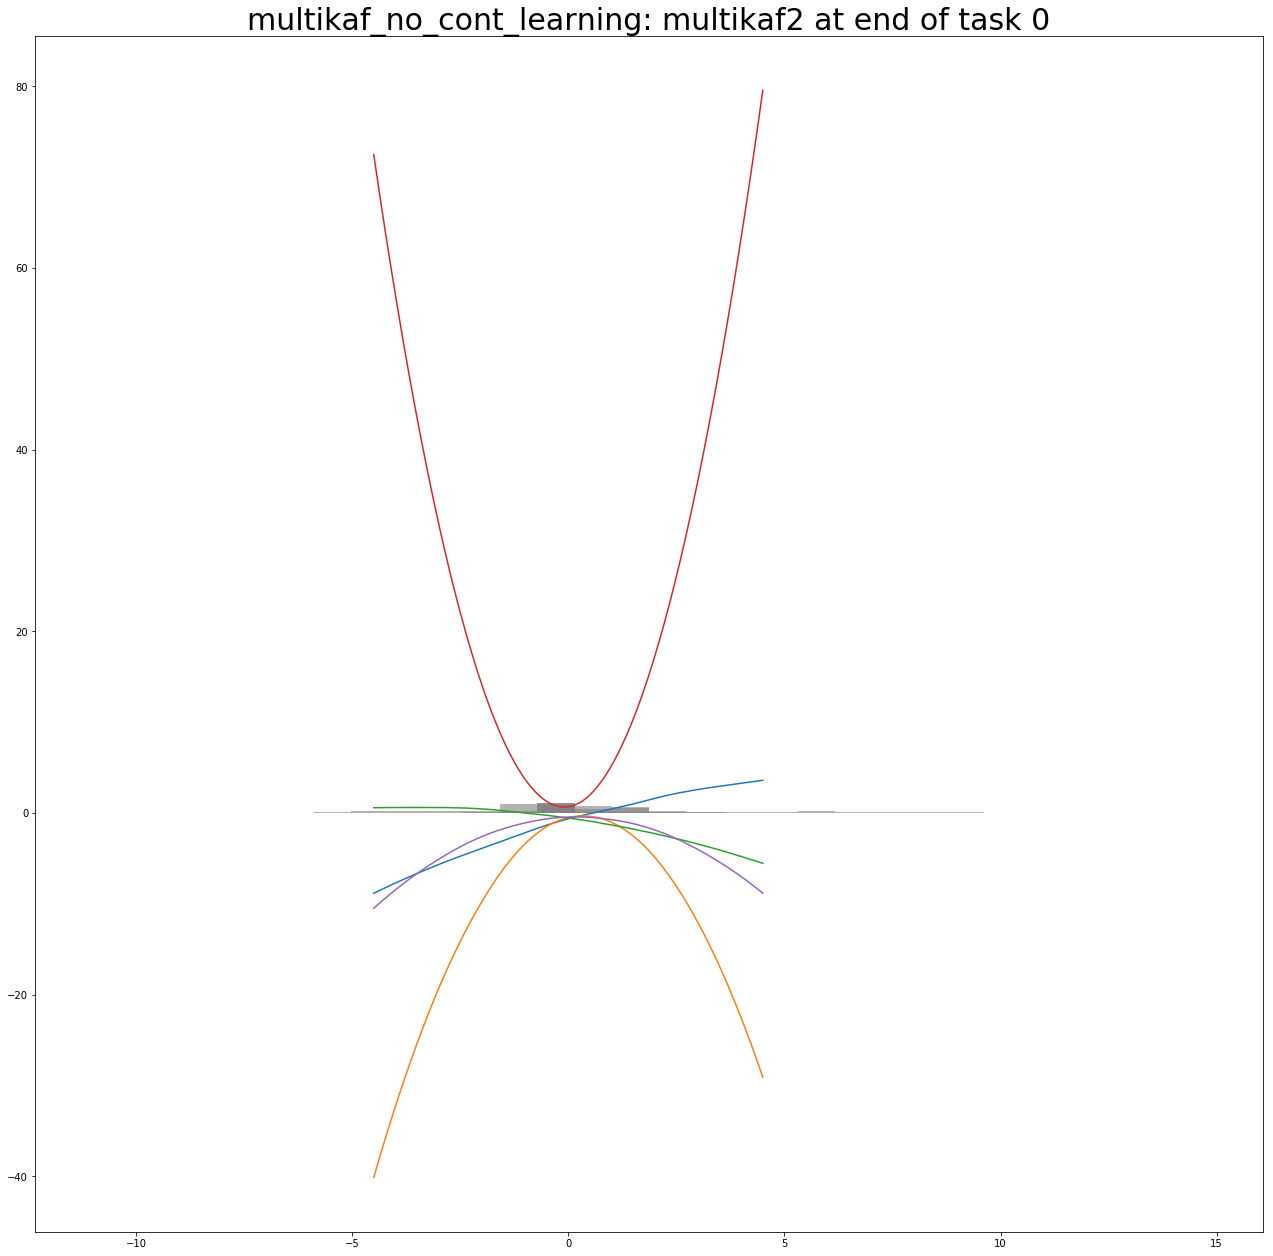

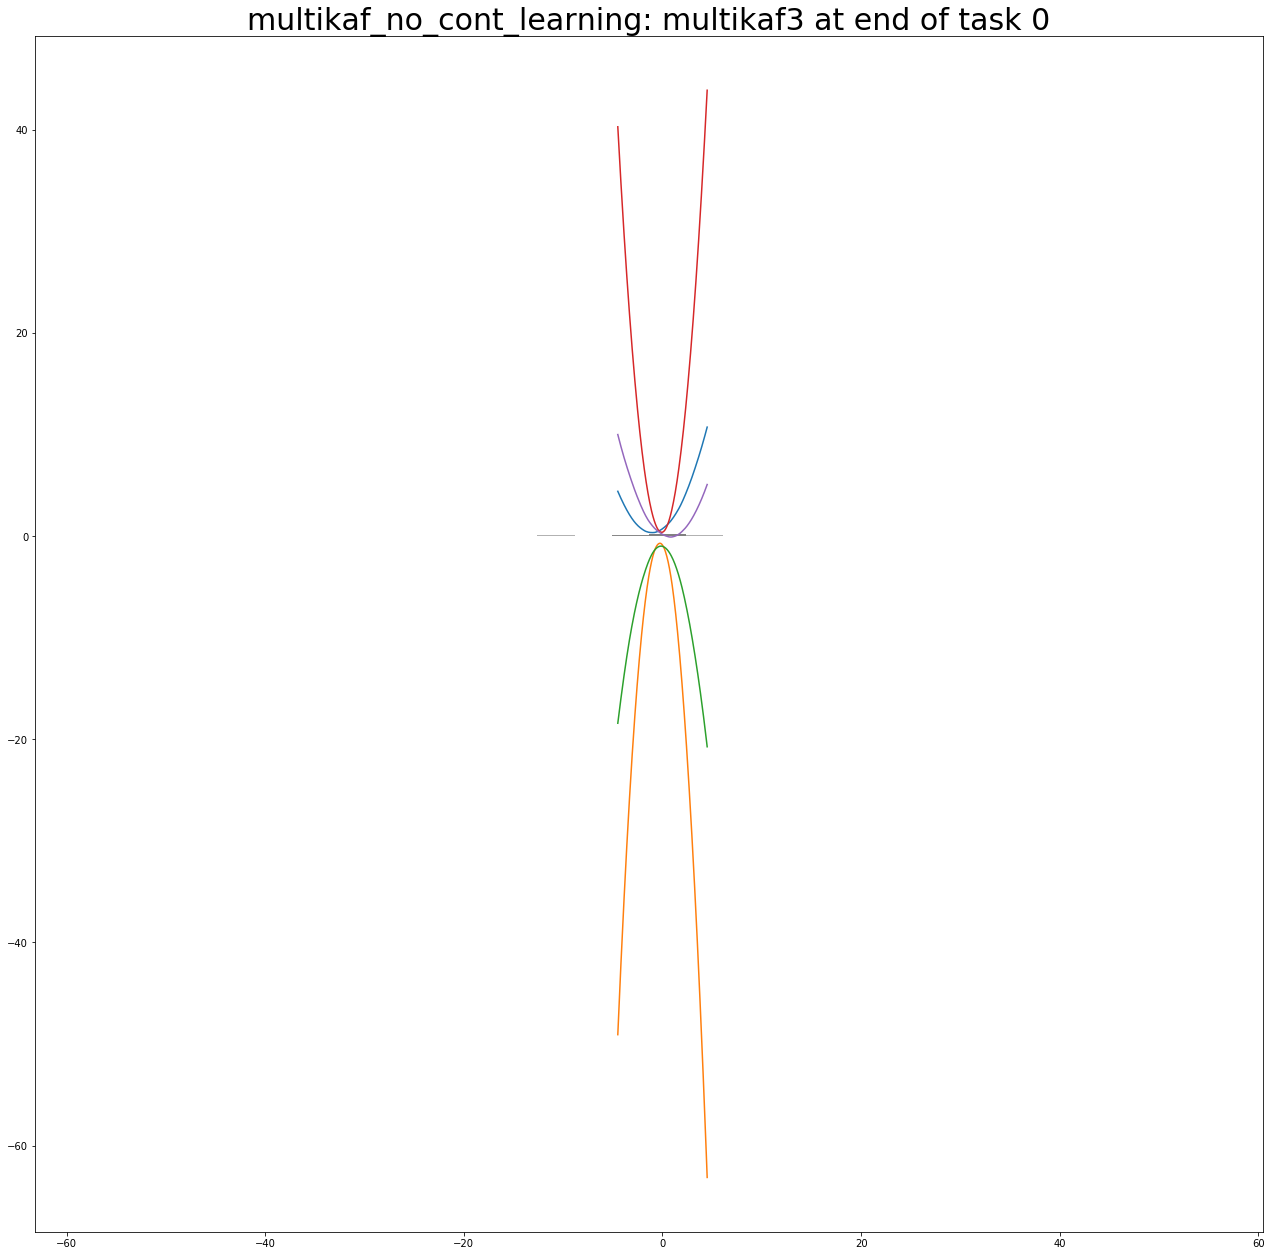

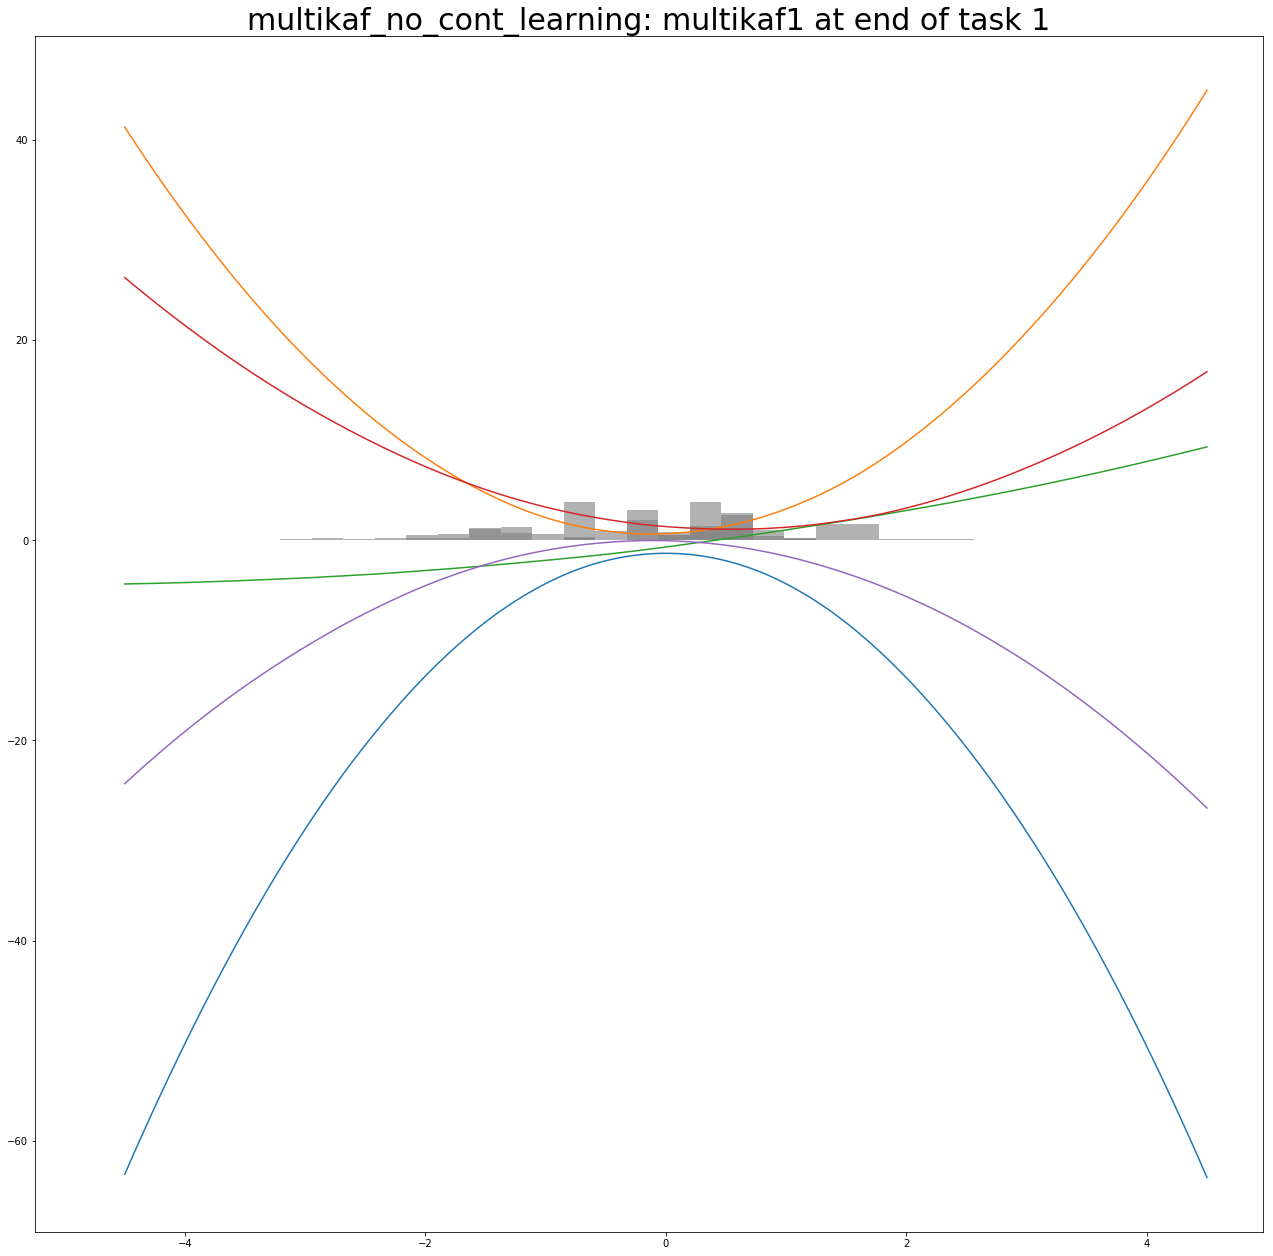

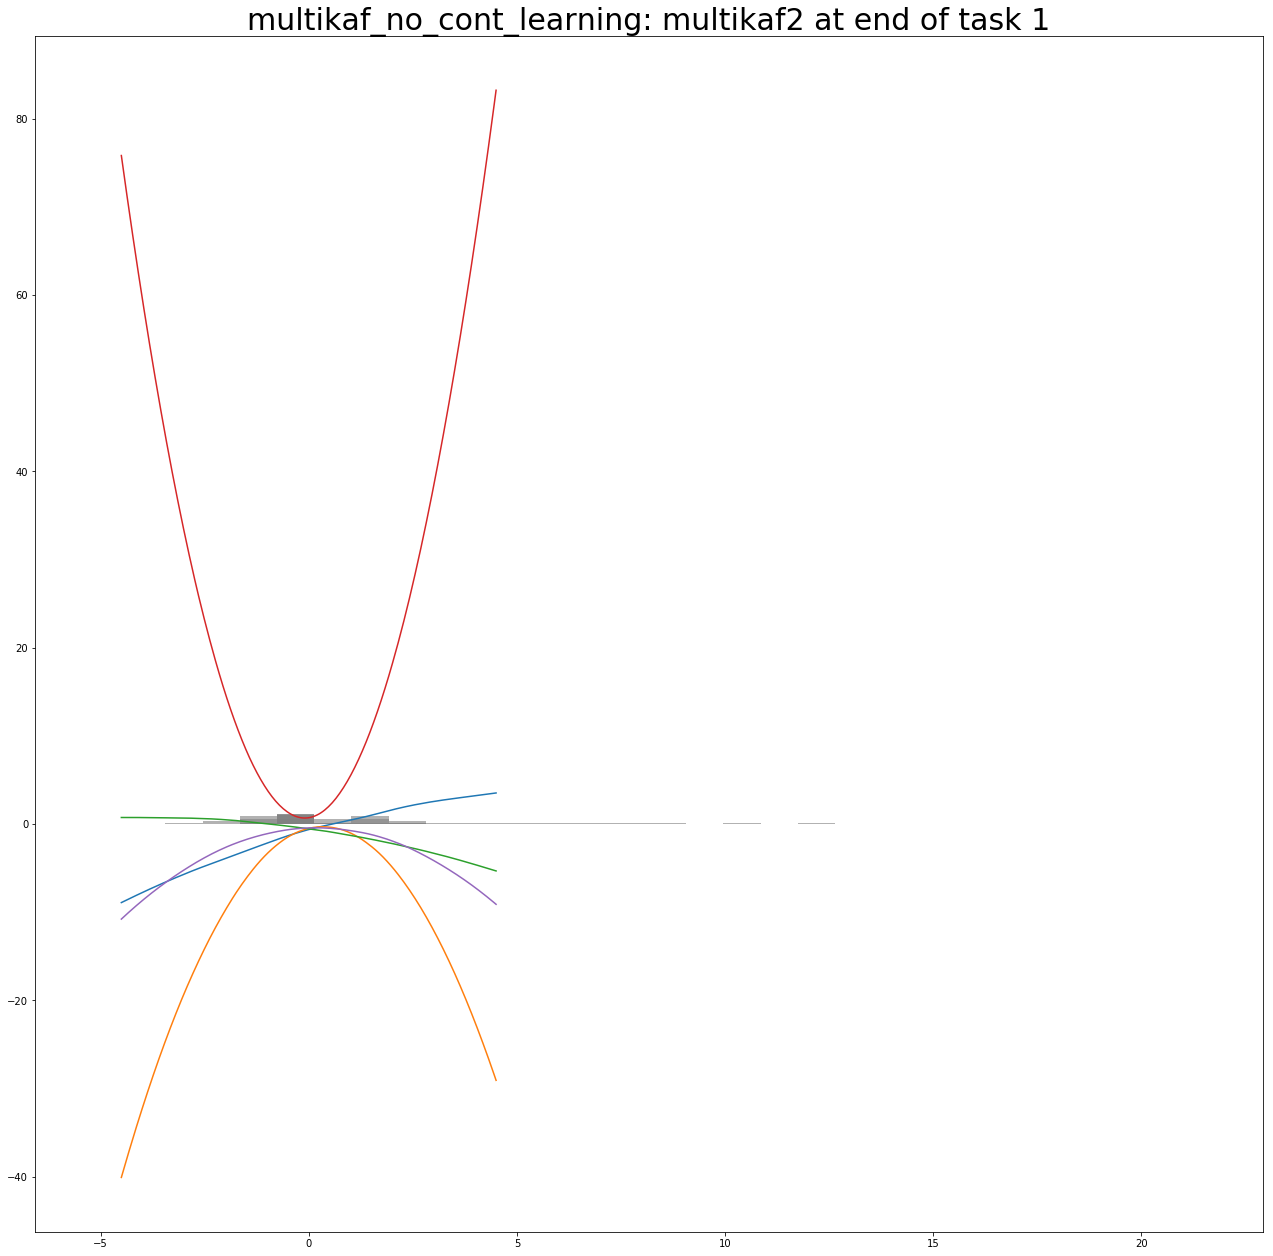

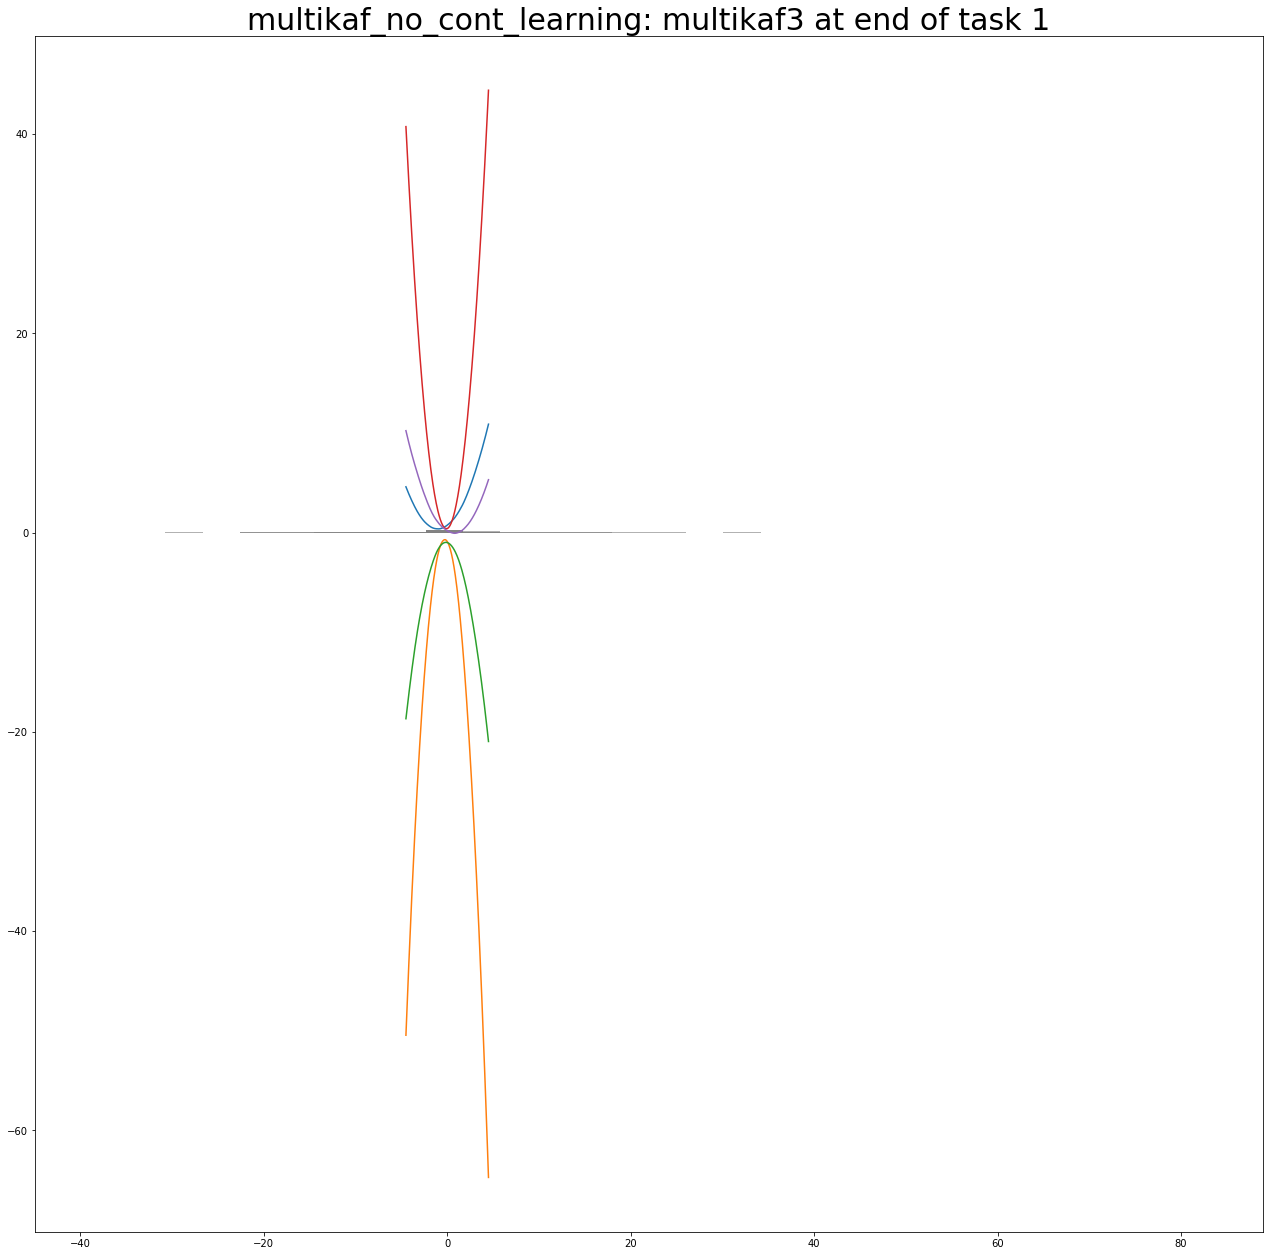

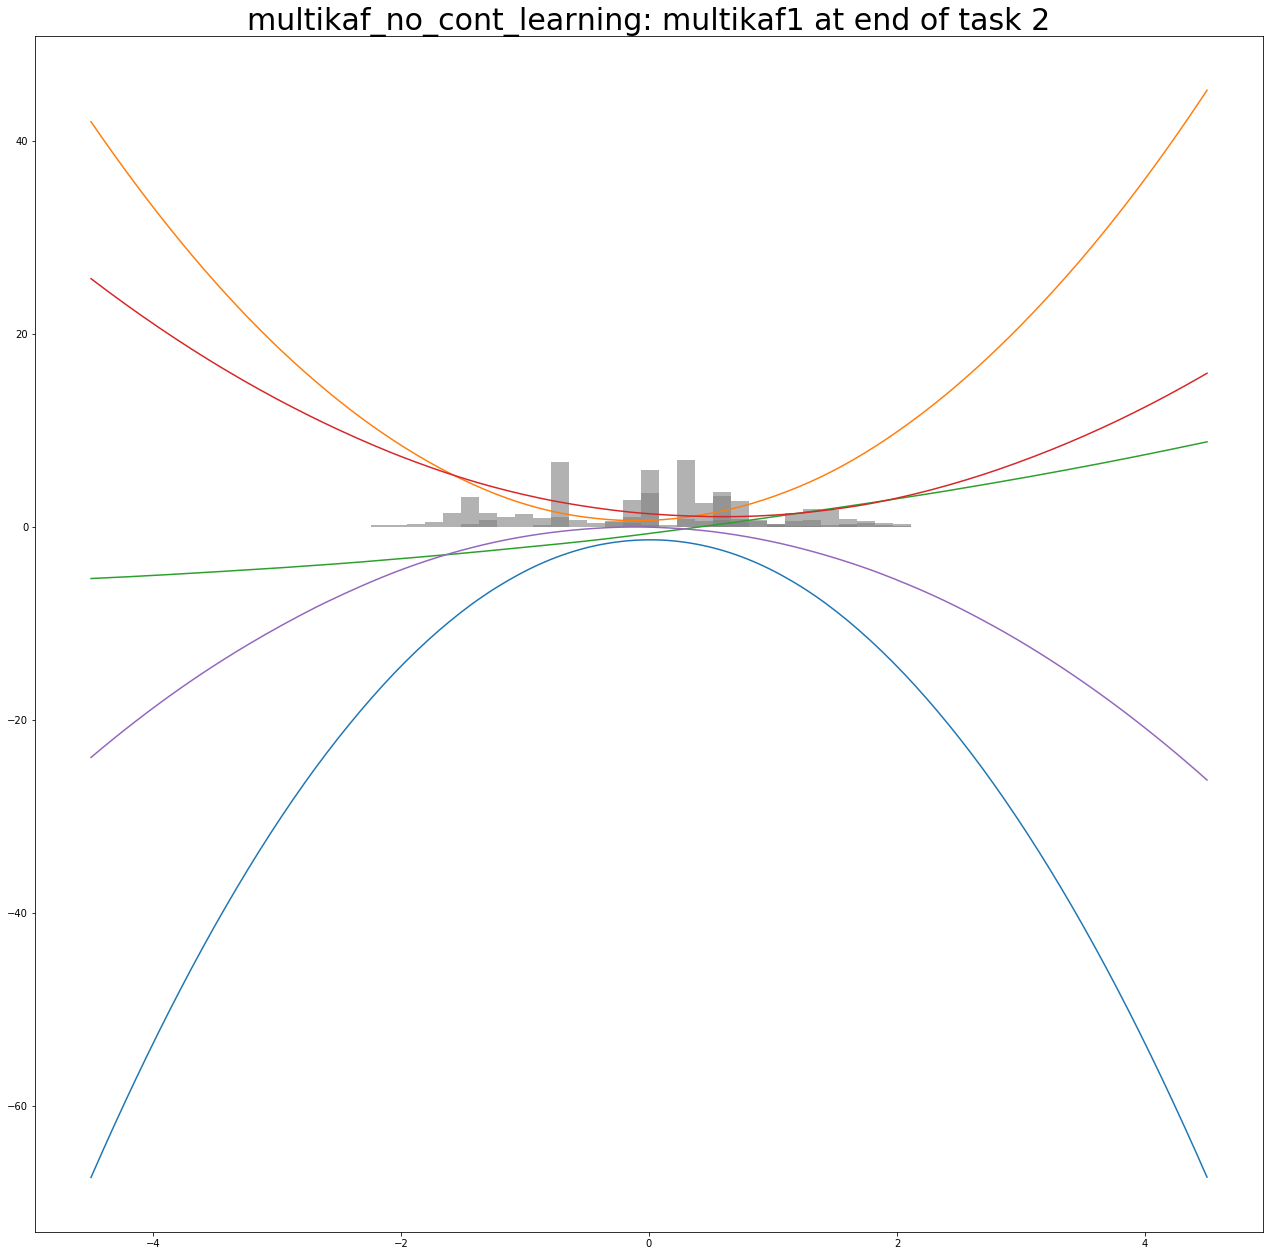

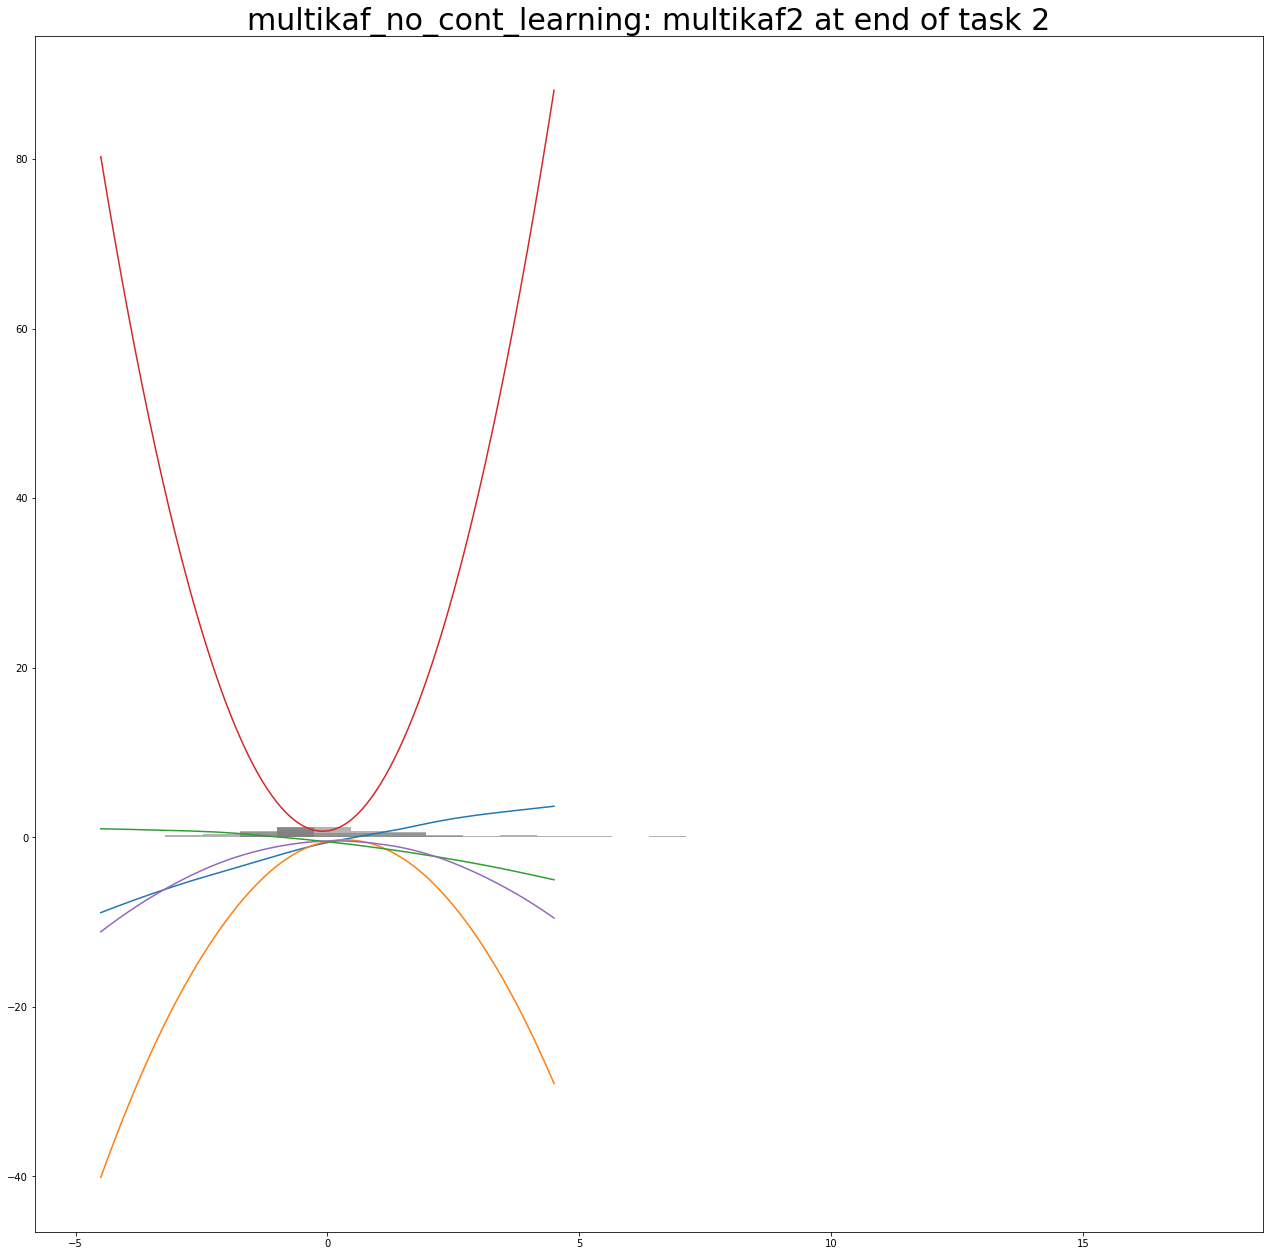

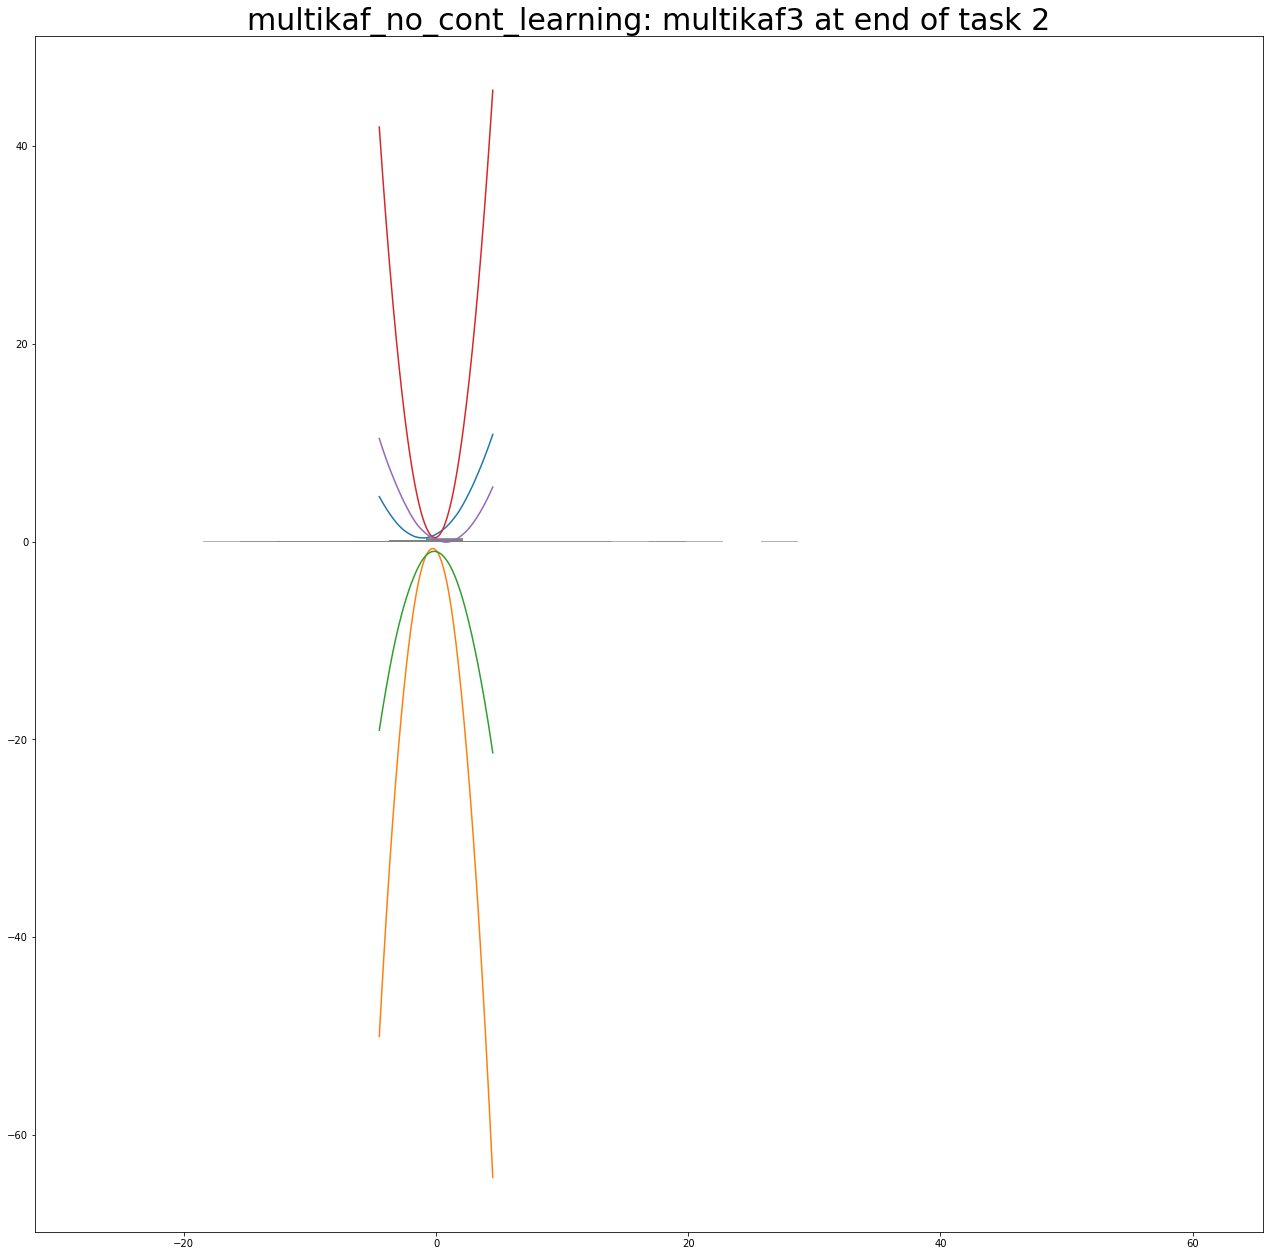

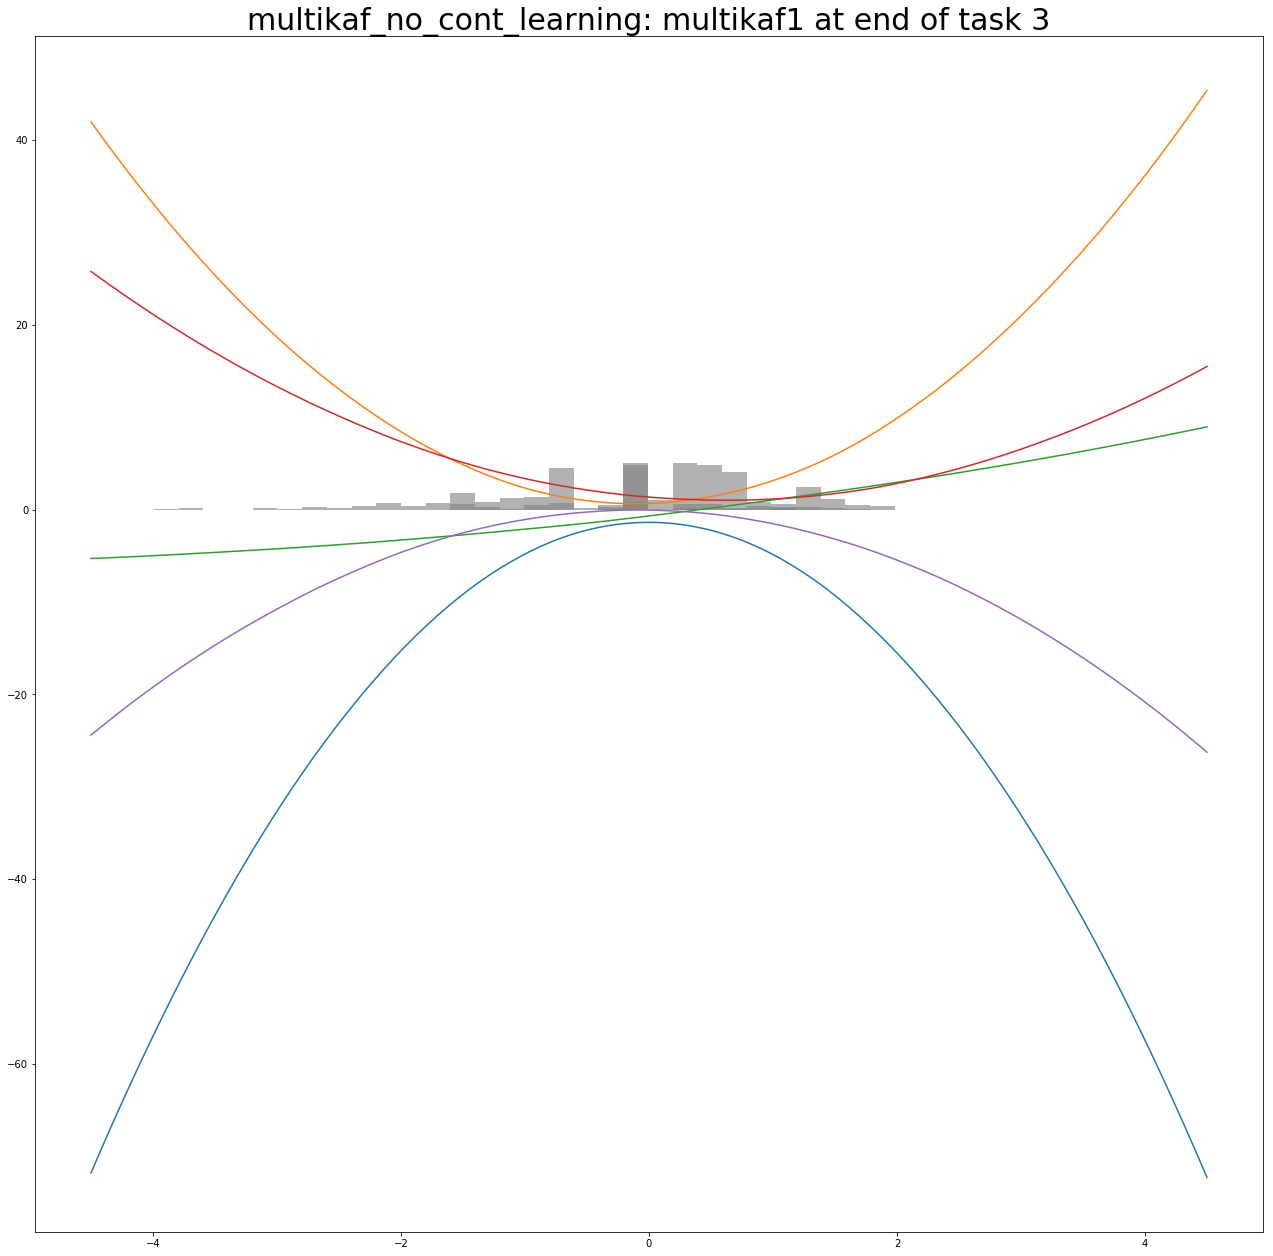

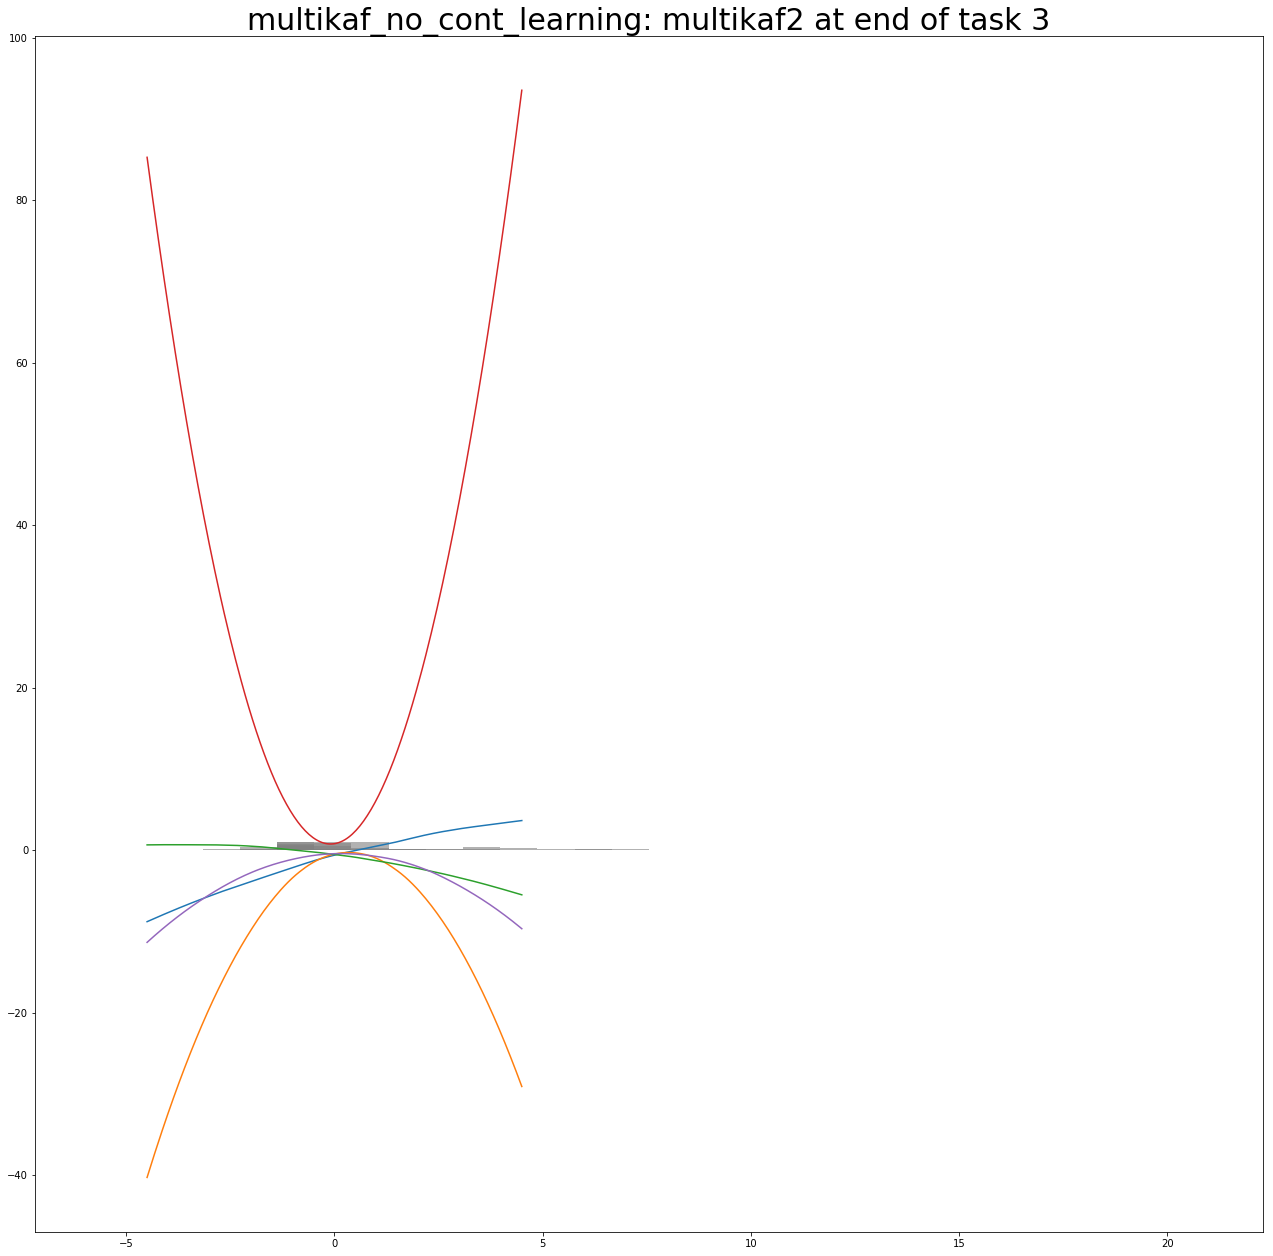

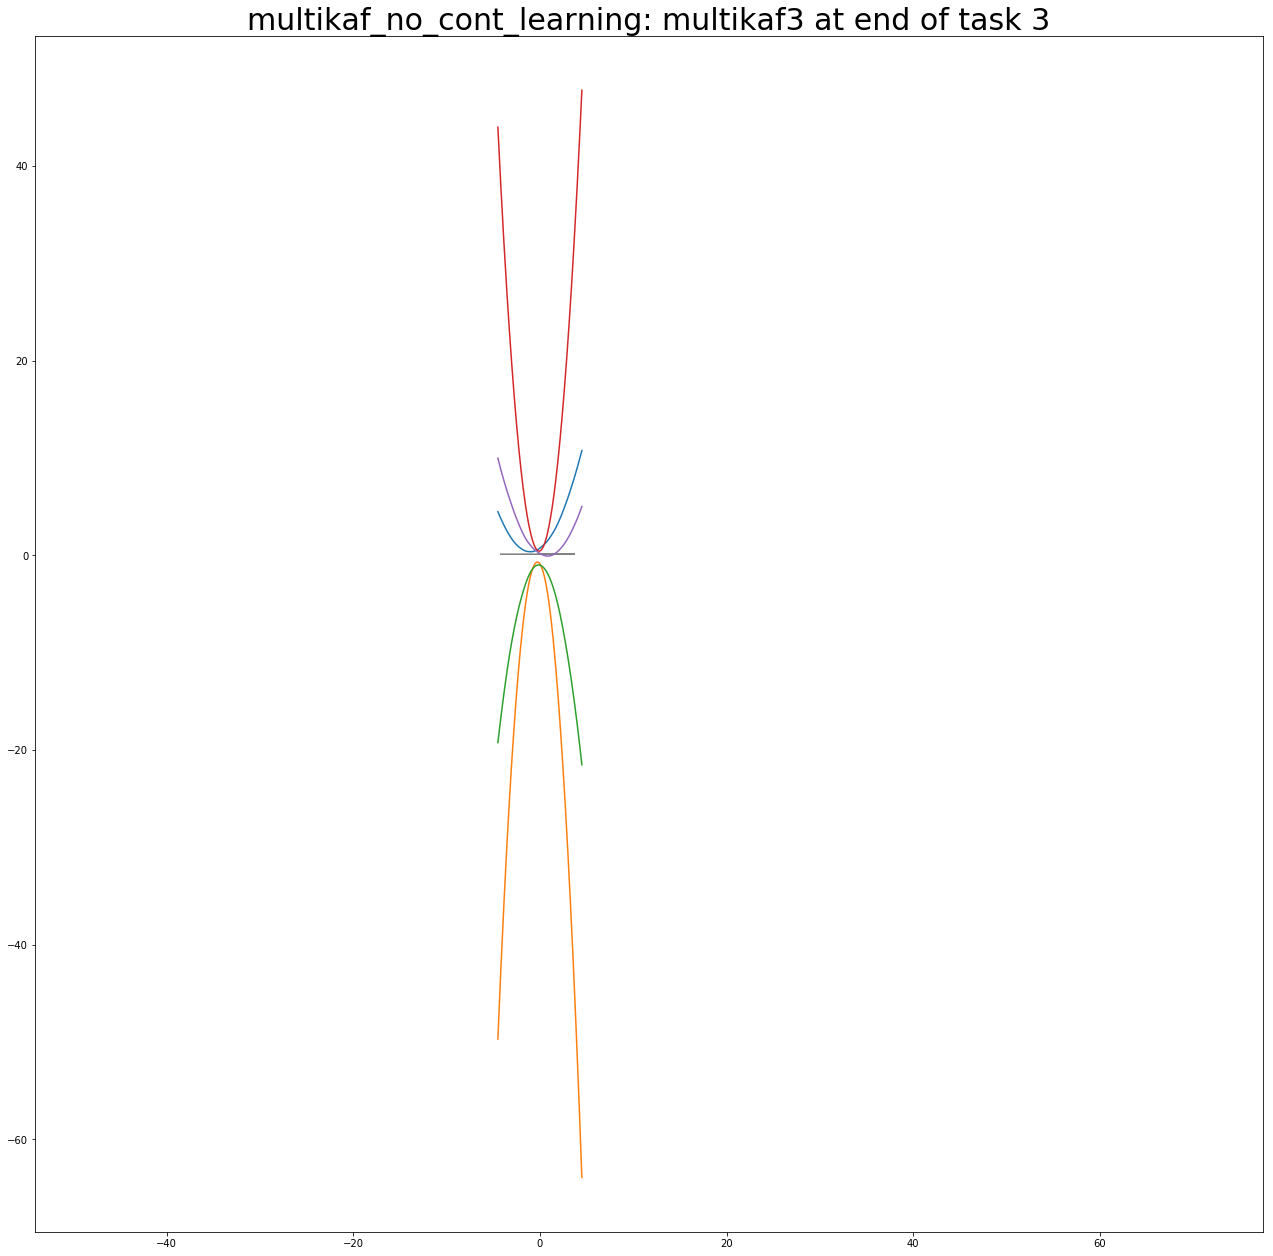

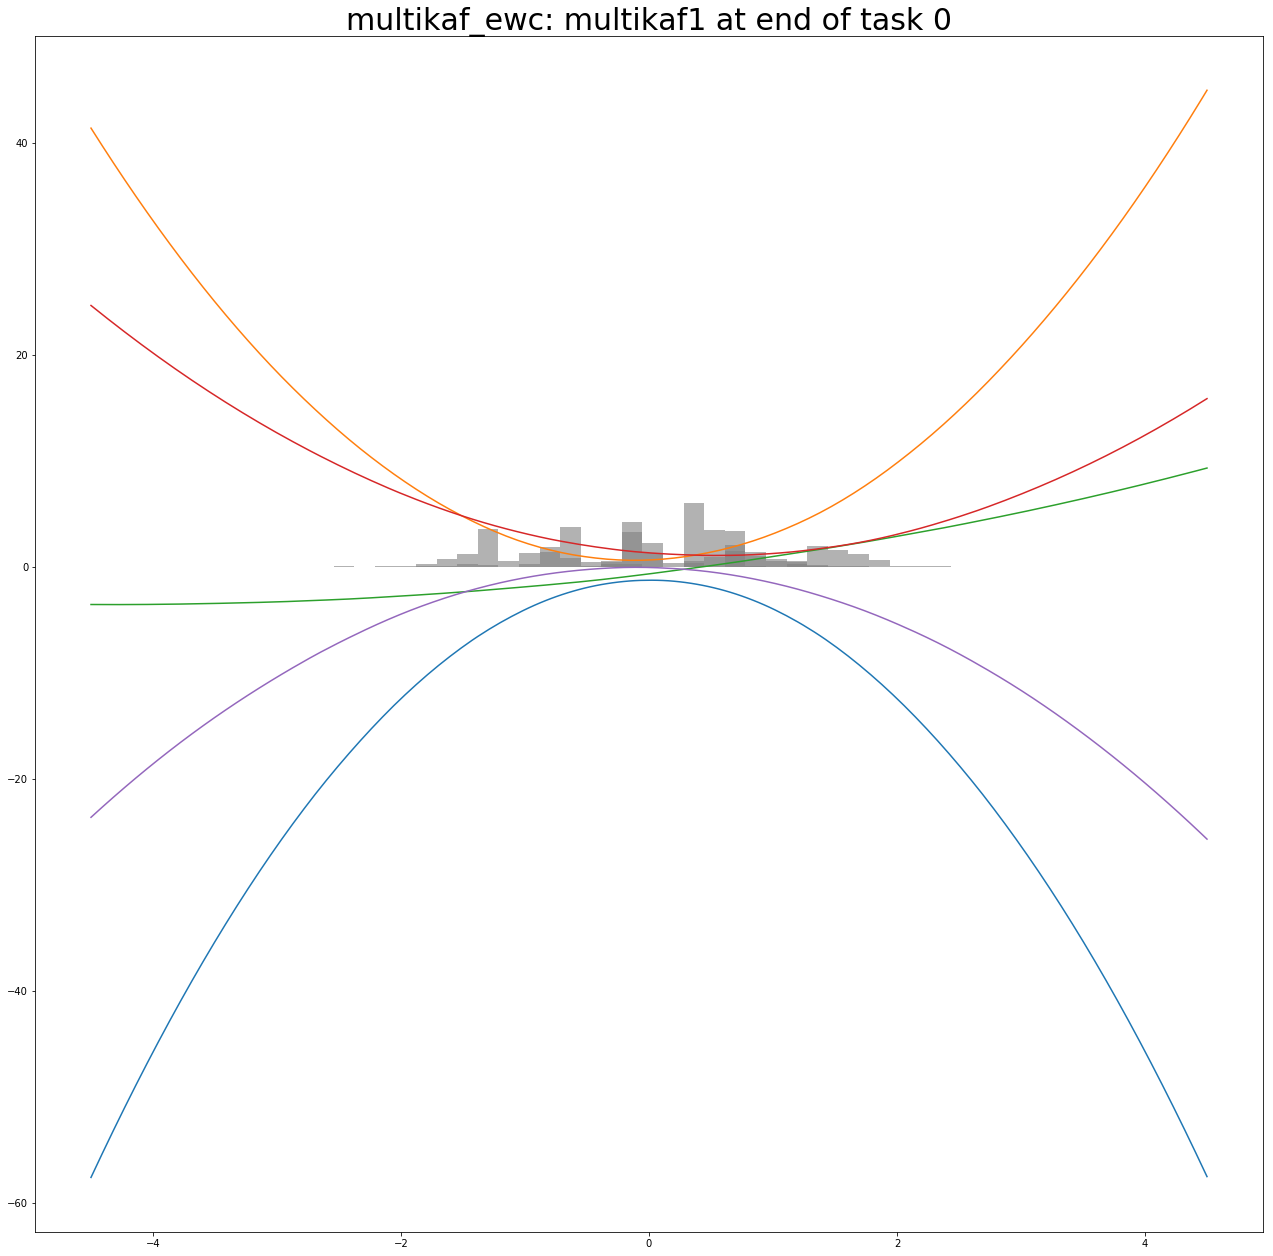

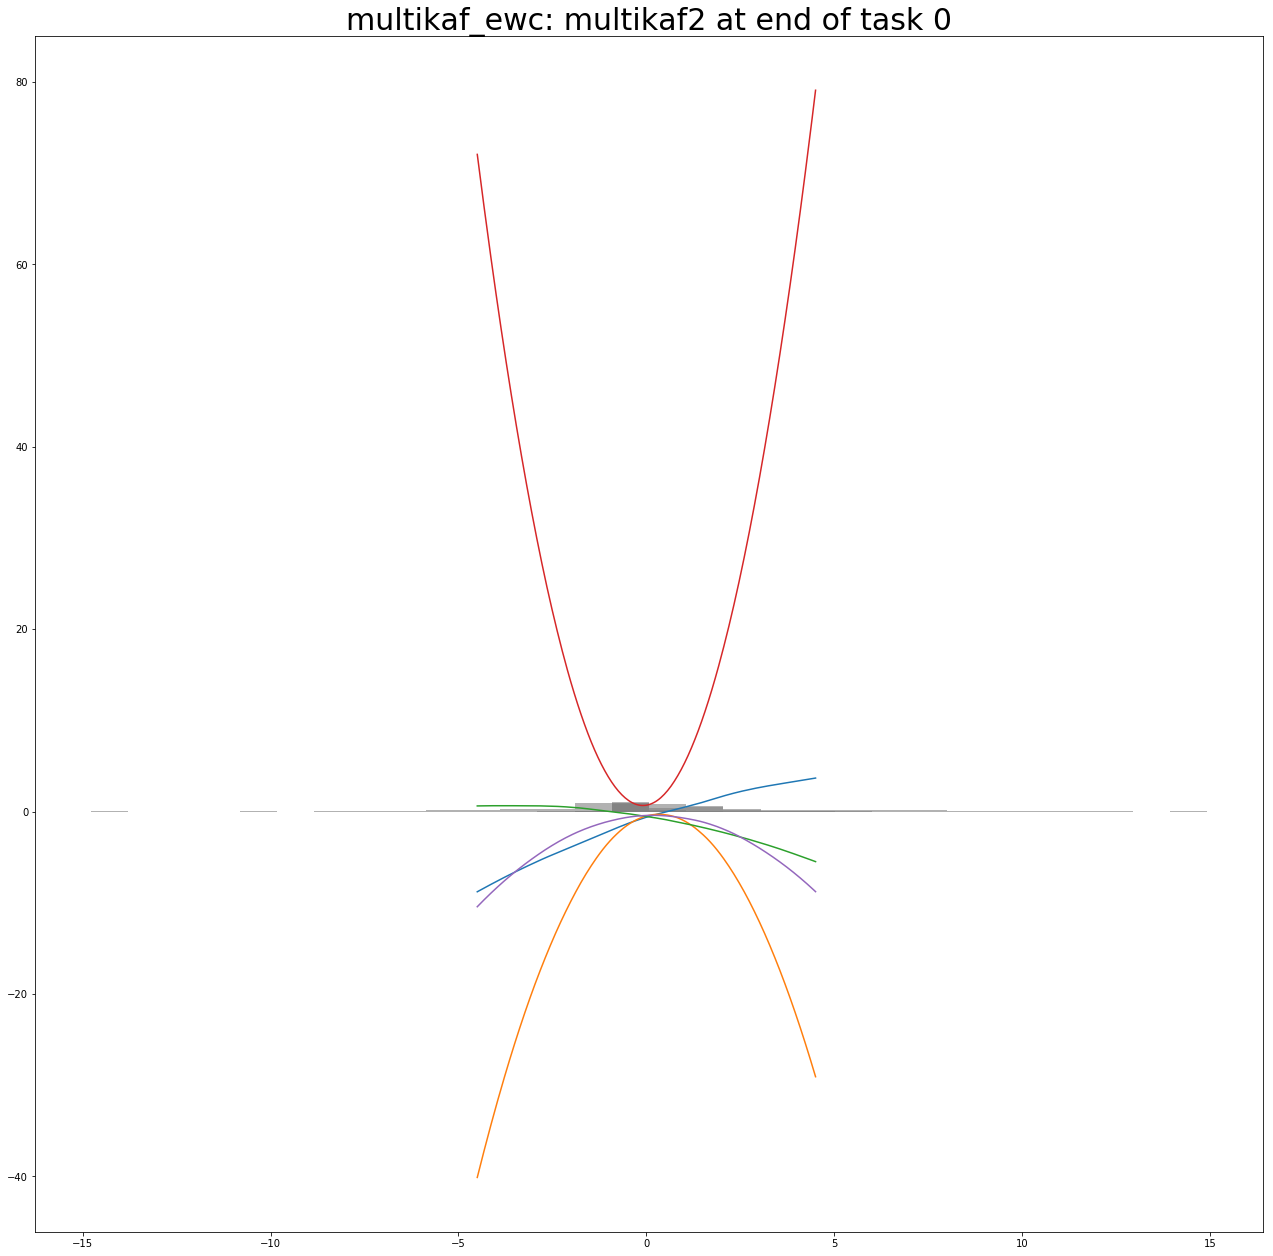

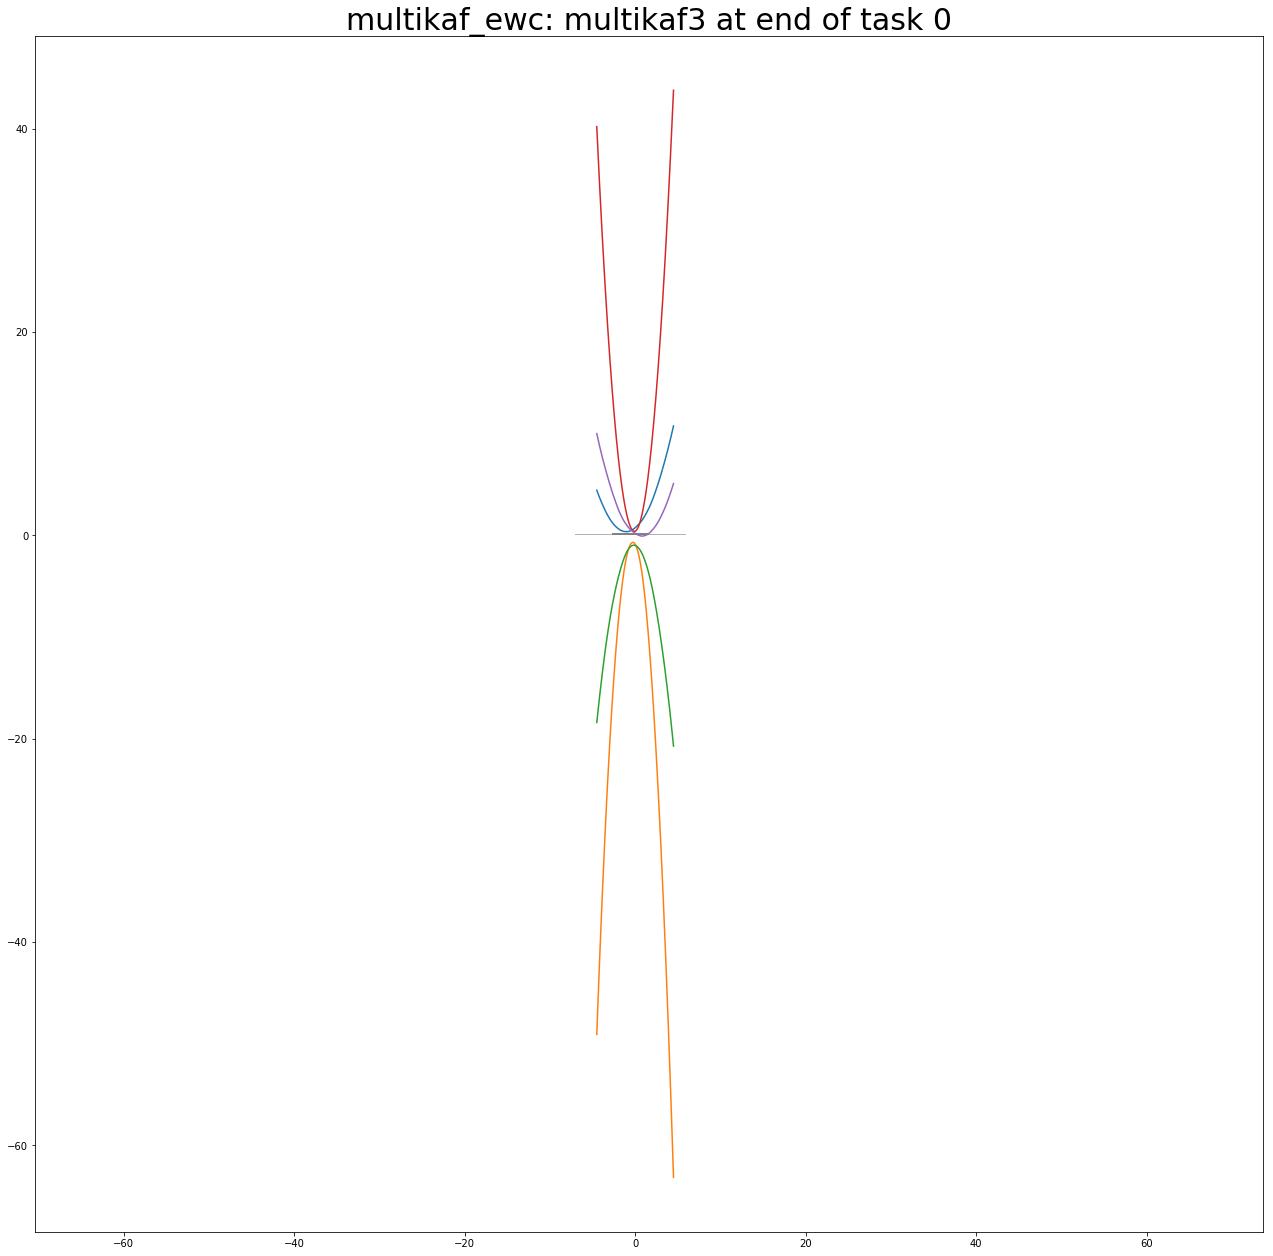

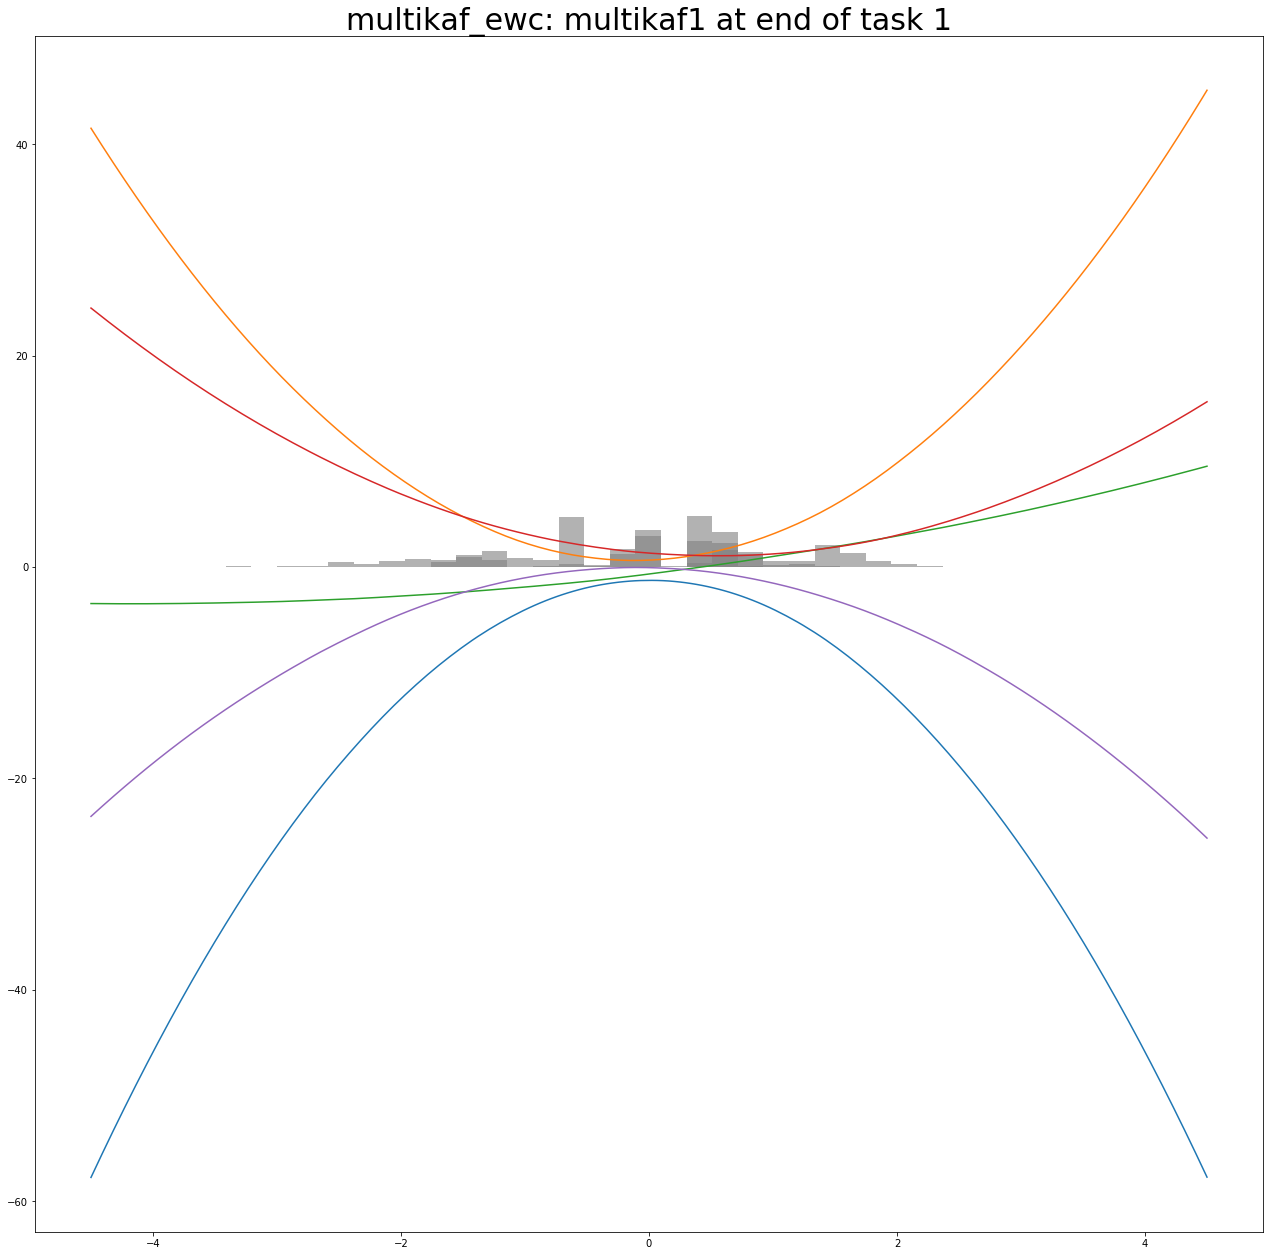

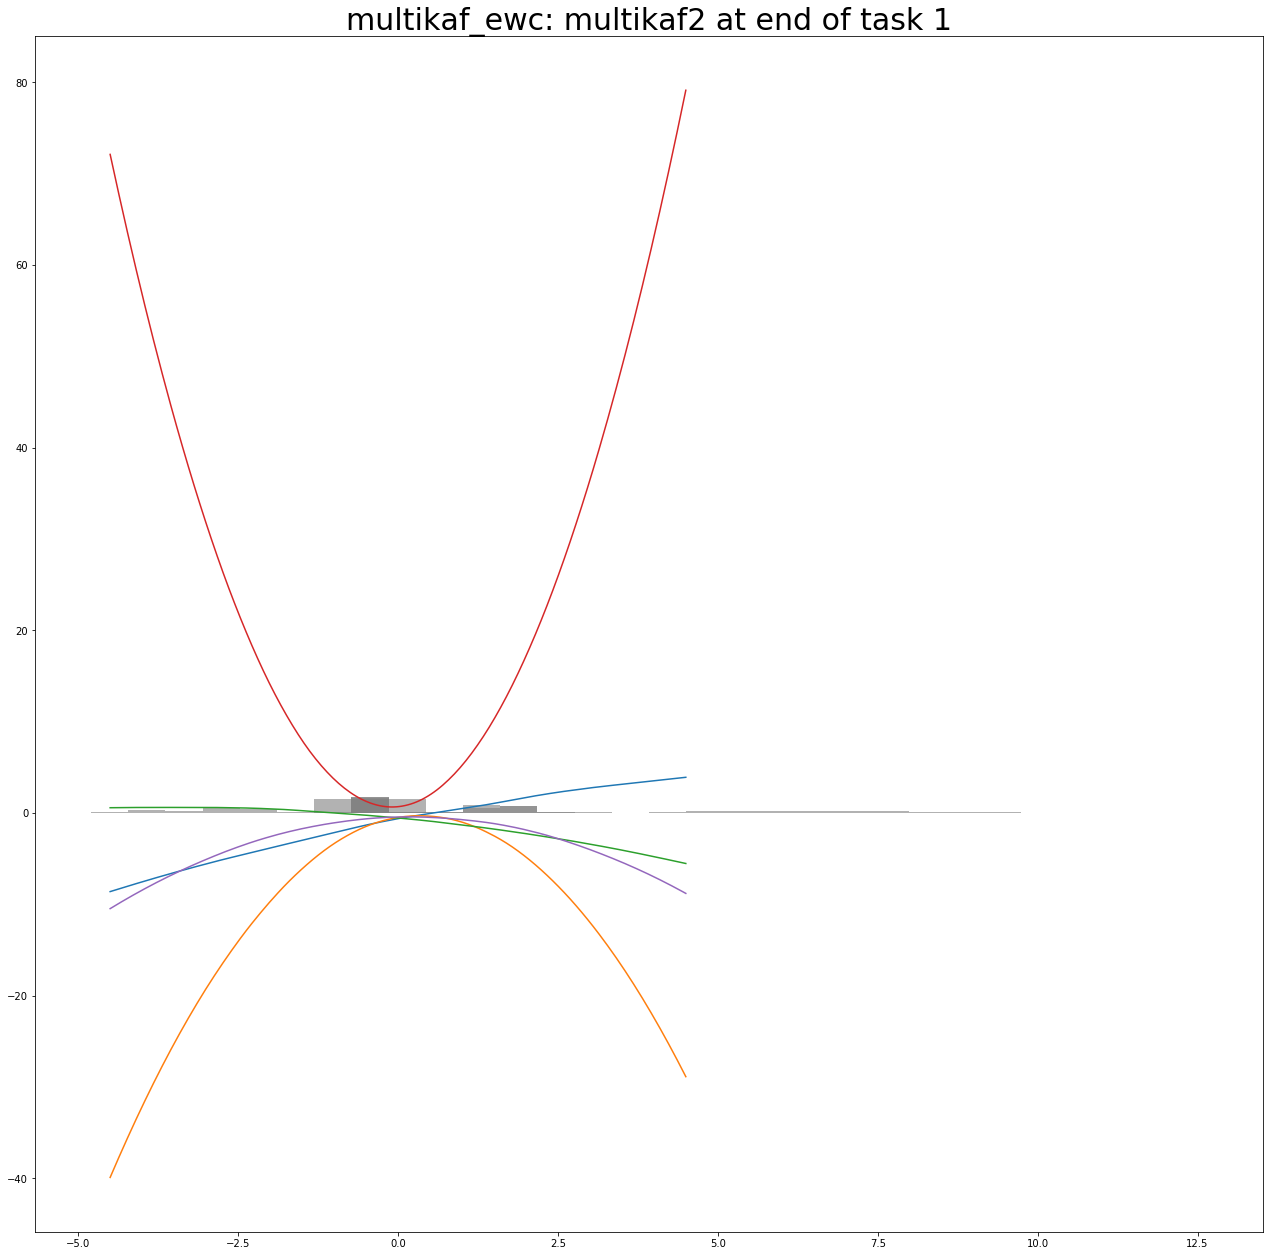

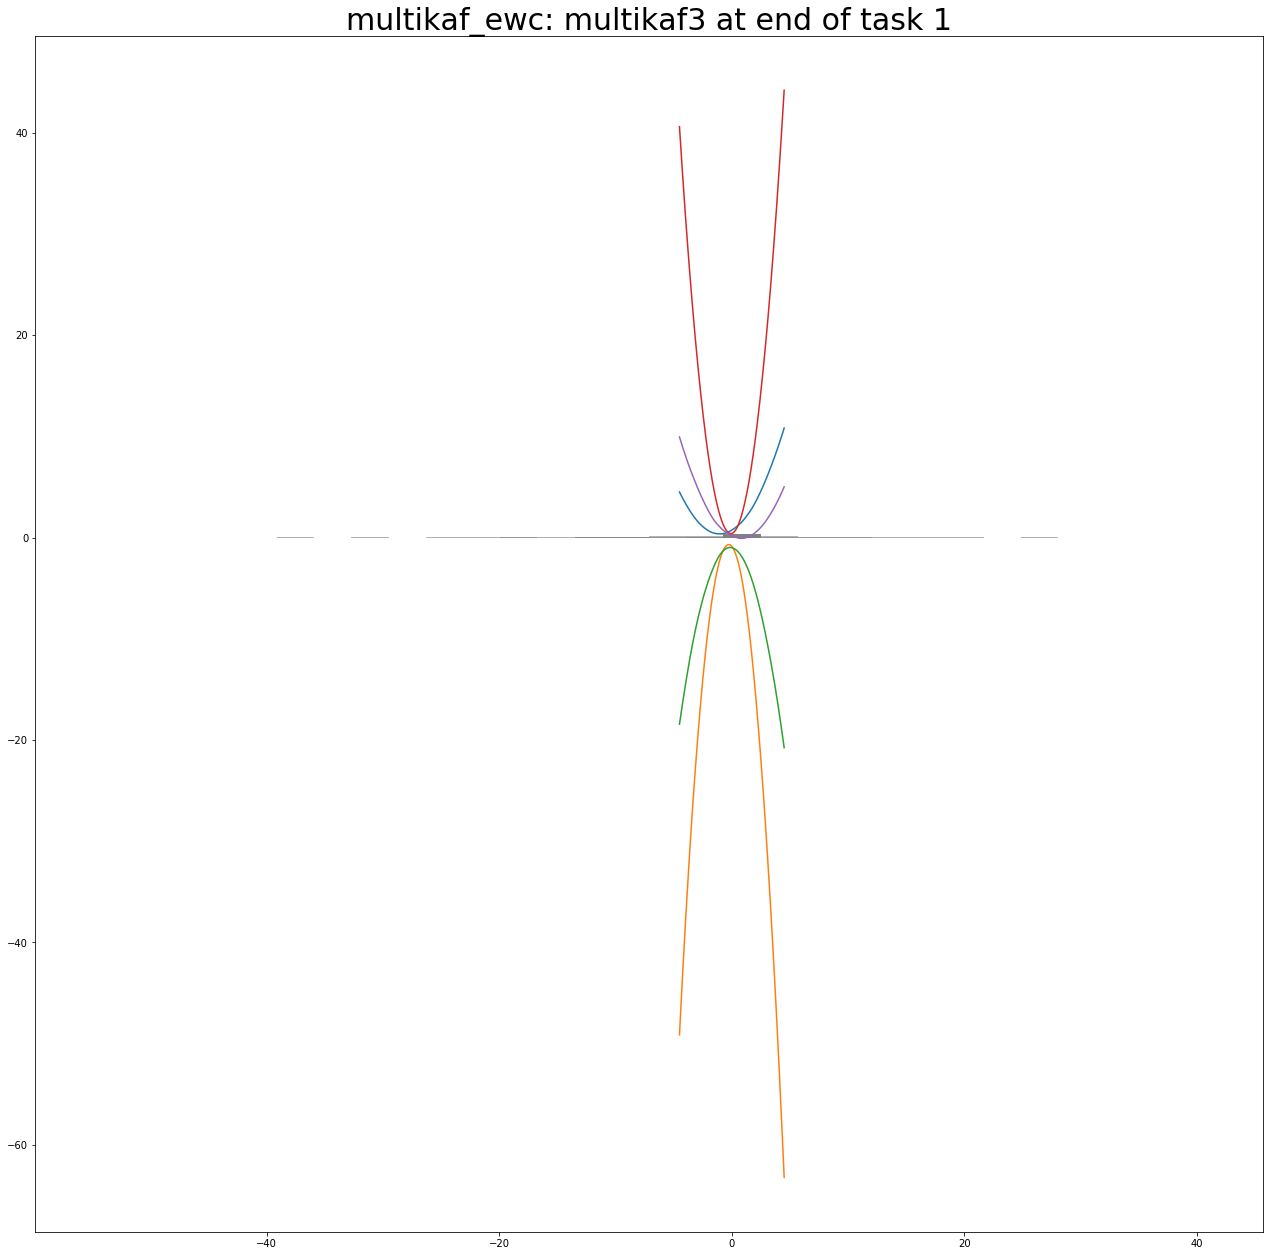

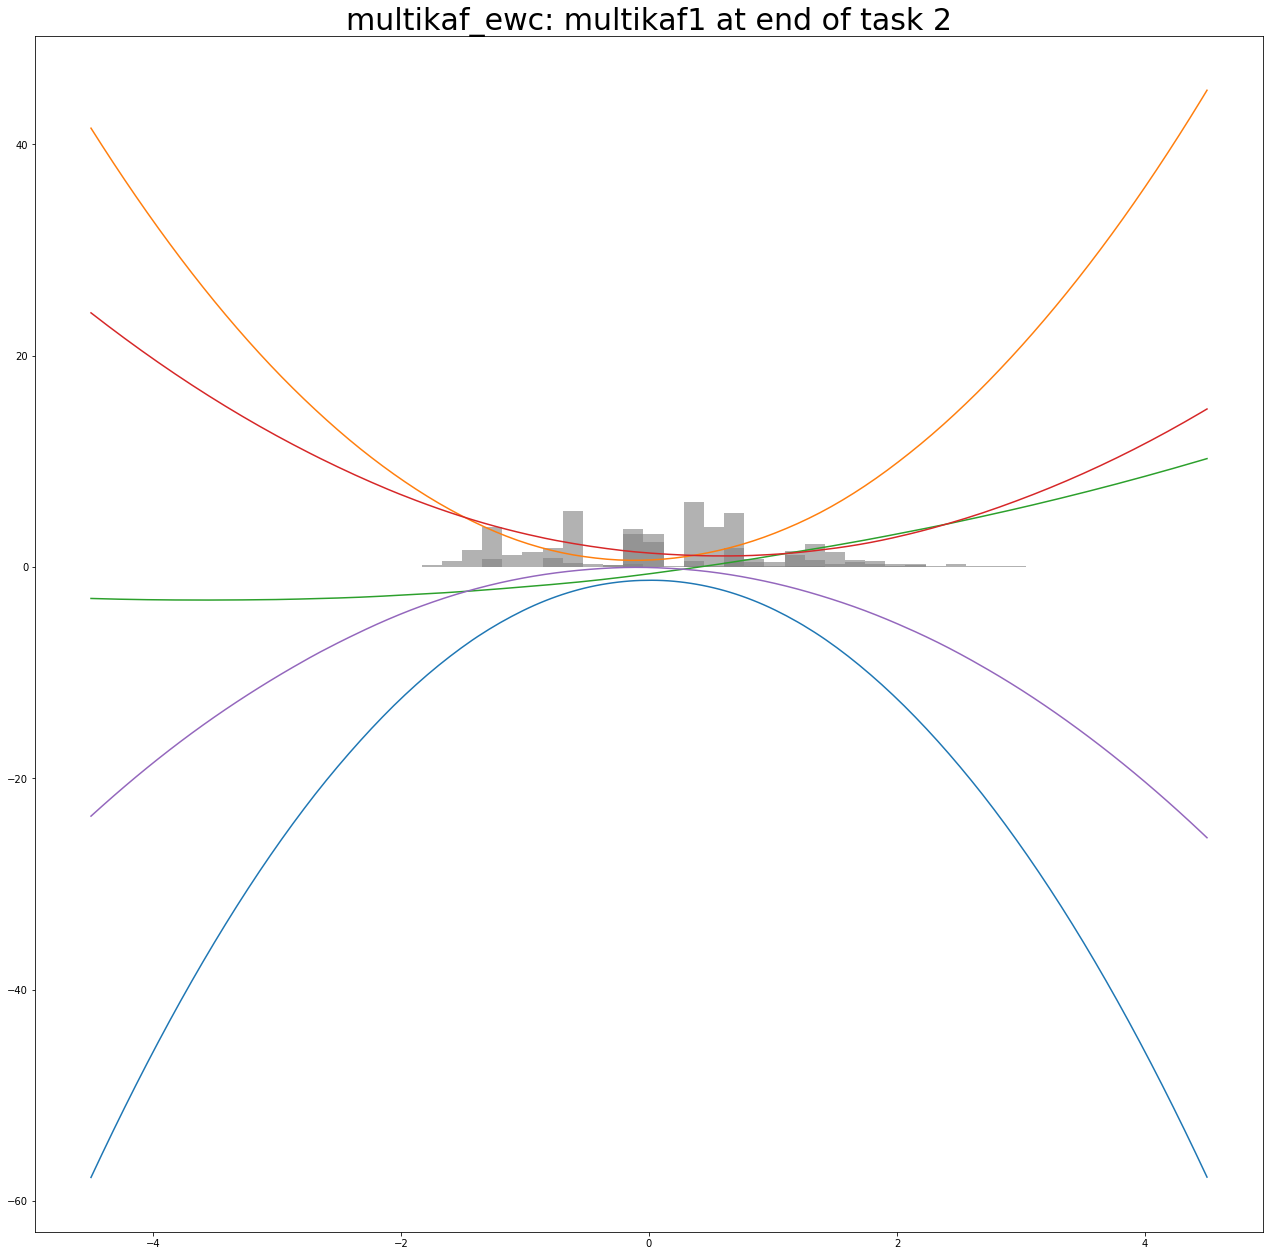

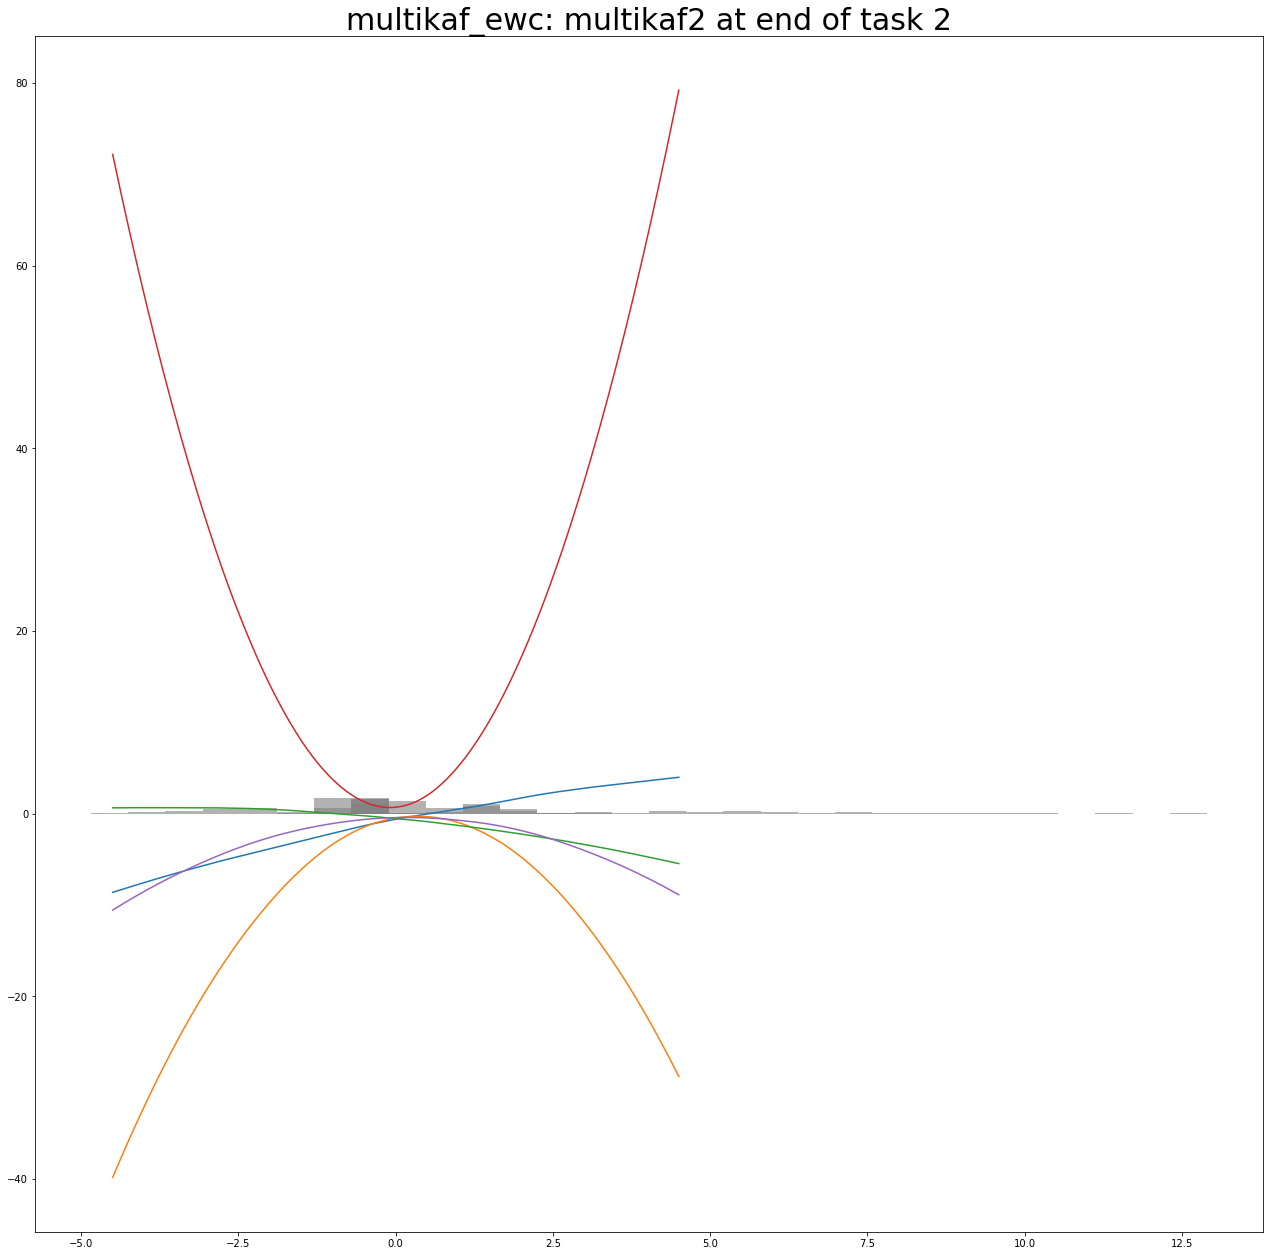

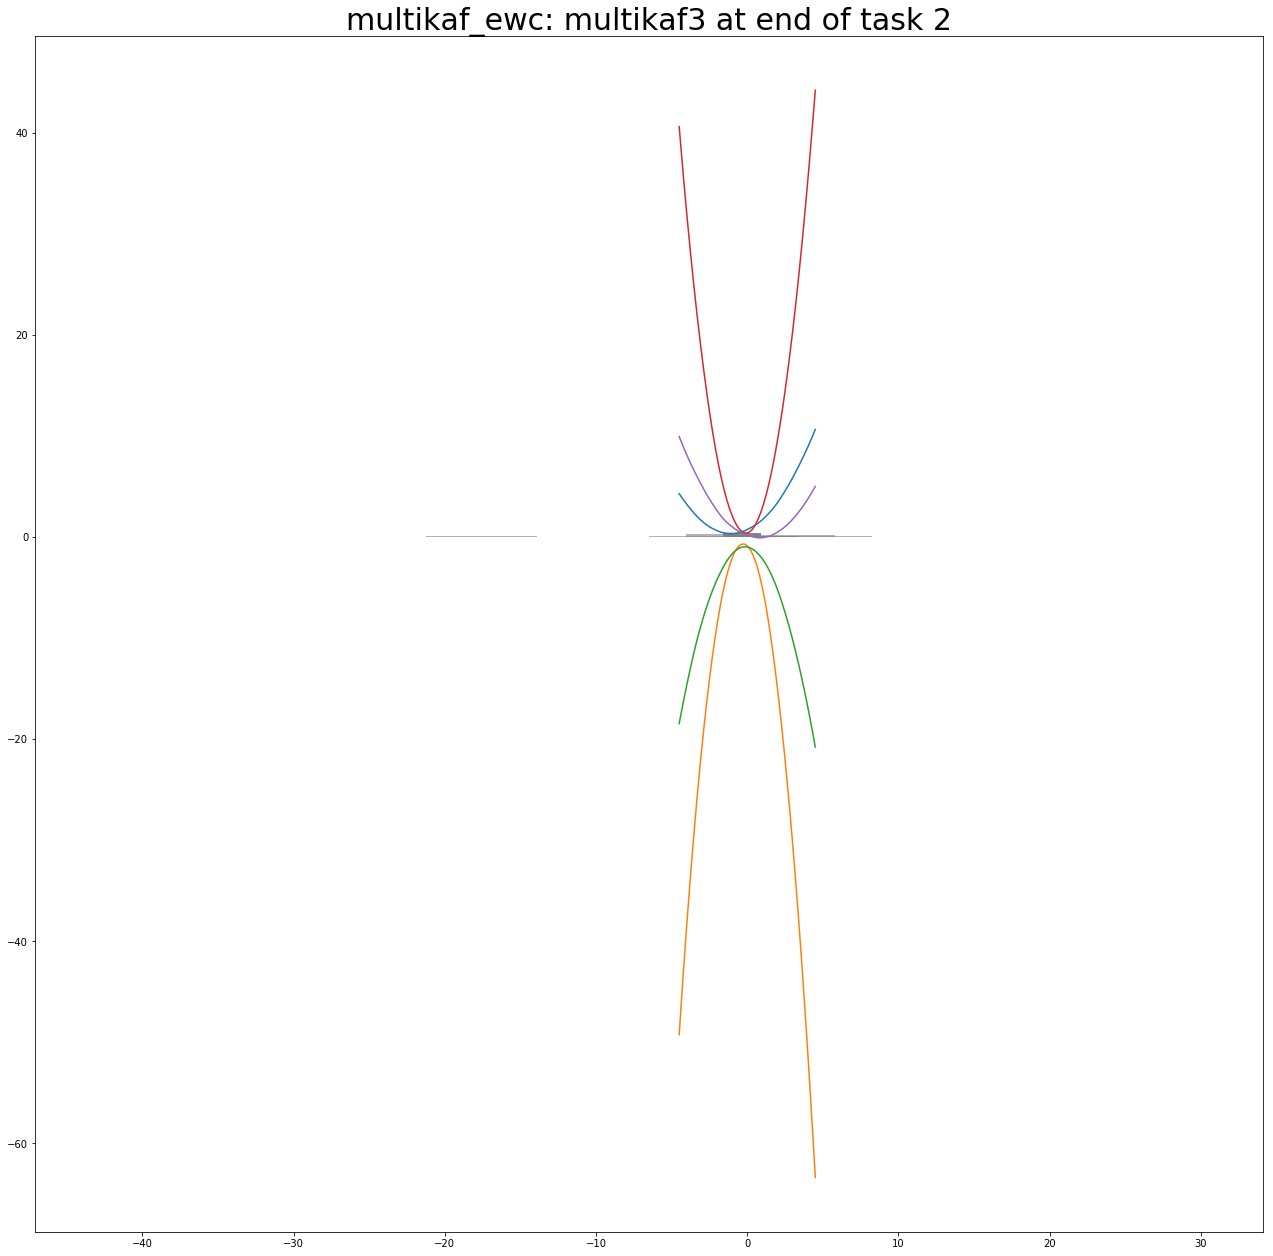

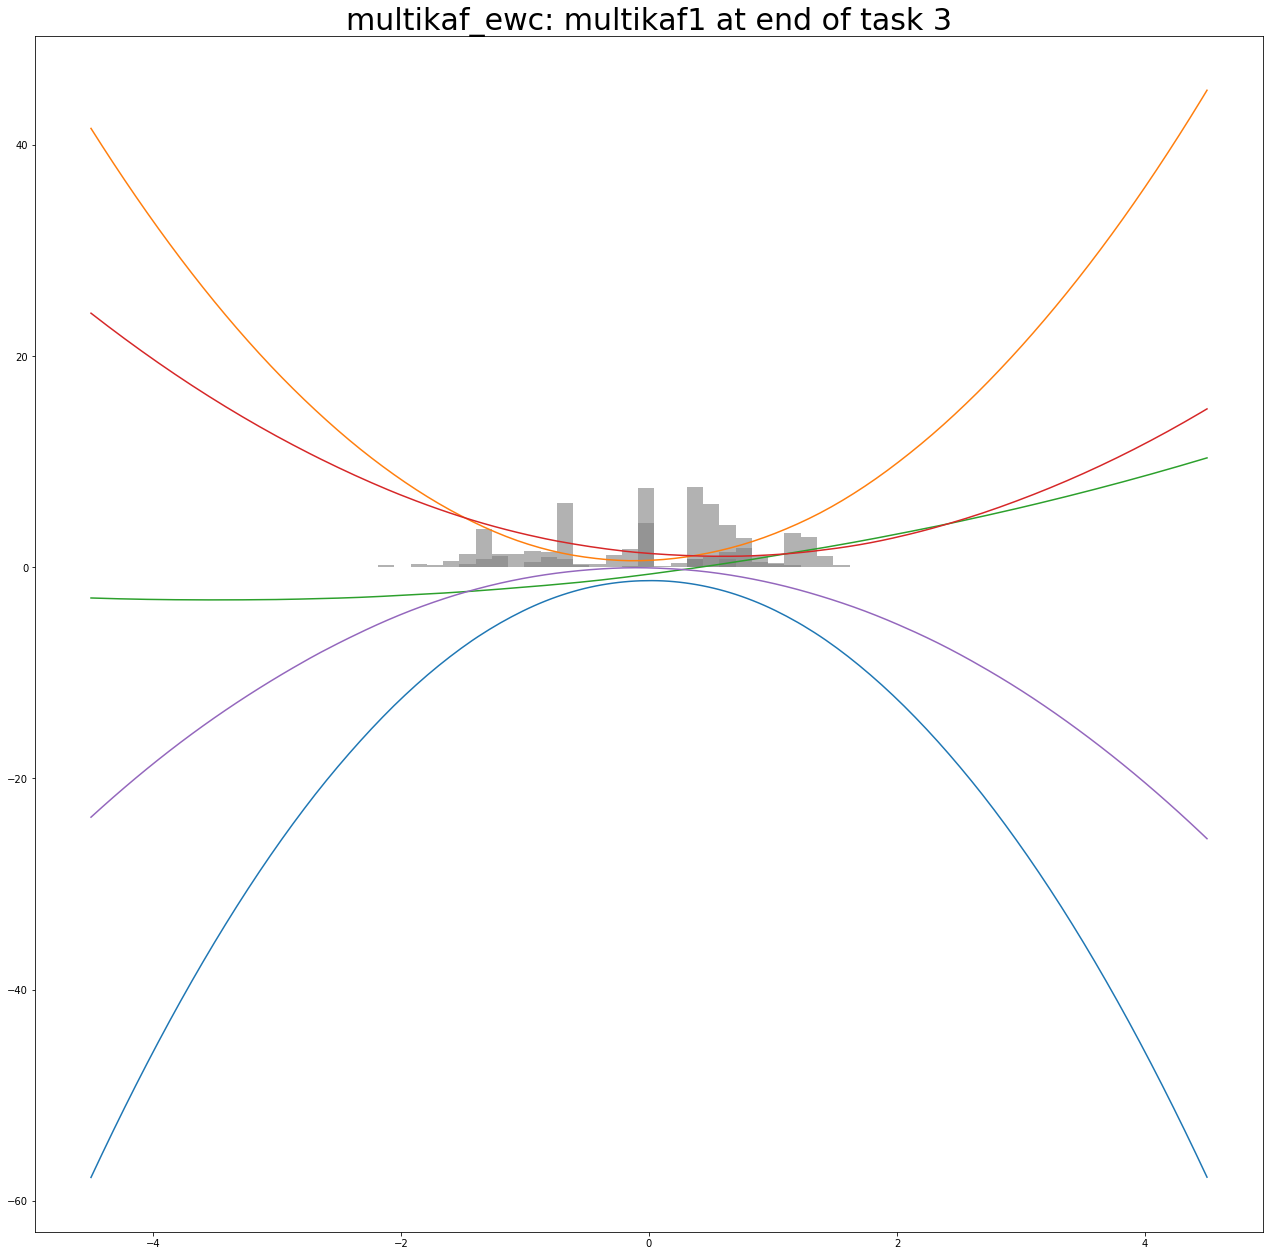

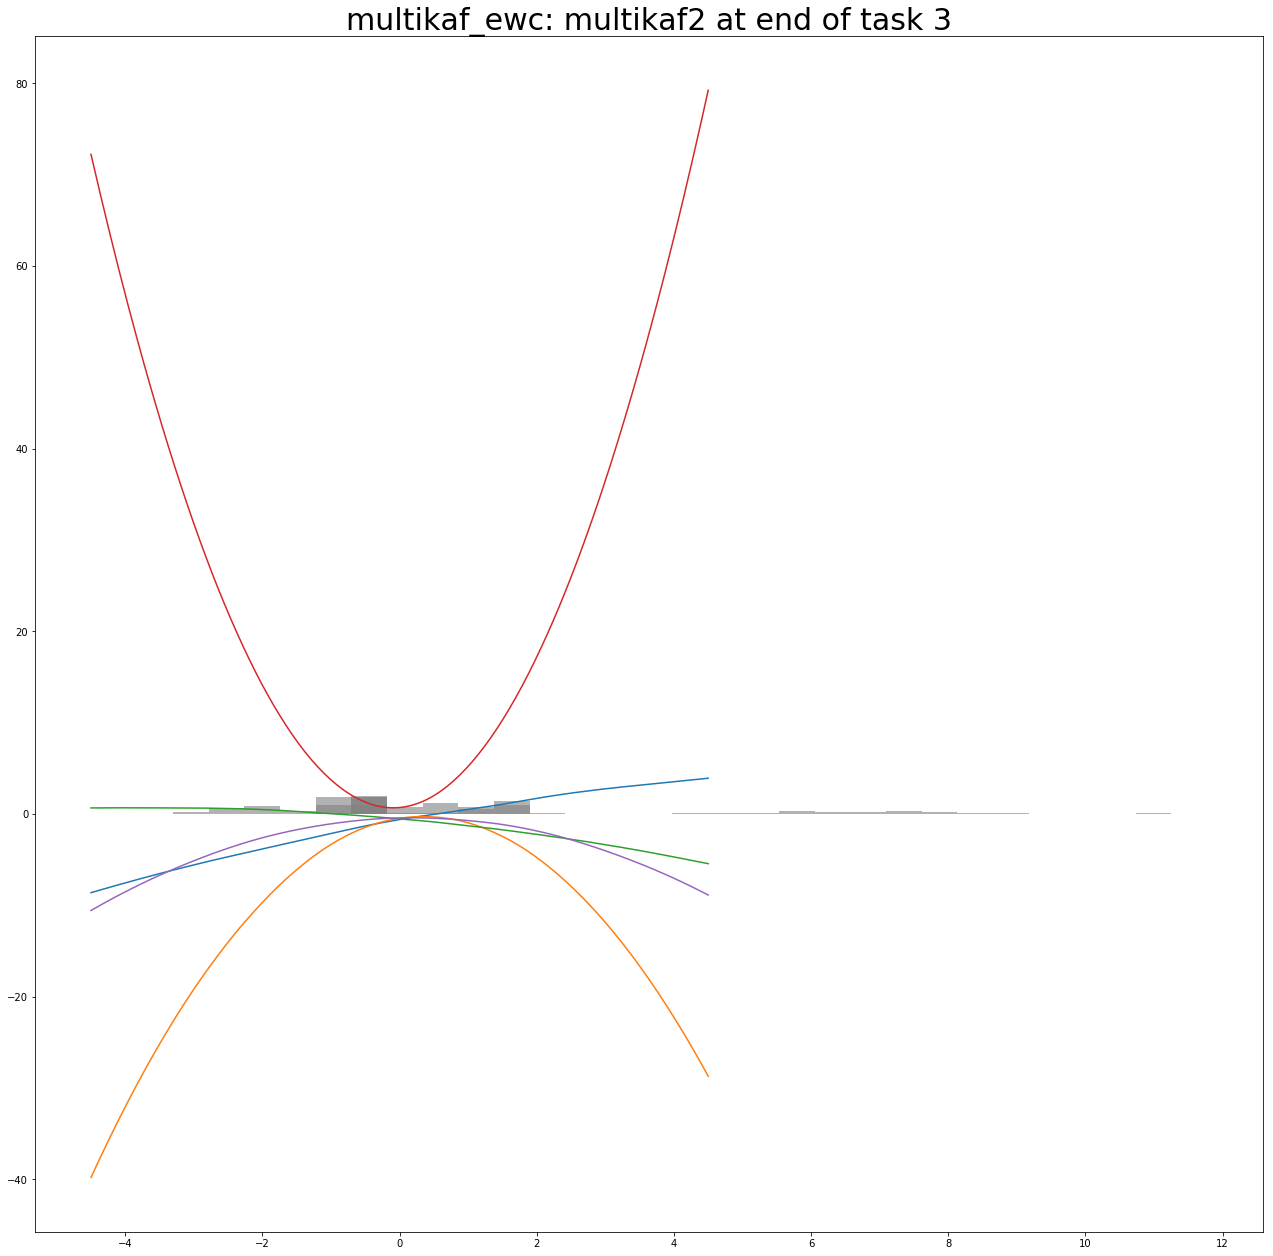

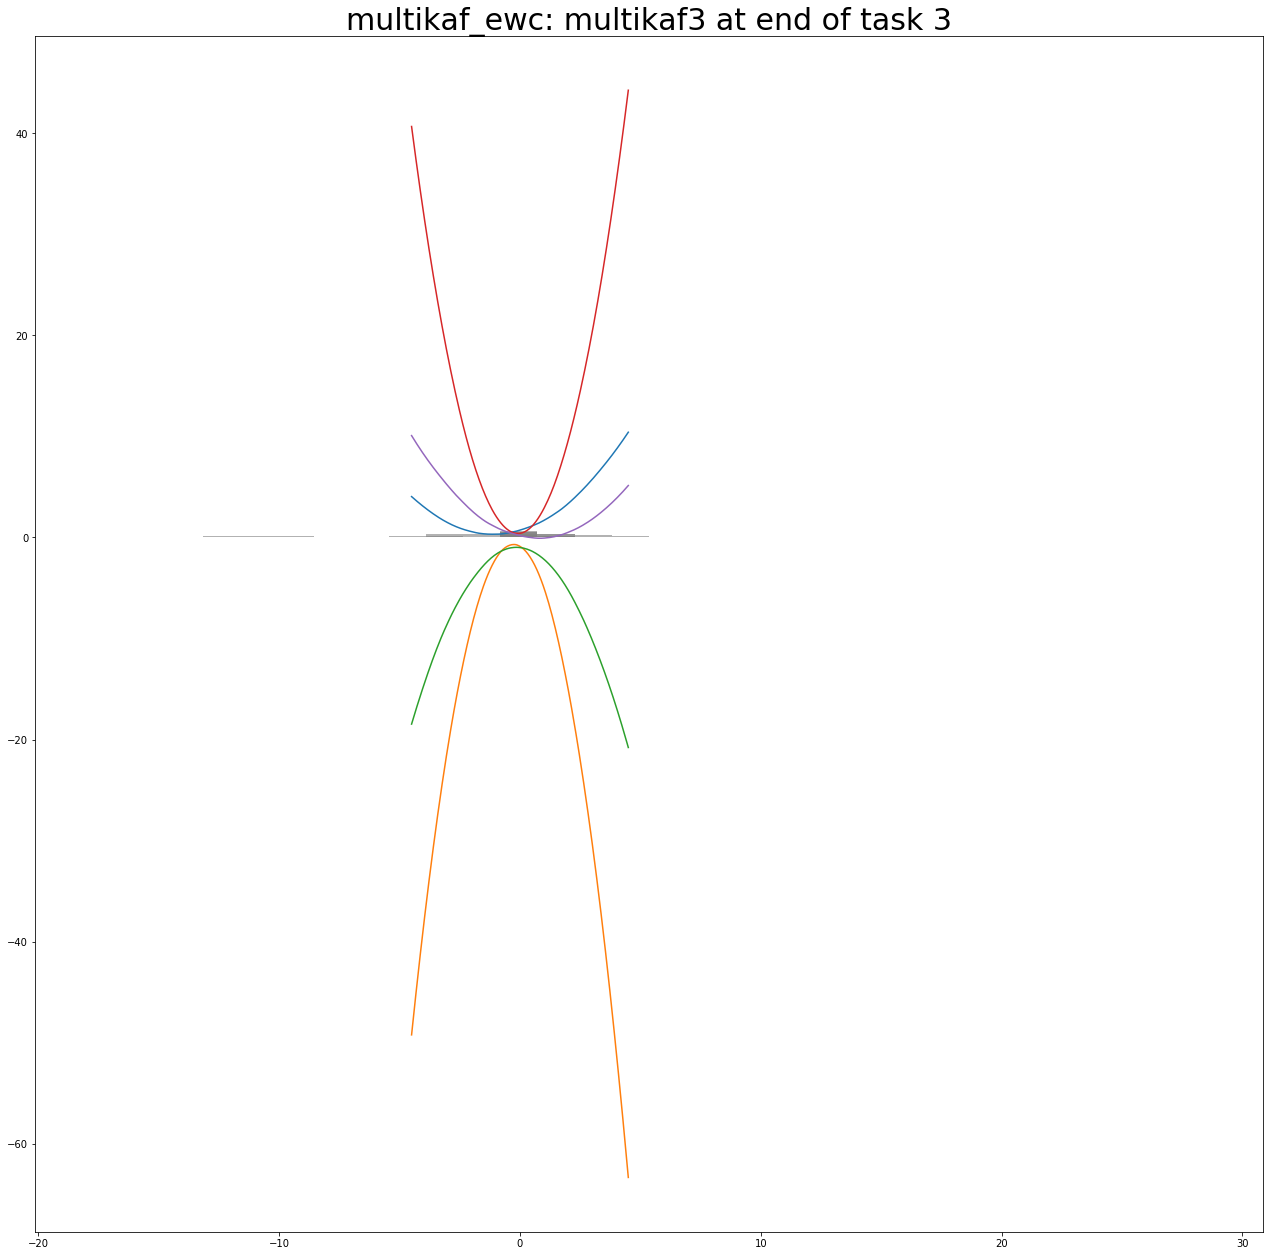

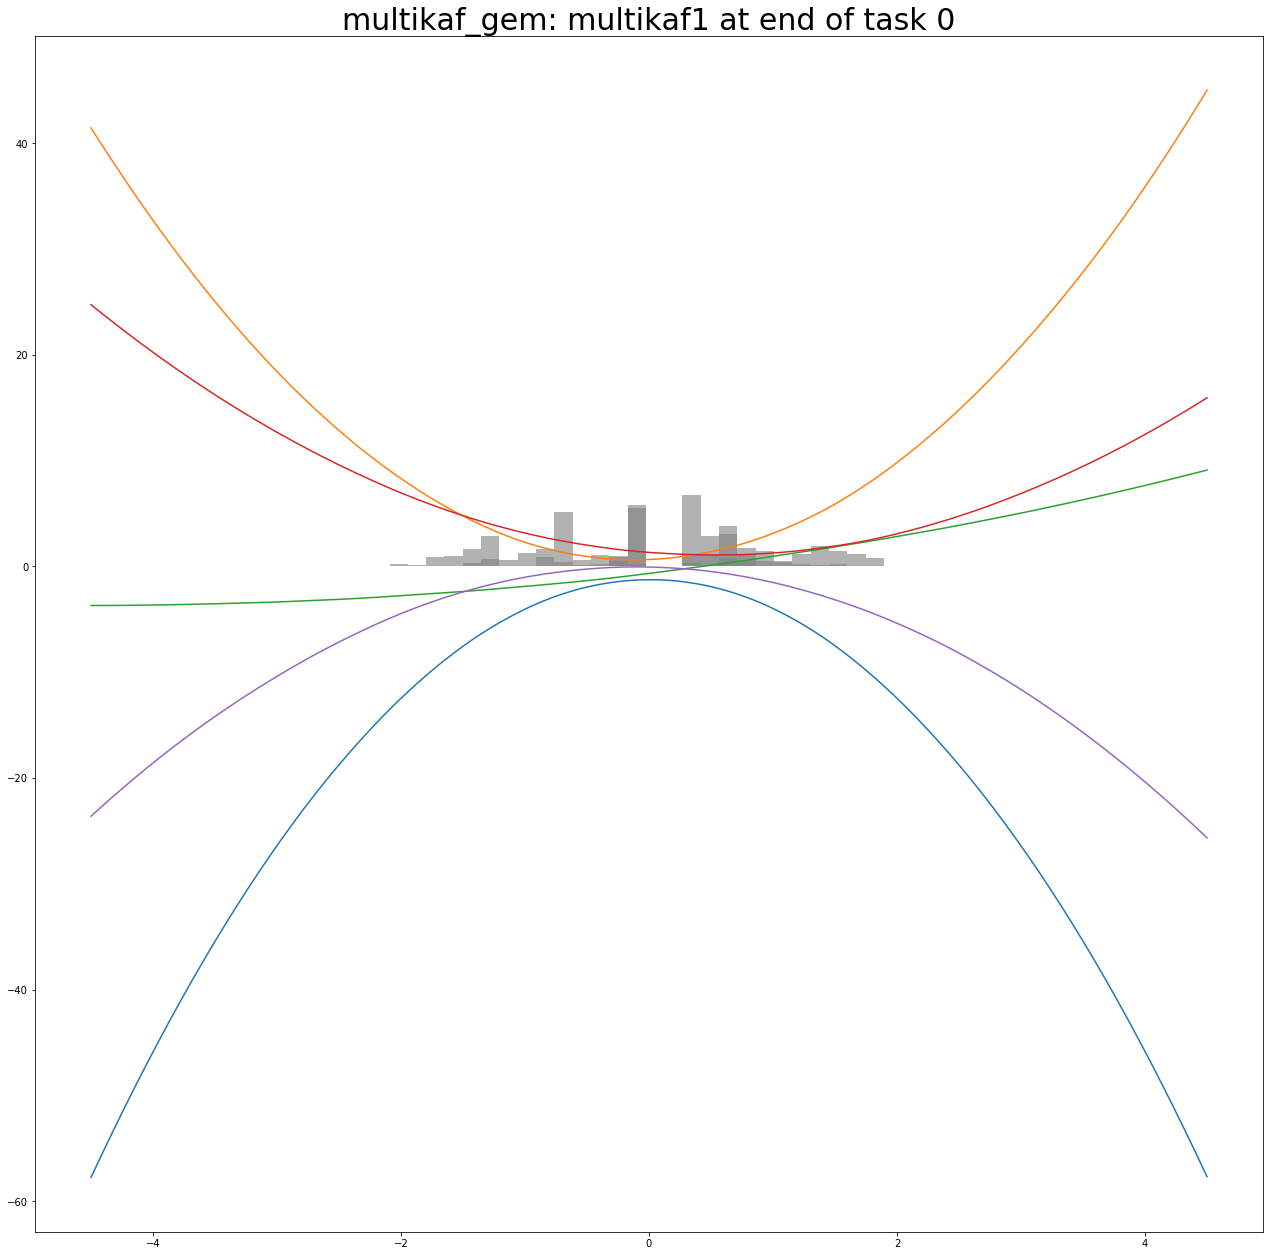

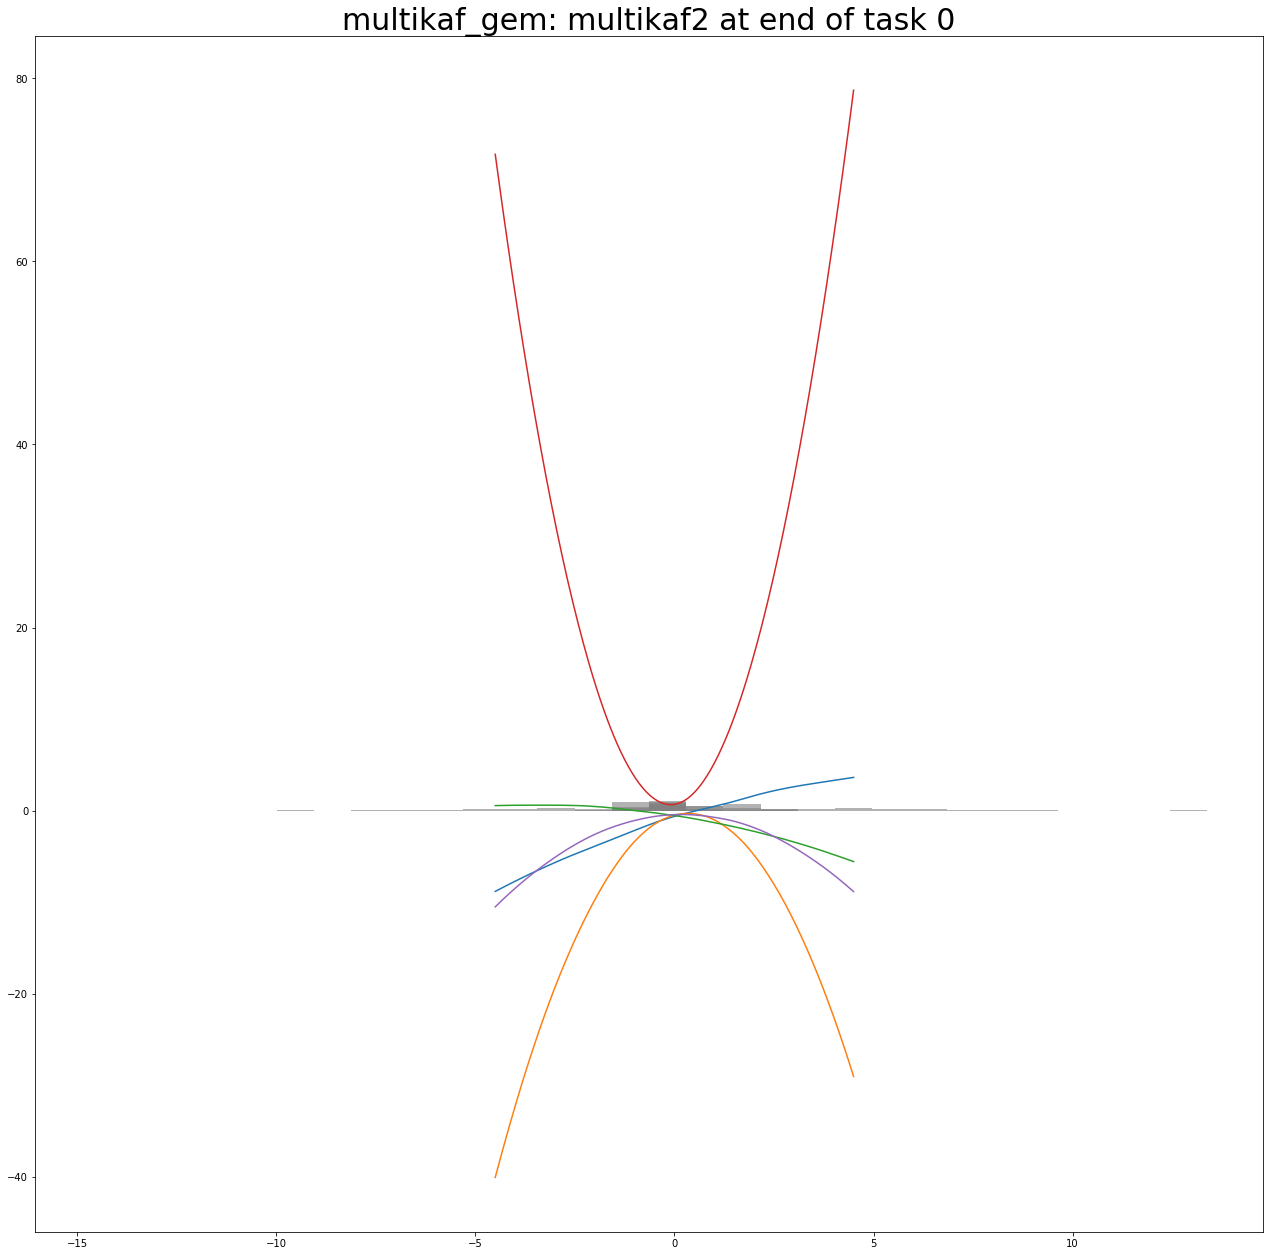

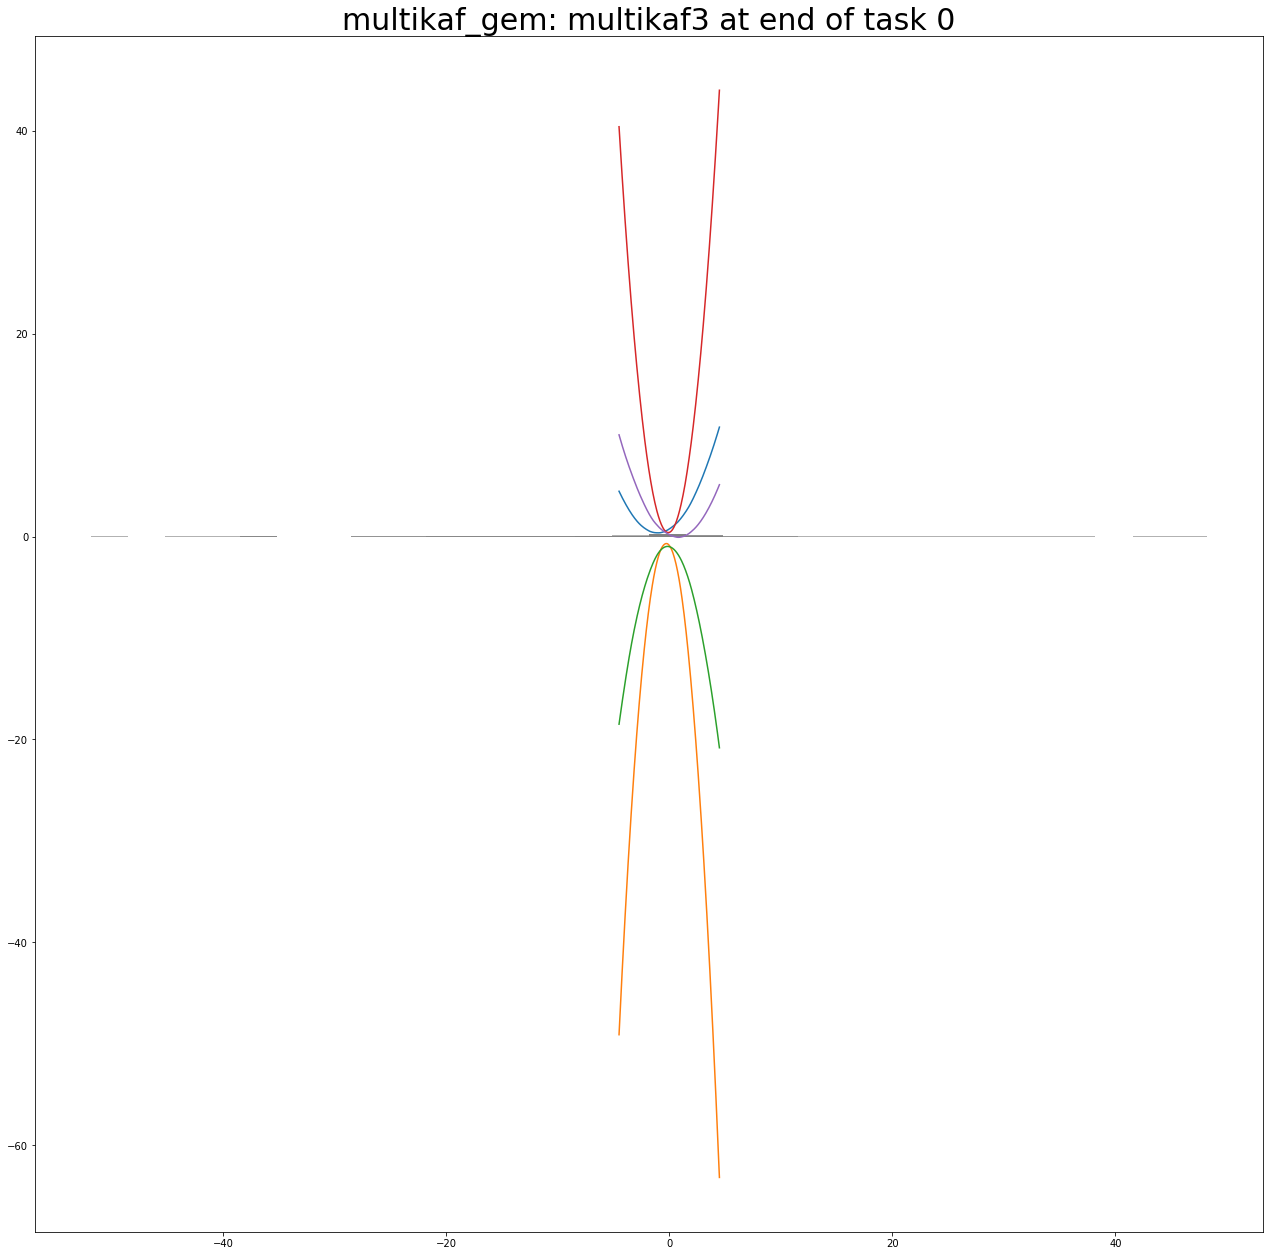

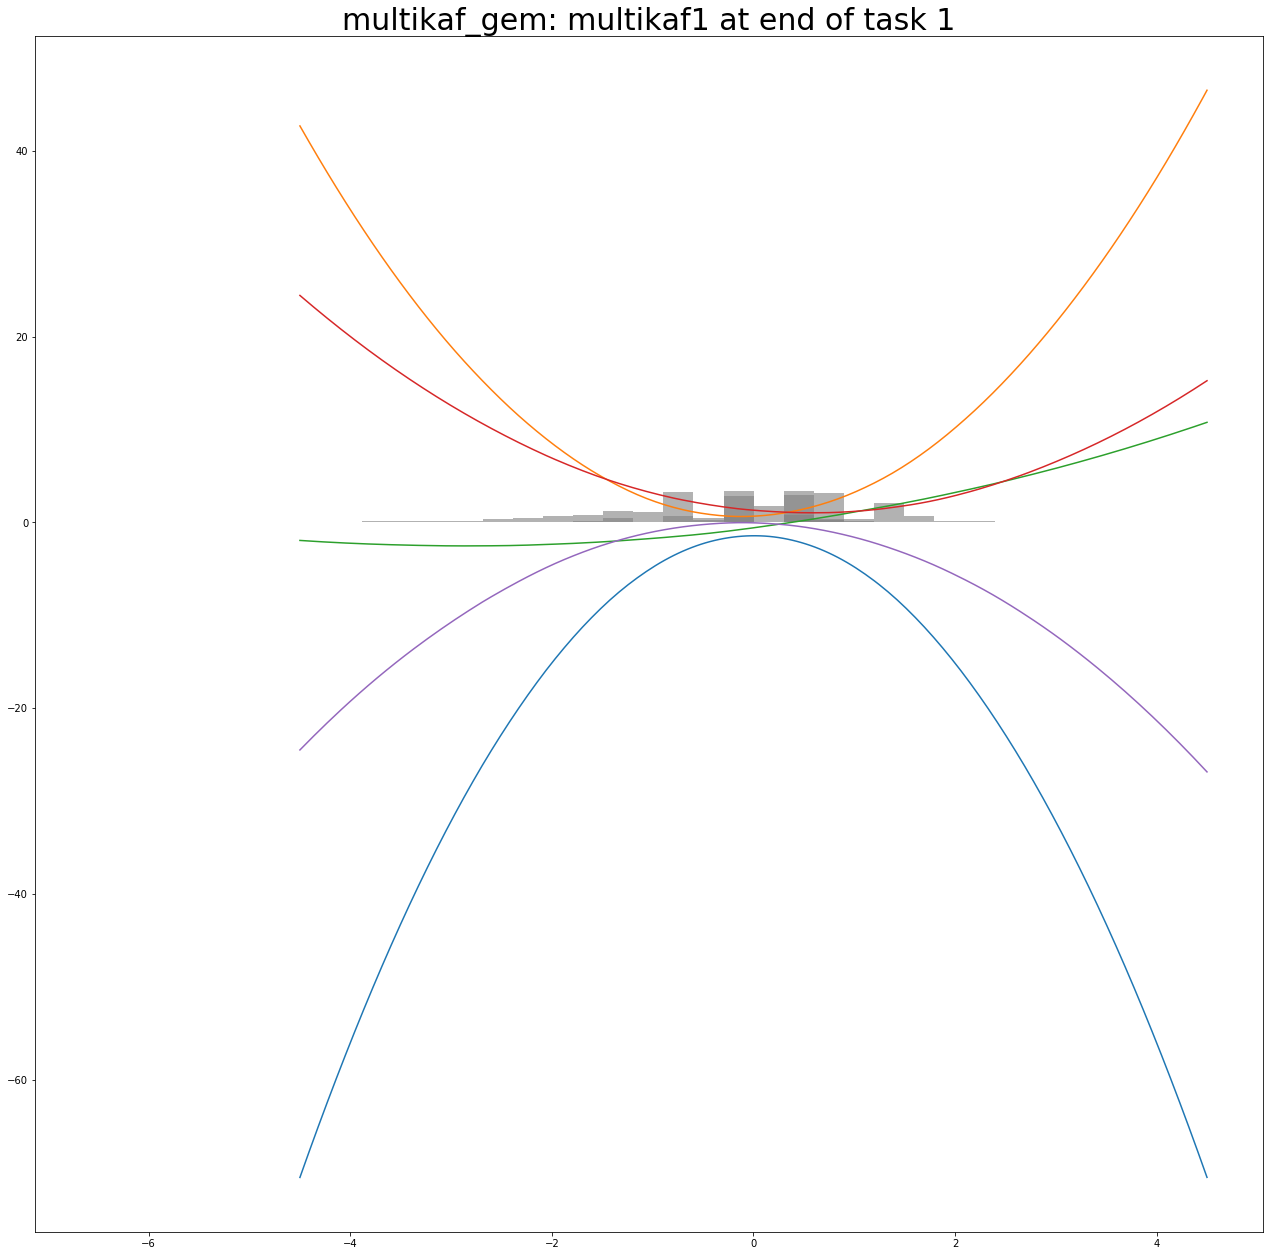

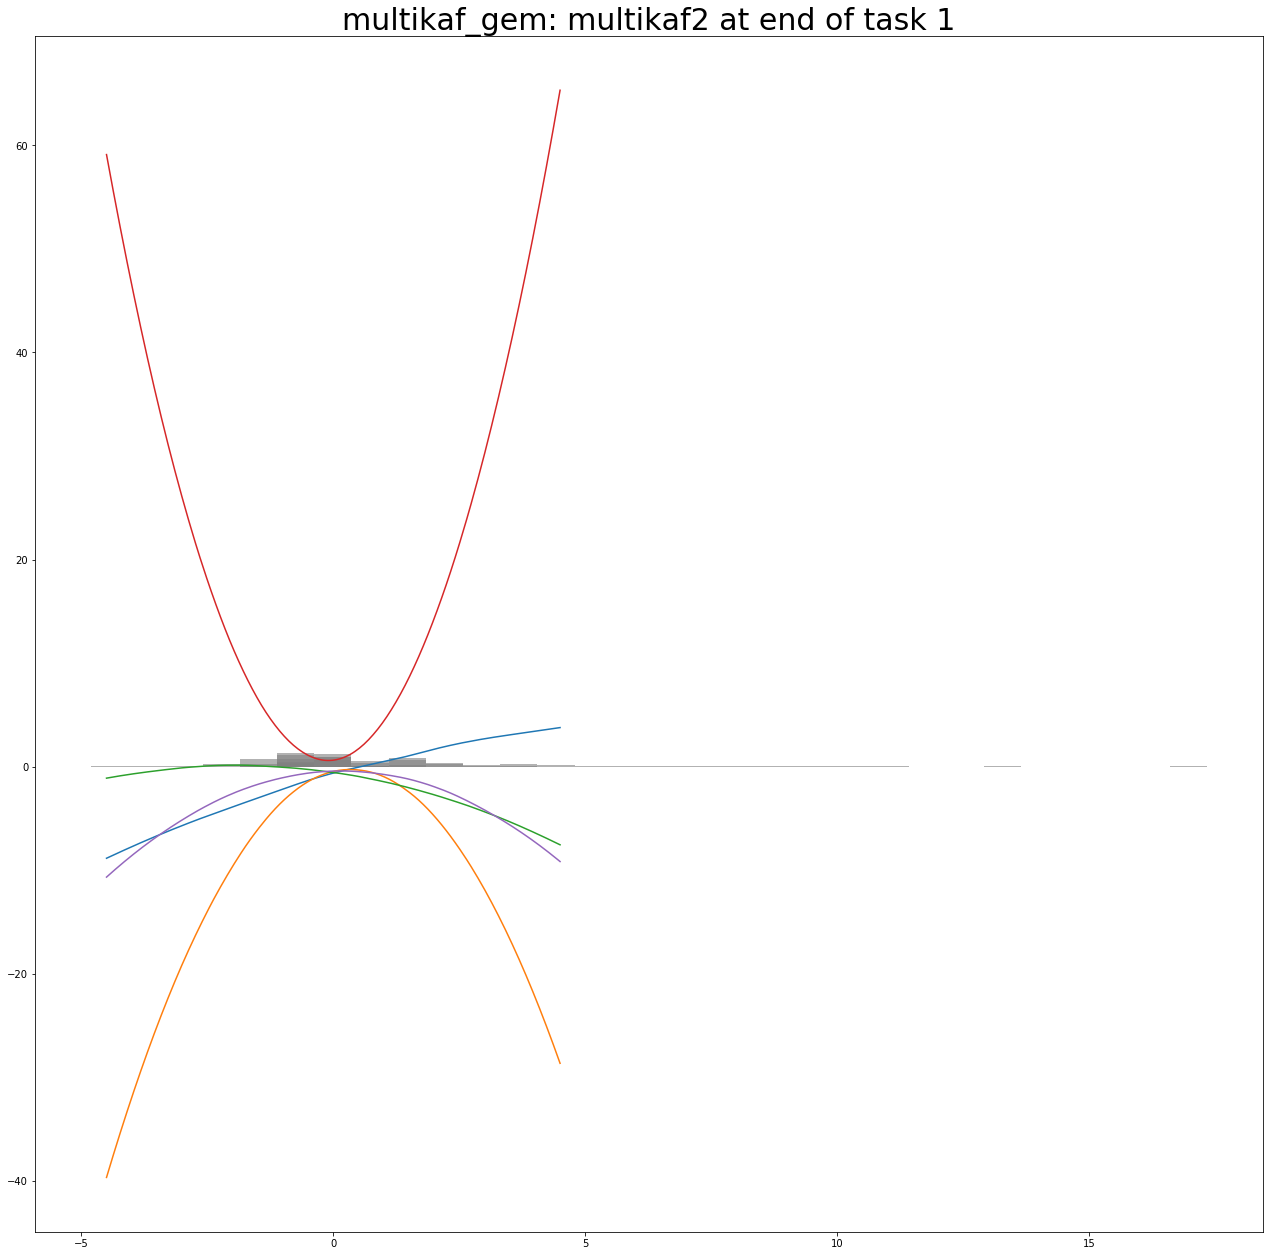

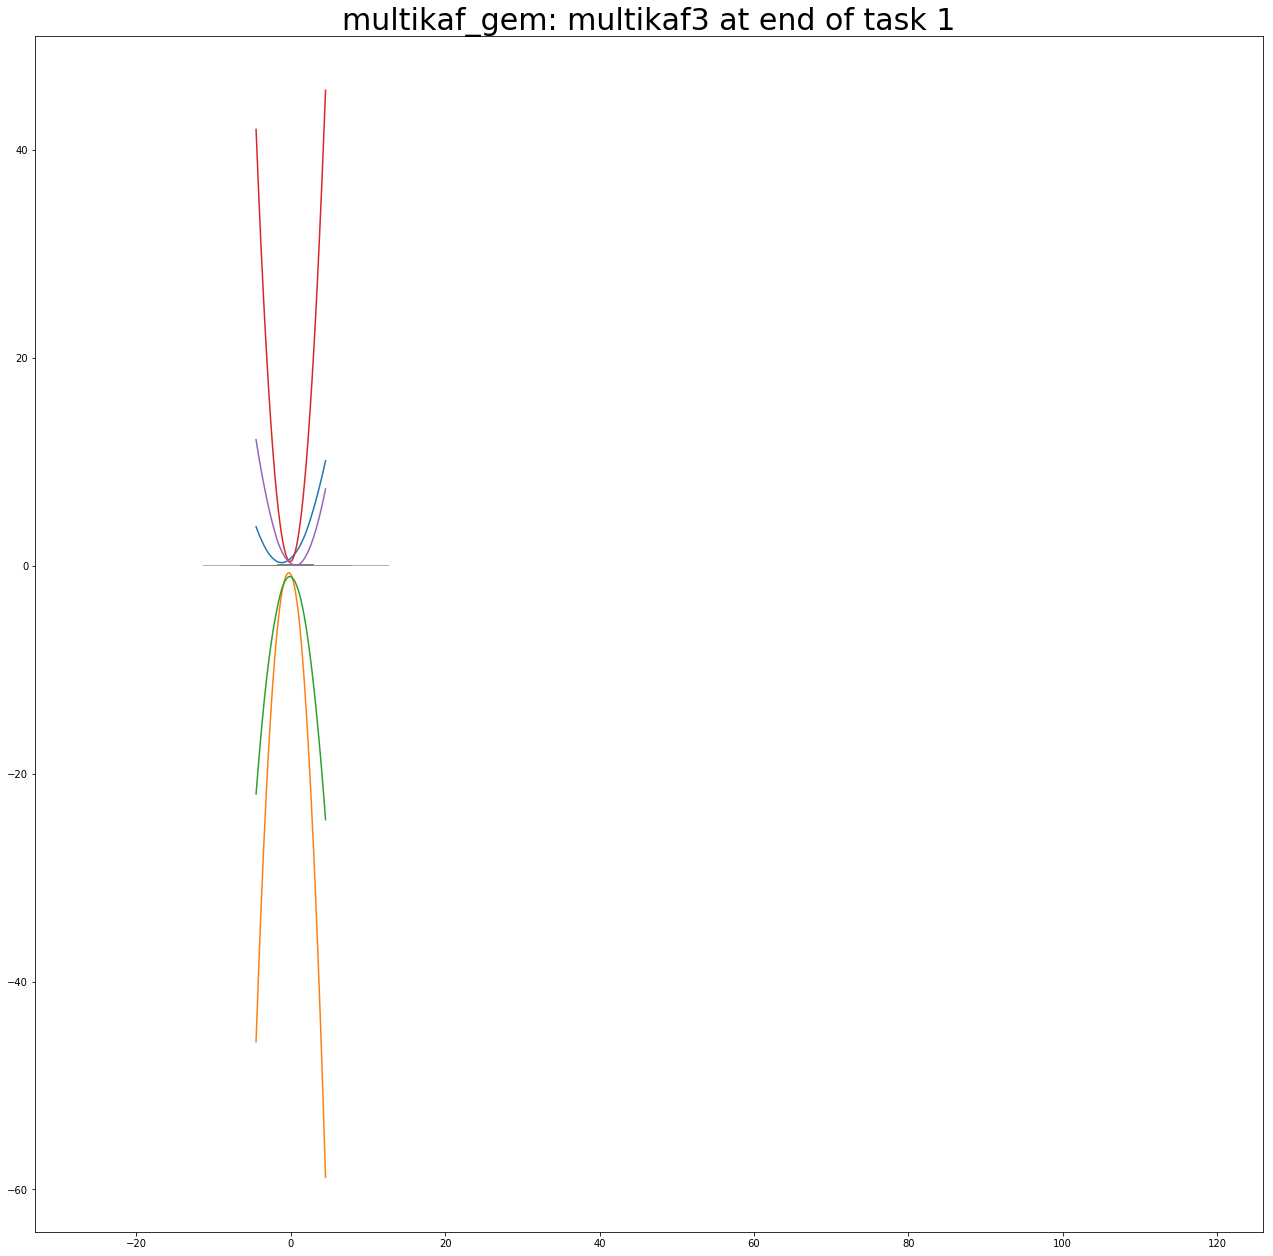

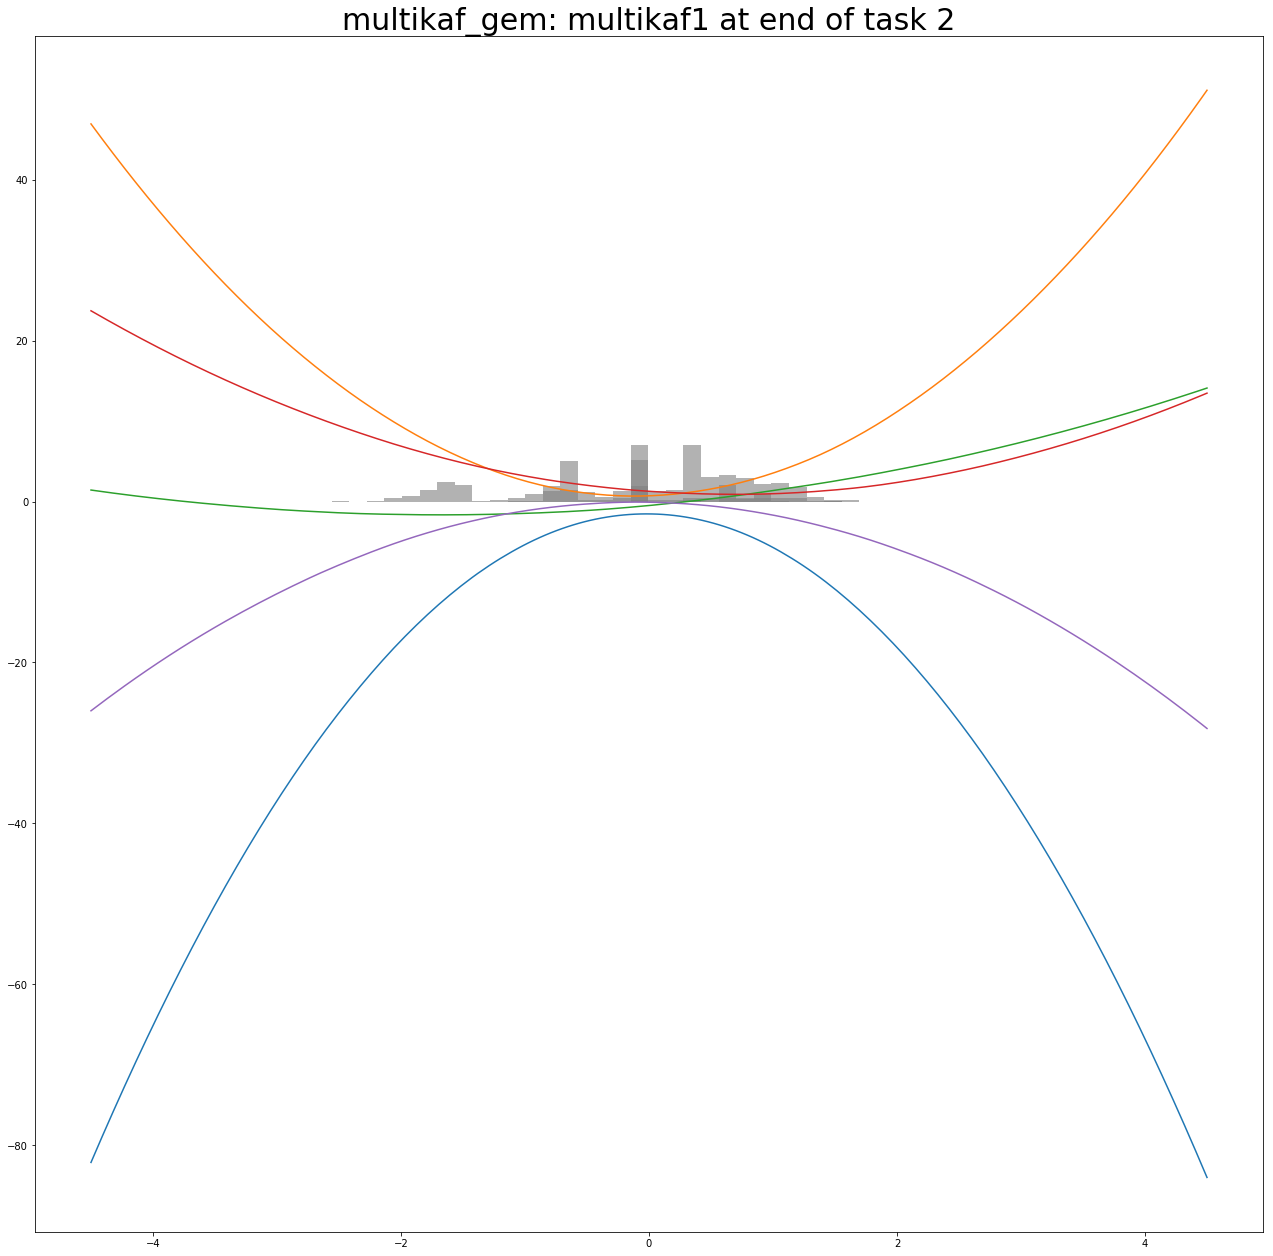

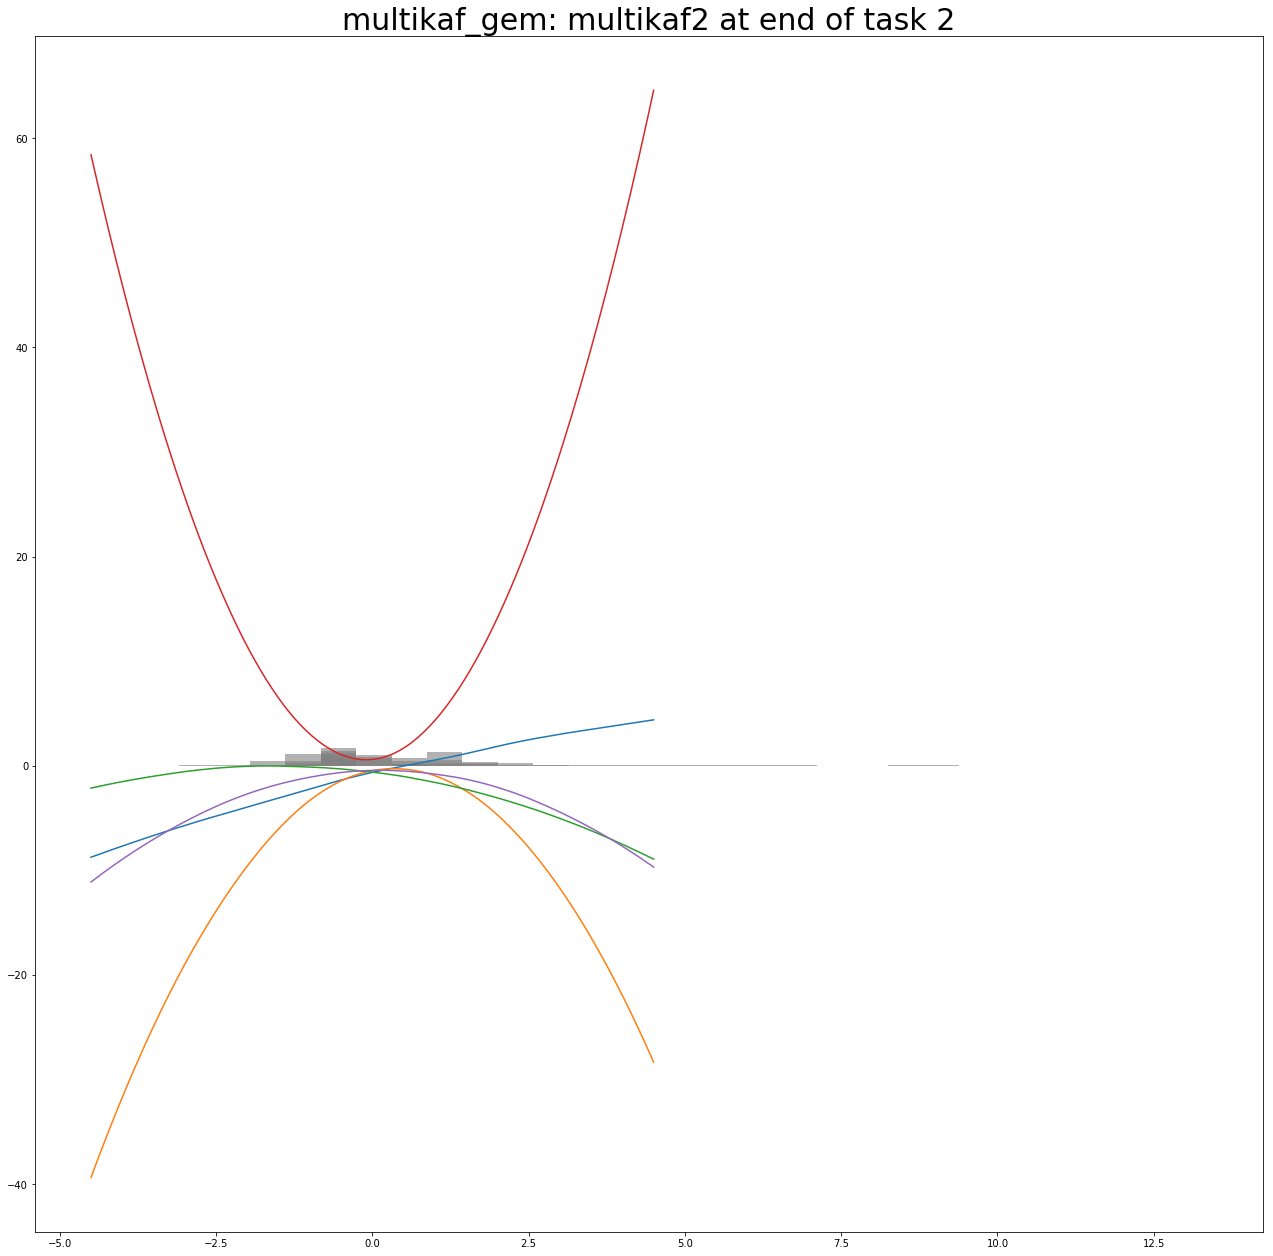

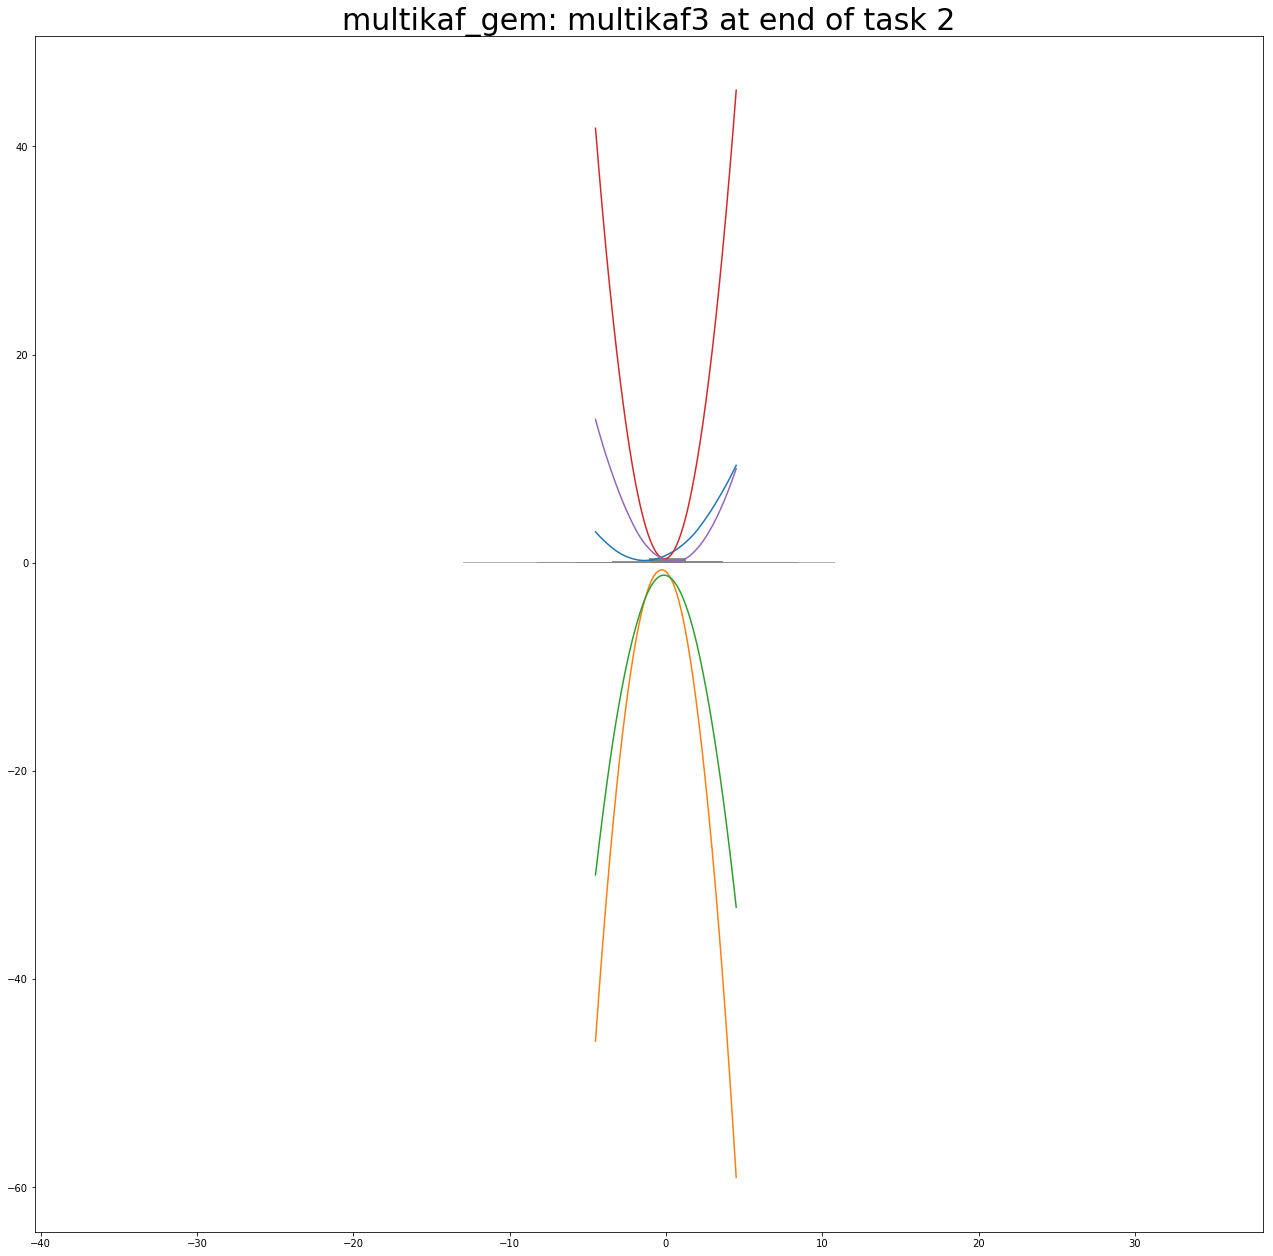

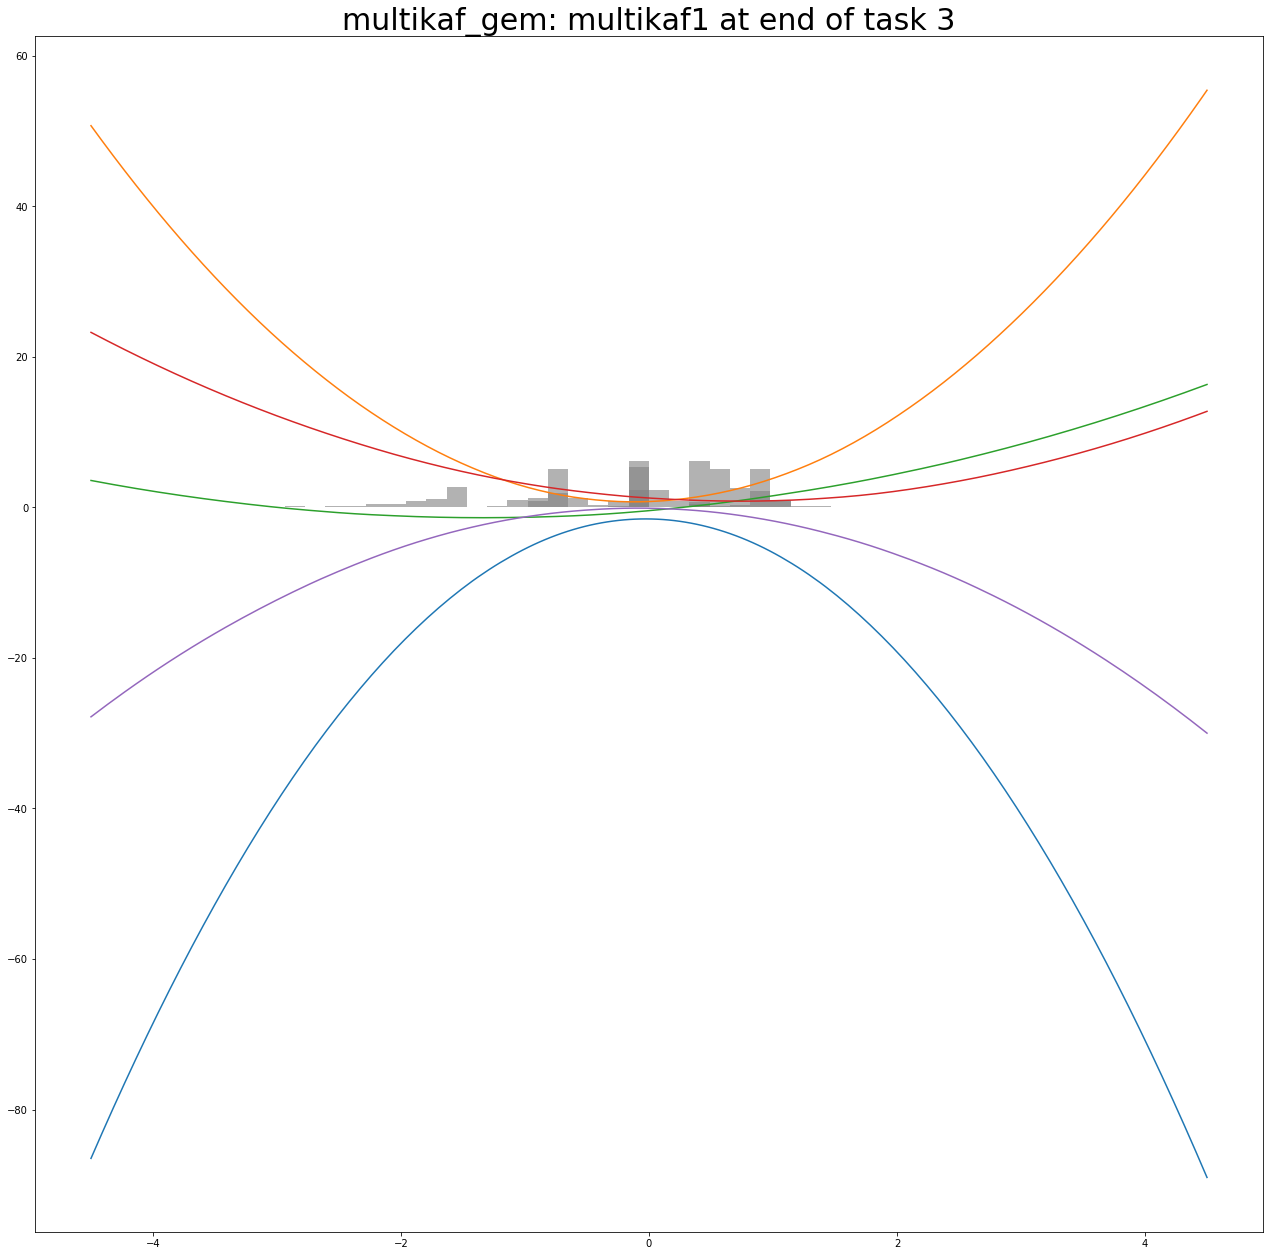

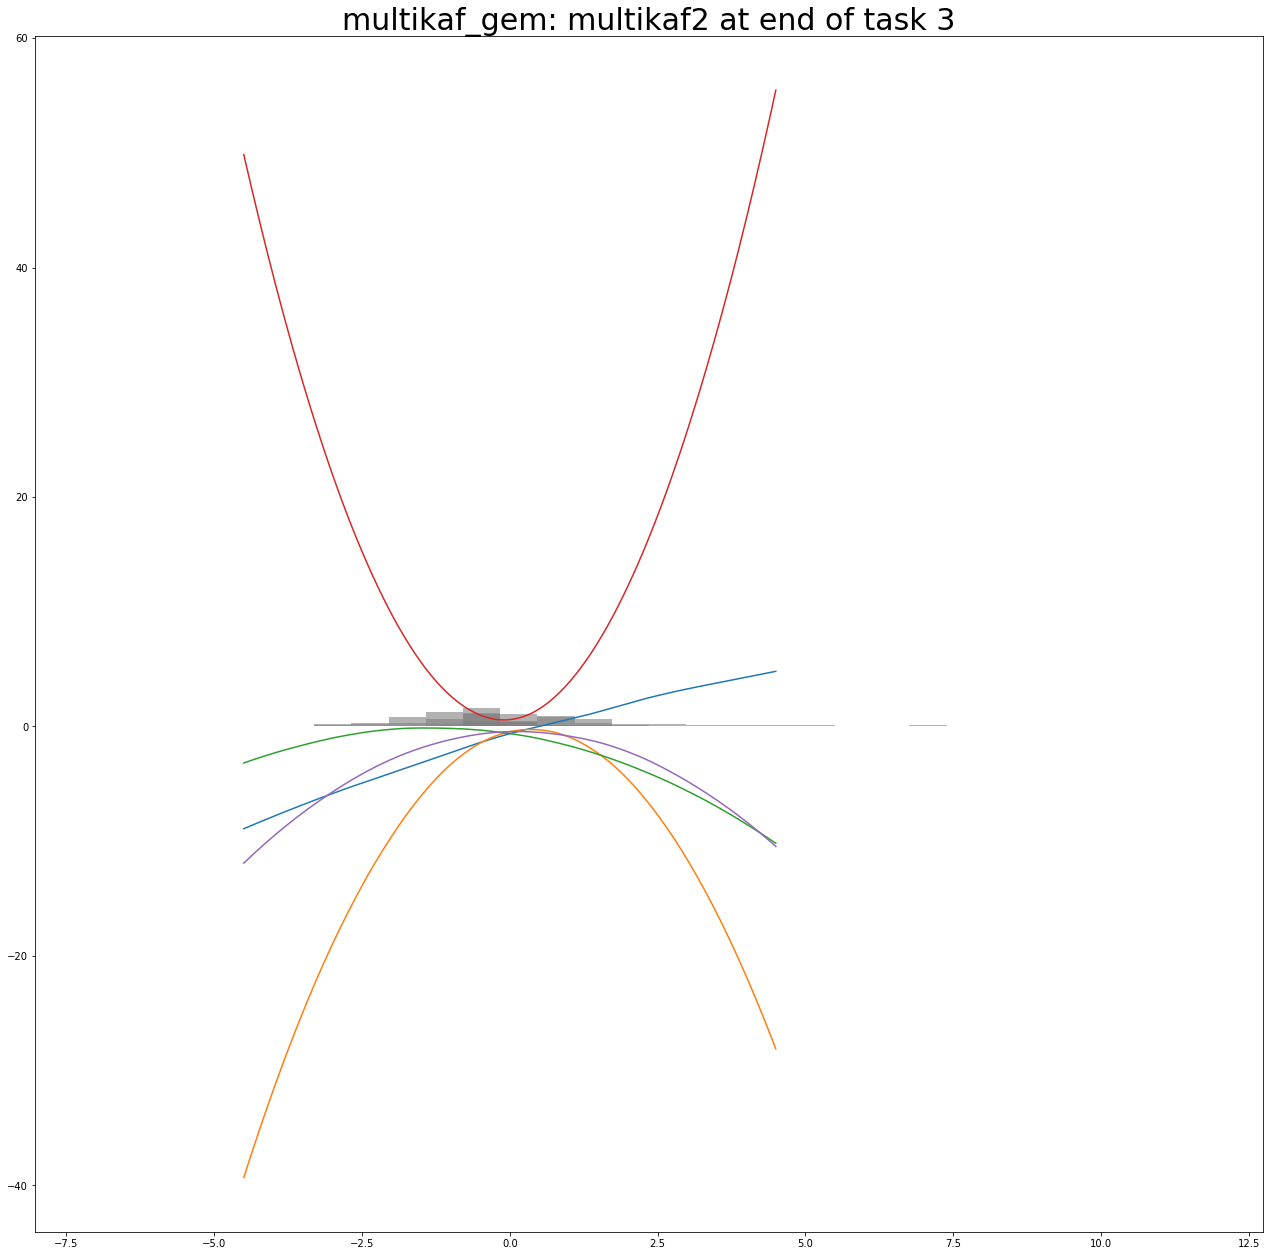

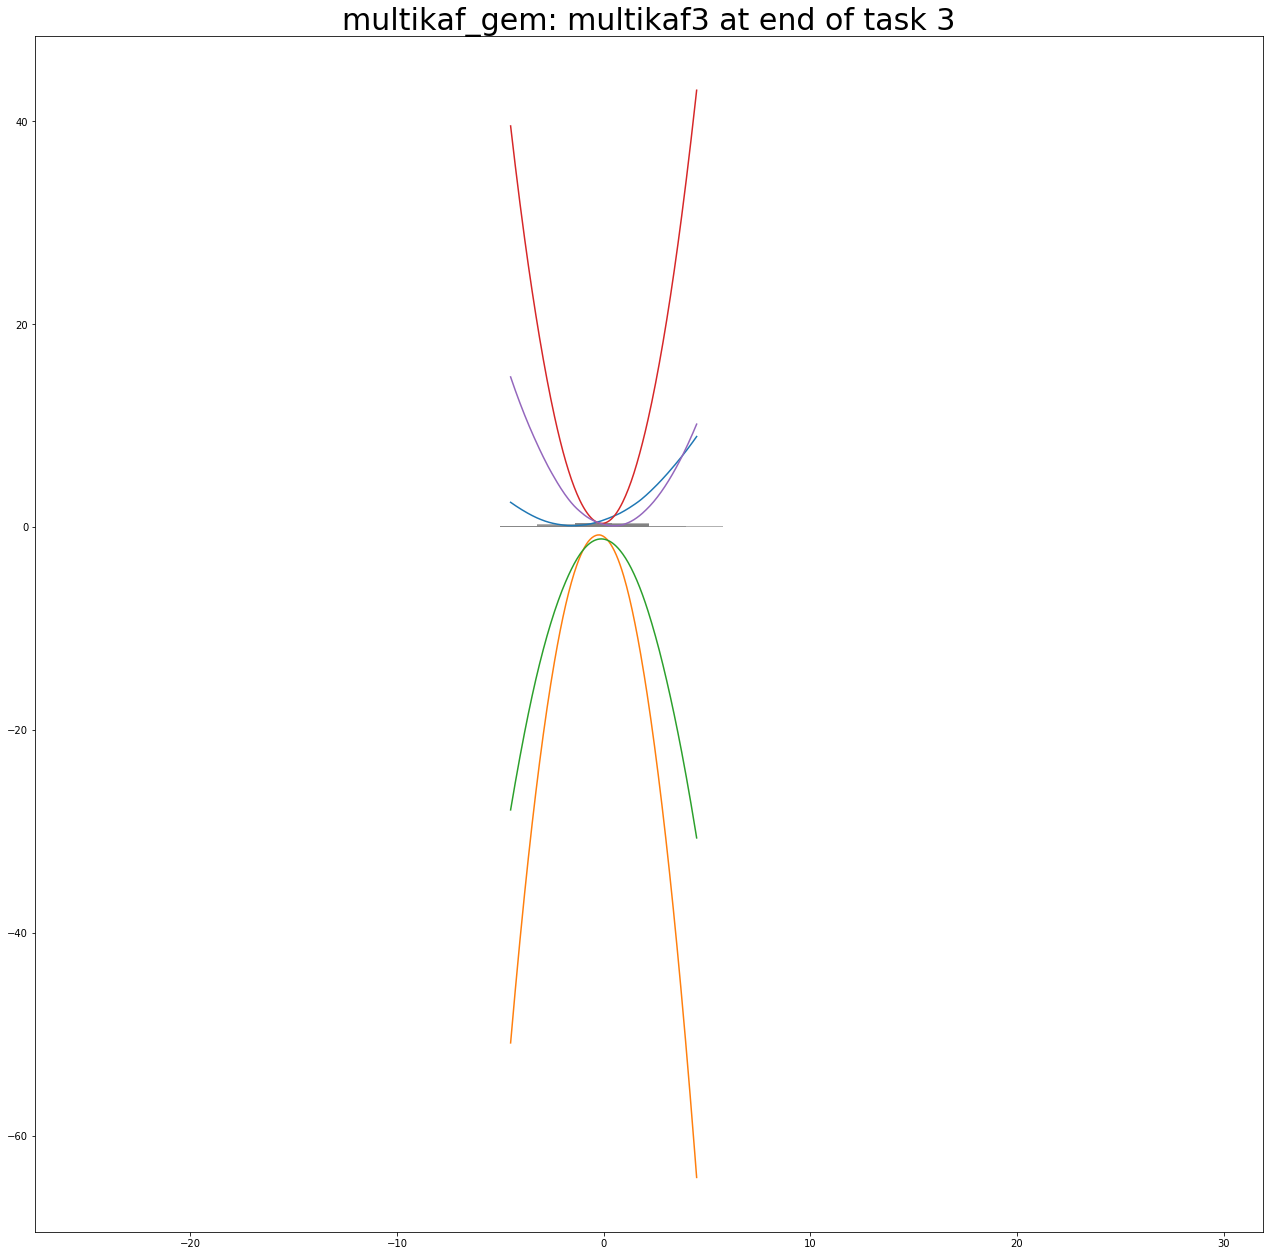

In [13]:
neurons = np.random.randint(low=1, high=int(400*0.7), size=10) 
from scipy.interpolate import make_interp_spline, BSpline

def hook(module, input, output):
    setattr(module, "_value_hook", output)

x = list(range(20))
common_params = {'histtype': 'step'}

# fig = plt.figure(figsize=(22, 22))
# ax = fig.add_subplot(111, projection='3d')

x_labels = []
space = np.linspace(-4.5, 4.5, 100)

for exp_name, _ in experiments_multikaf:
    for i in np.arange(4):

        n = deepcopy(multikaf)
        config = deepcopy(configOnline)

        config.MODEL_NAME = exp_name

        trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

        r = trainer.load(i)
        model = trainer.model.cpu()

        for _, m in model.named_modules():
            m.register_forward_hook(hook)

        dataset.task = i
        it = dataset.getIterator(1)

        imgs = []
        for _ in range(100):
            imgs.append(torch.Tensor(next(it)[0]))

        for l in [1, 2, 3]:
            name = 'kaf'+str(l)

            kaf = getattr(model, name)
            c = []

            for img in imgs:
                model(img)
                hooked_val = getattr(kaf, '_value_hook')[0].detach().cpu().numpy()
                c.append([hooked_val[n] for n in neurons])

            fig = plt.figure(figsize=(22, 22))
            ax = fig.add_subplot(111)
            ax.hist(x=np.asarray(c), histtype='stepfilled', density=True, alpha=0.6, color = ["grey"]*10, bins=30)
            ax.set_title('{}: multi{} at end of task {}'.format(exp_name,name, i), fontdict={'fontsize':30})

            act_fun = []

            for j in space.astype(np.float32):
                input = torch.Tensor([j]).unsqueeze(0)
                res = kaf.forward(input).detach().cpu().numpy()[0]
                act_fun.append([res[n] for n in neurons[:5]])

            act_fun = np.asarray(act_fun)
            for j in range(act_fun.shape[1]):
                vals = act_fun[:, j]
                spl = make_interp_spline(space, vals, k=3)
                xnew = np.linspace(min(space), max(space), 200)
                ax.plot(xnew, spl(xnew))

            plt.show()


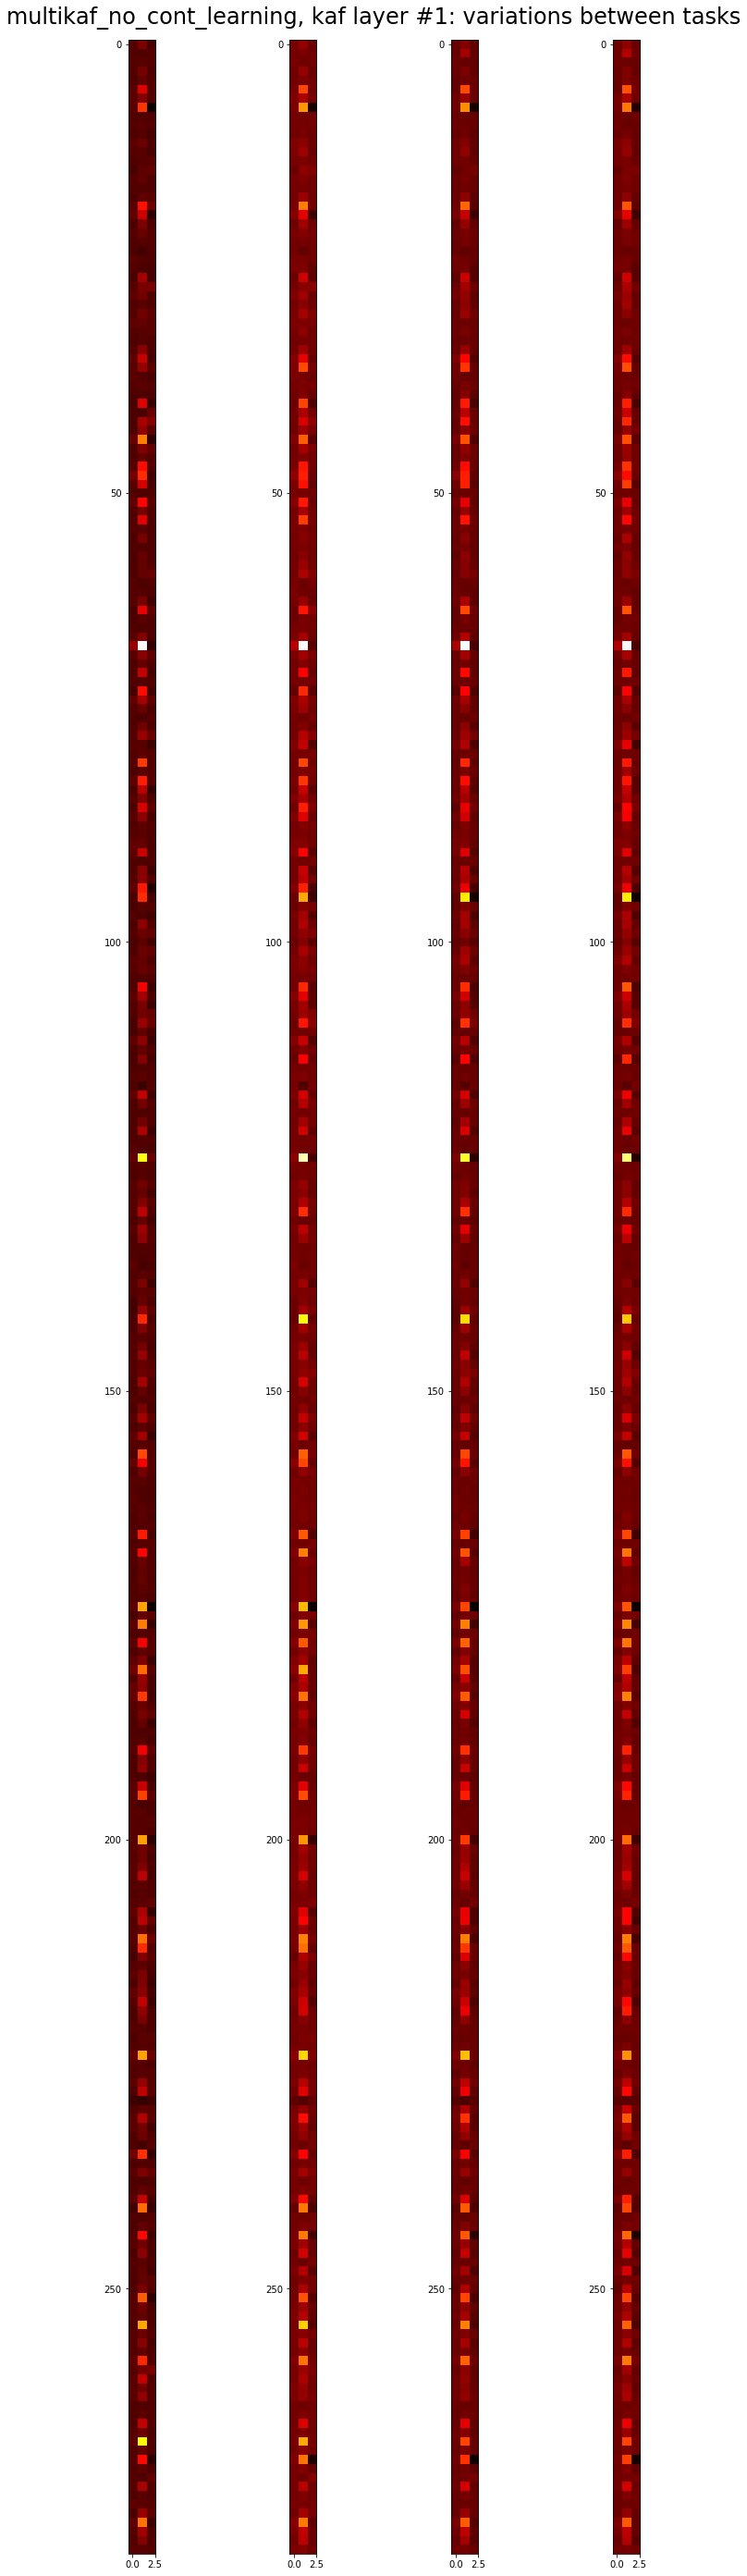

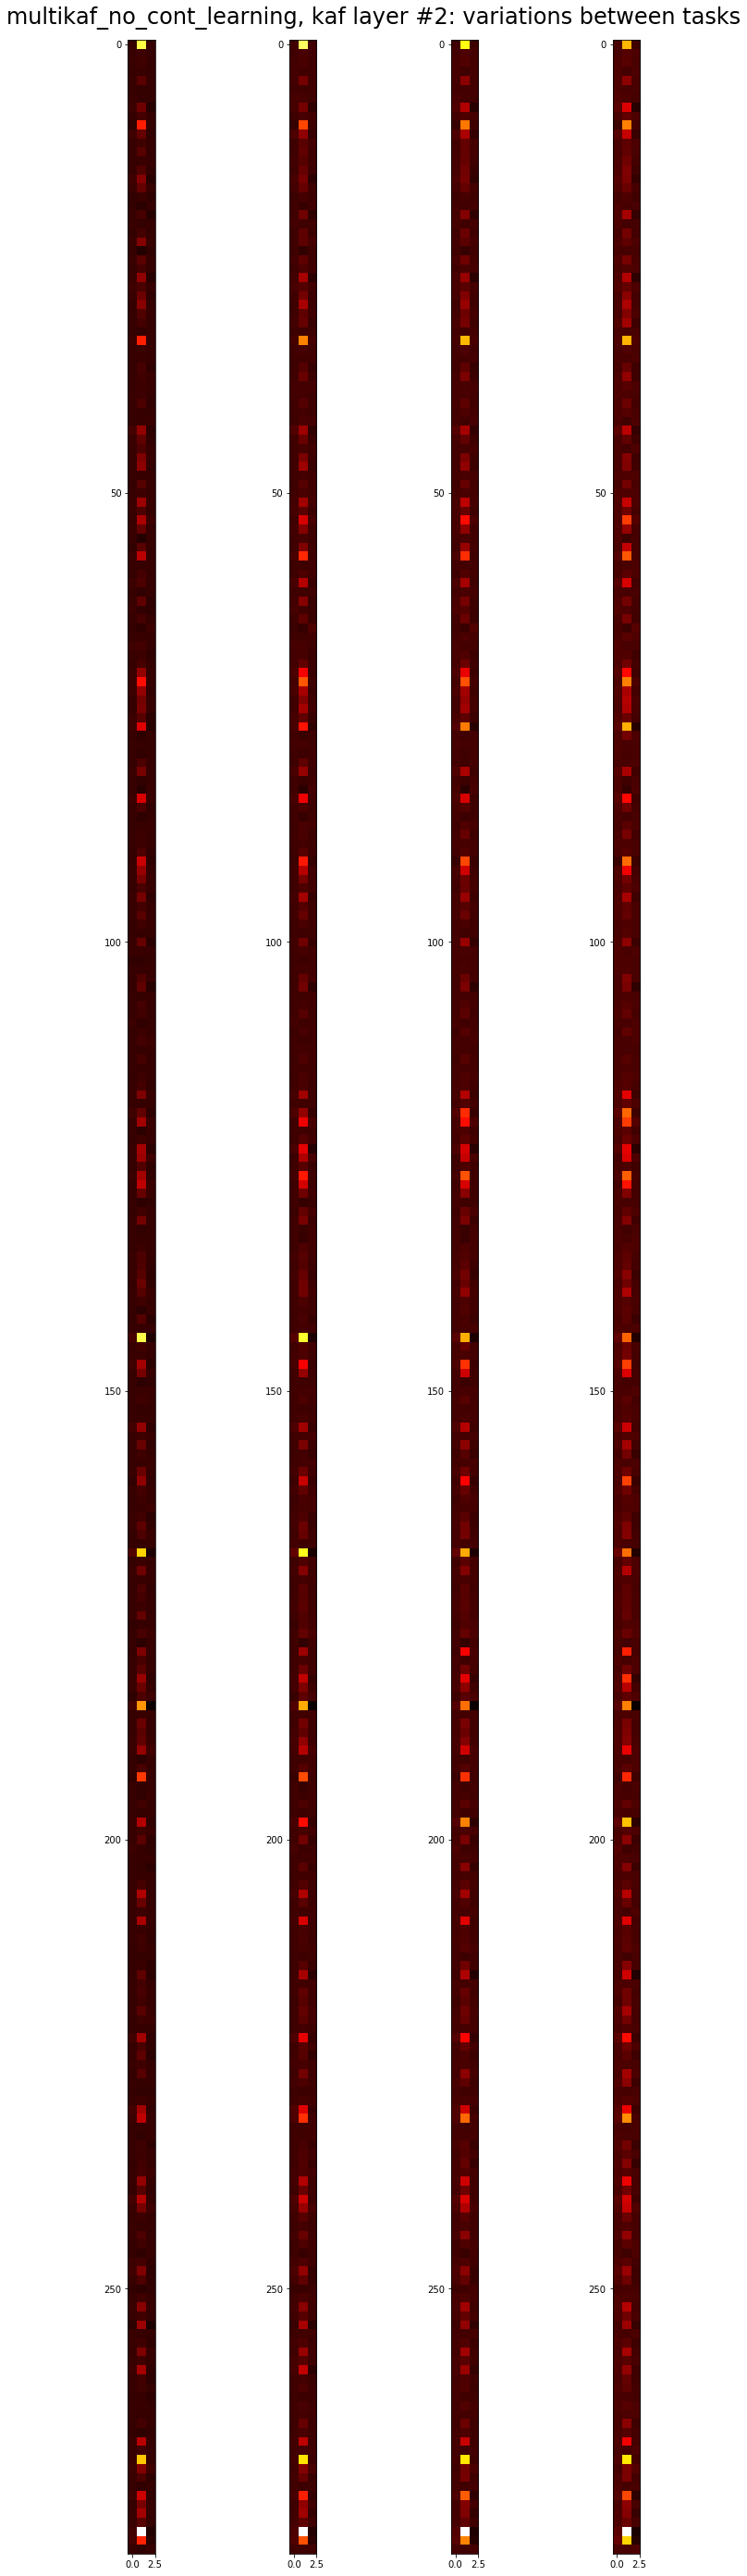

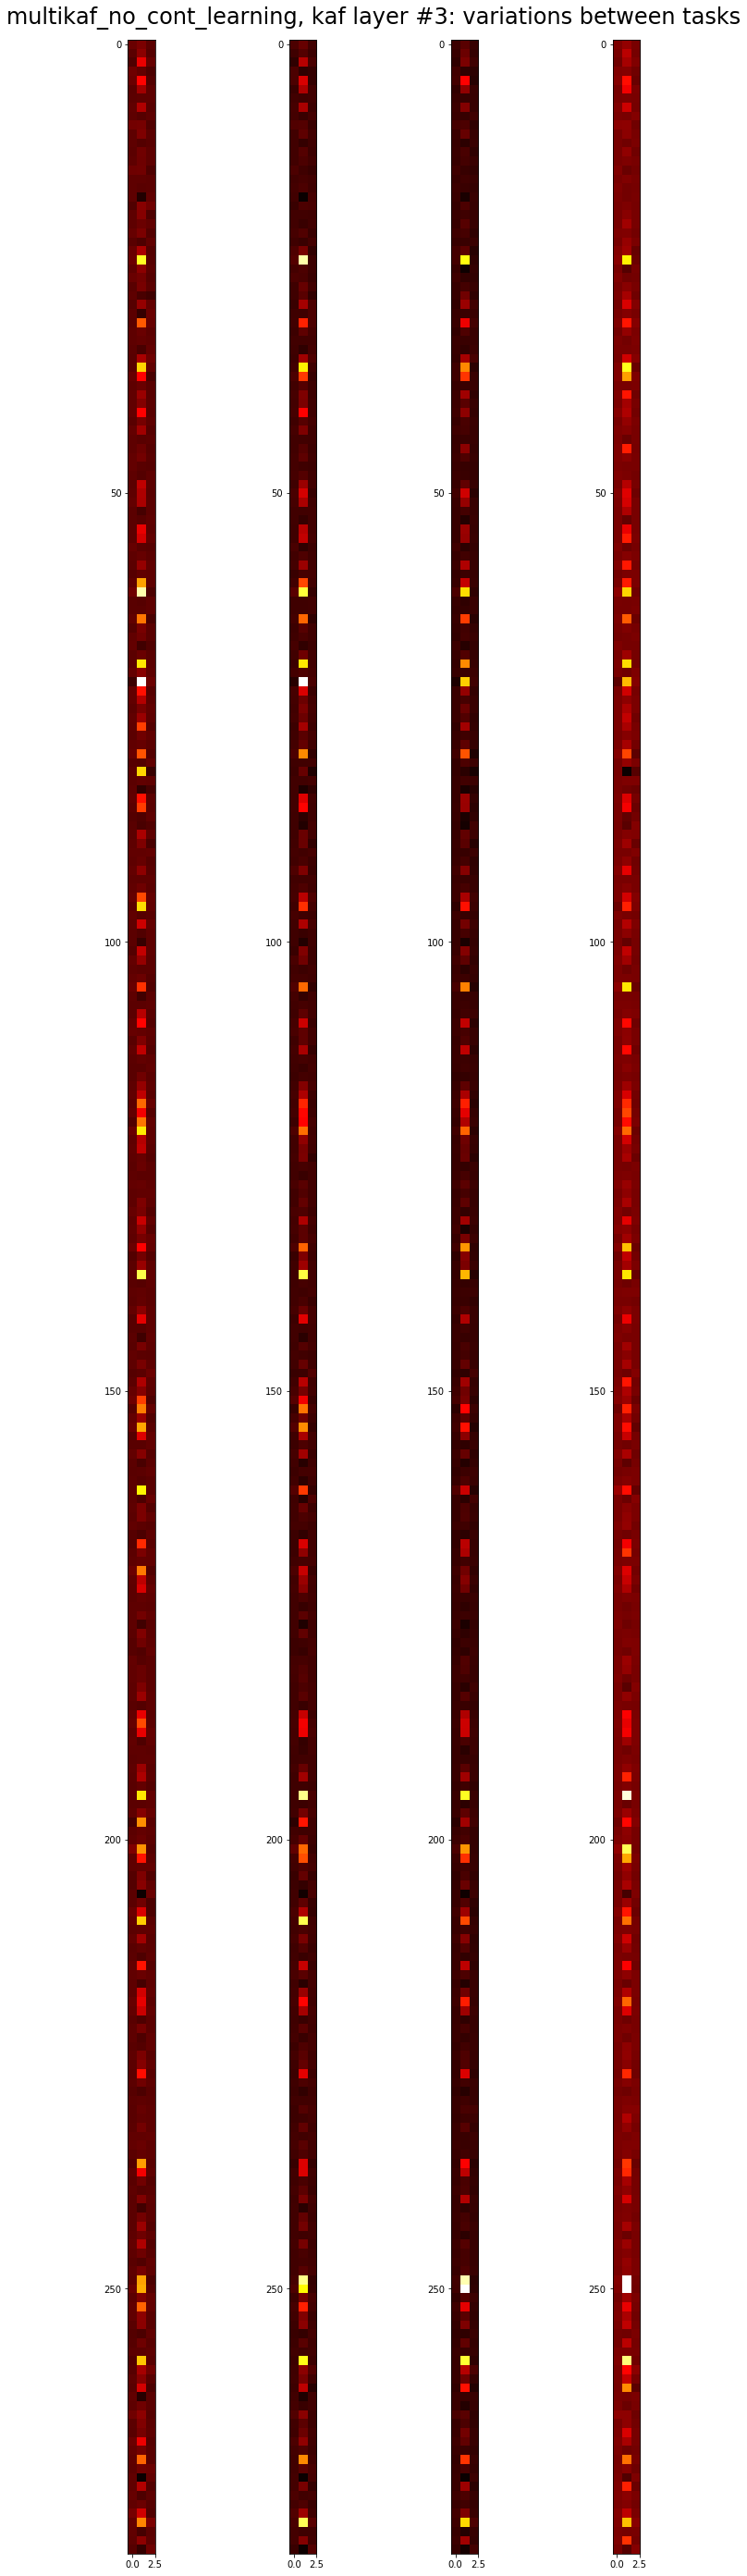

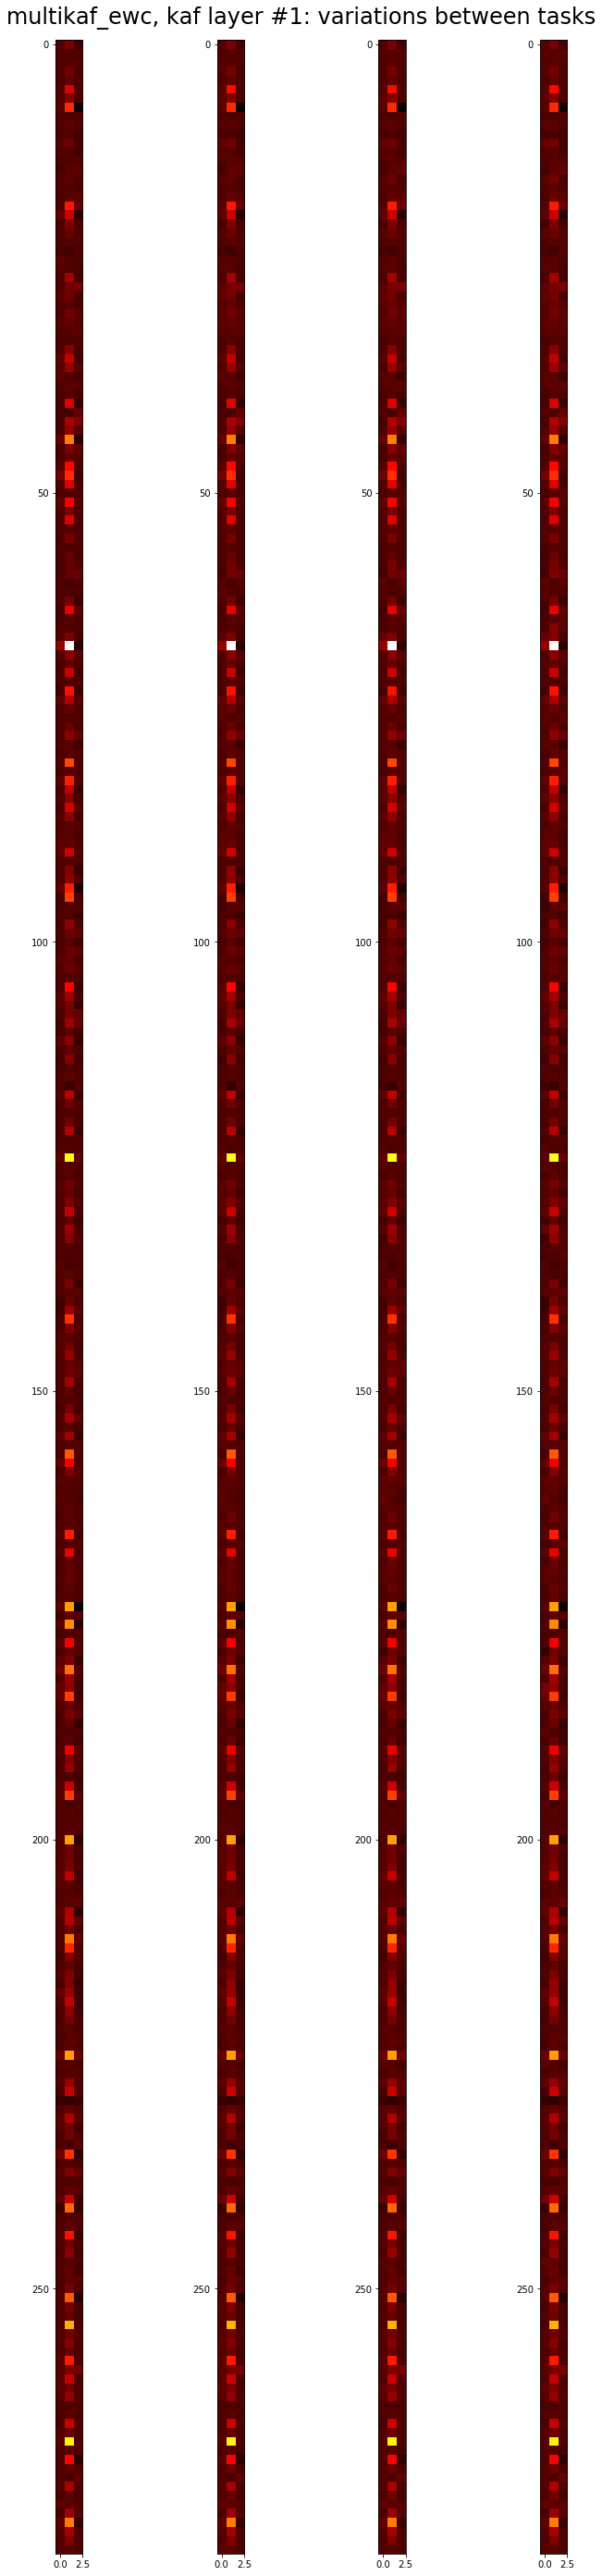

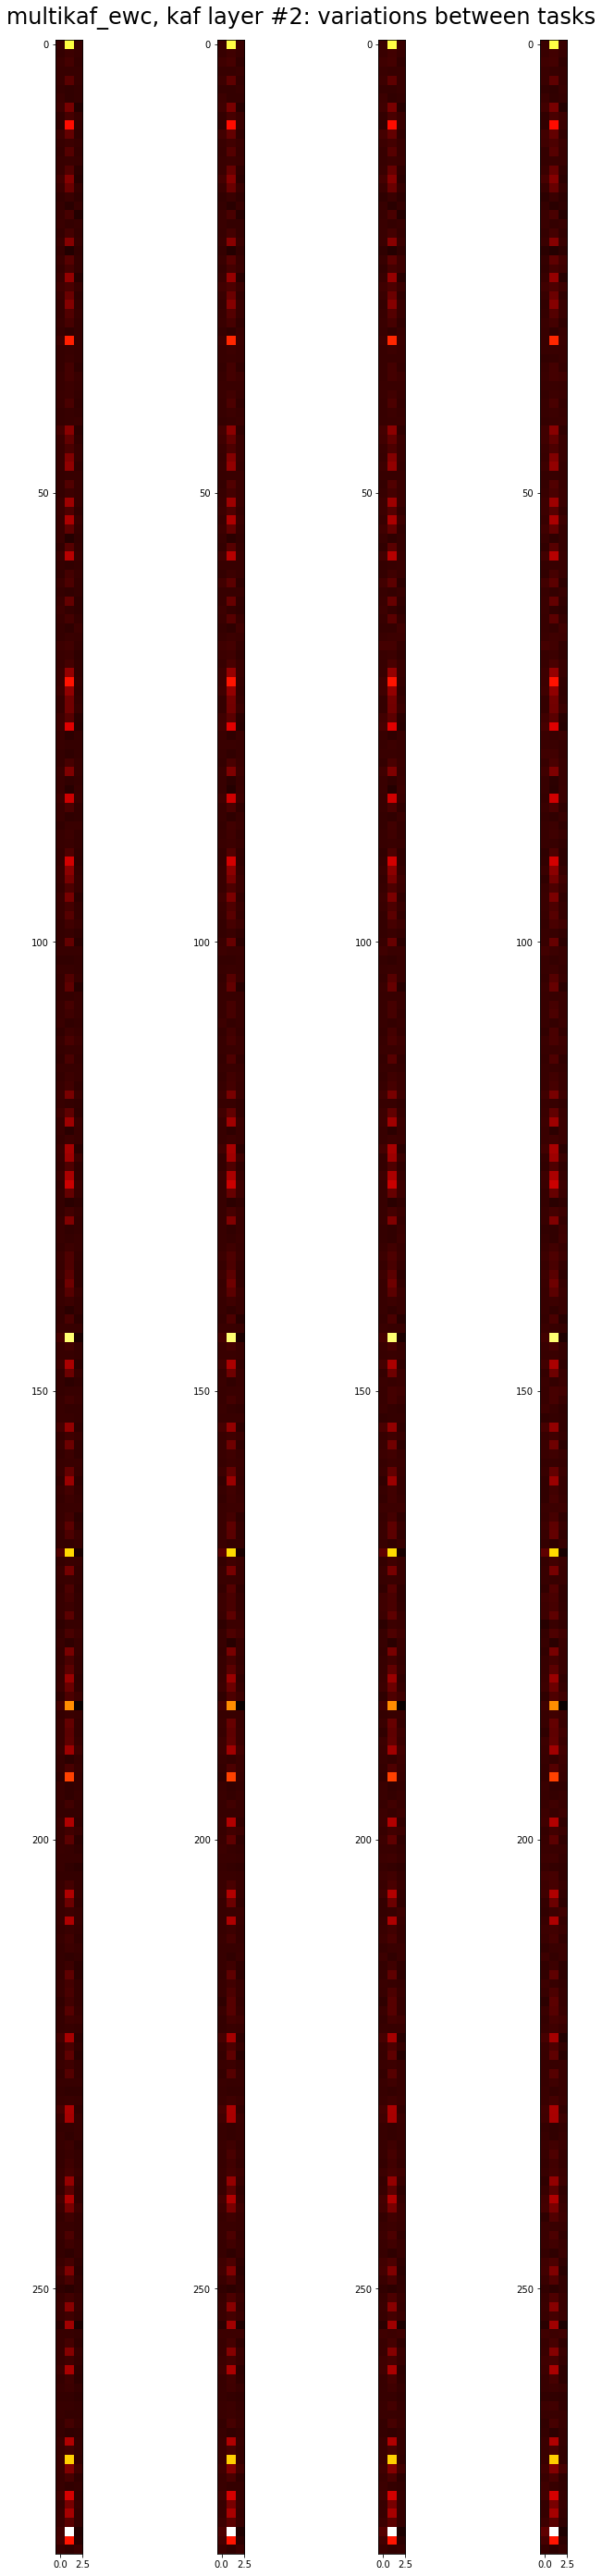

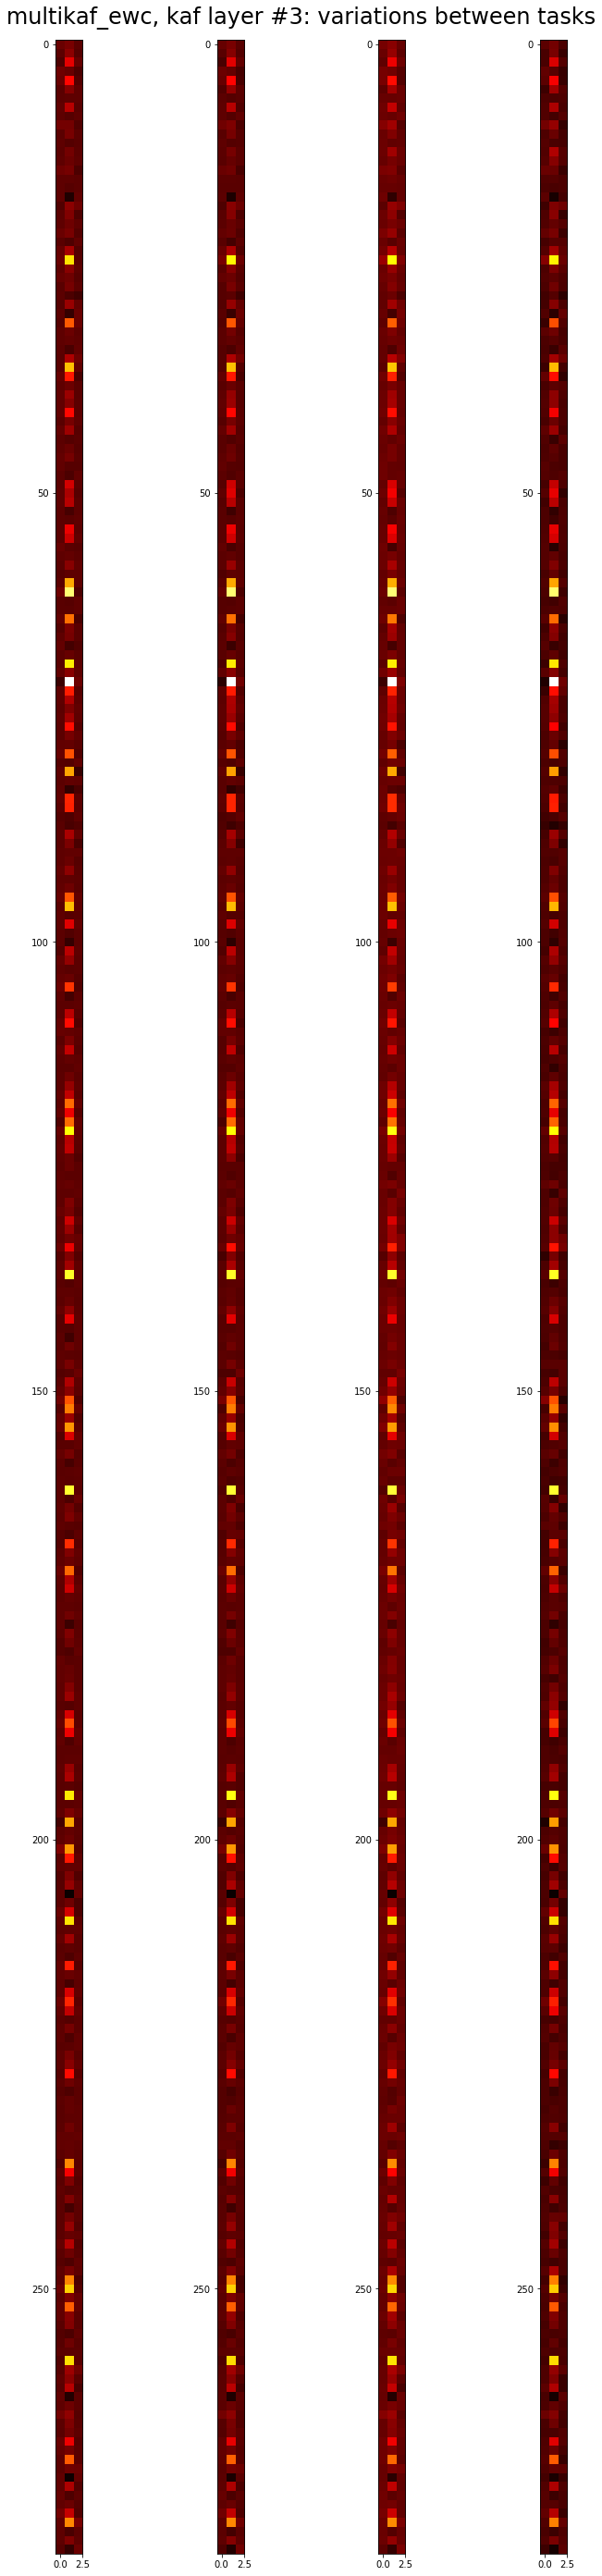

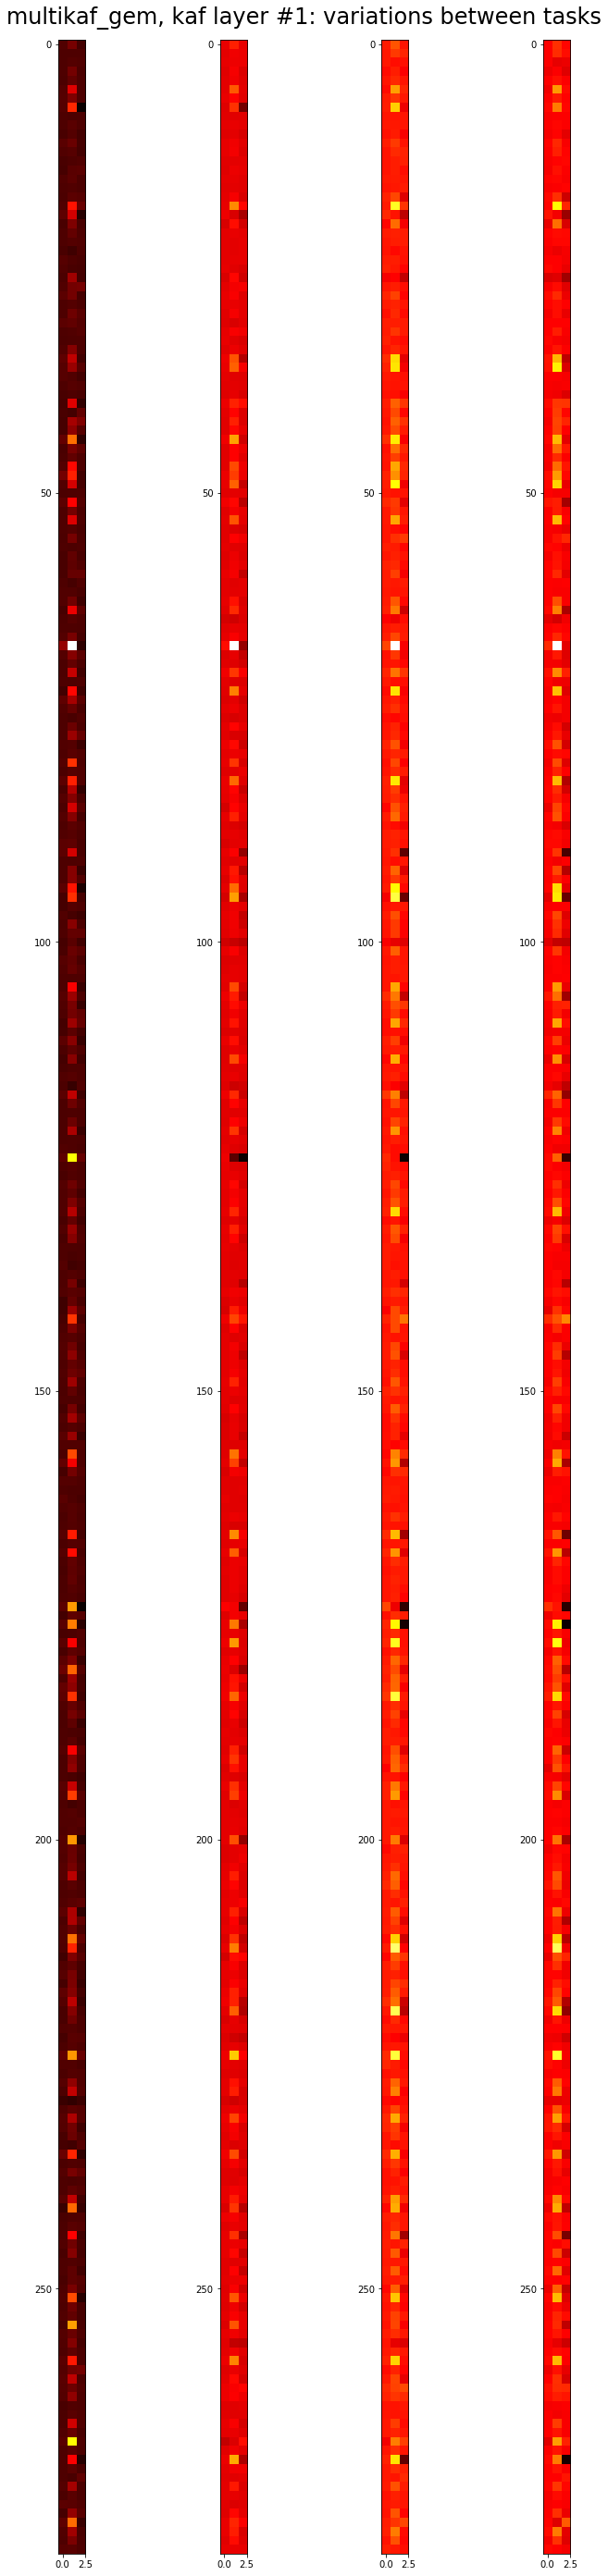

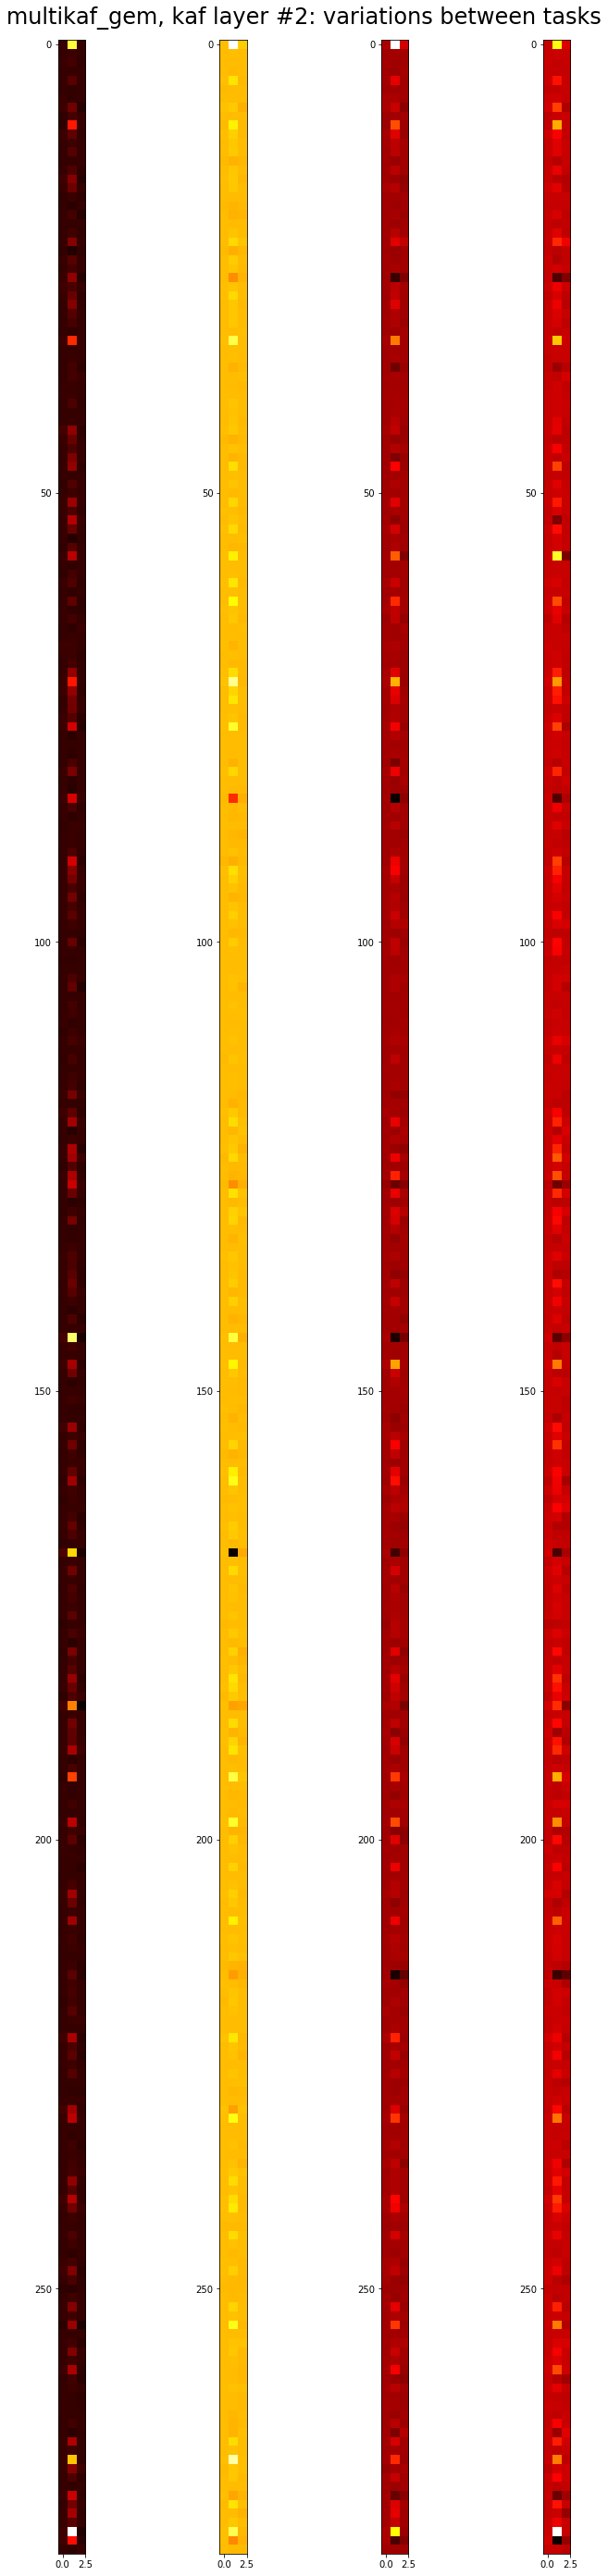

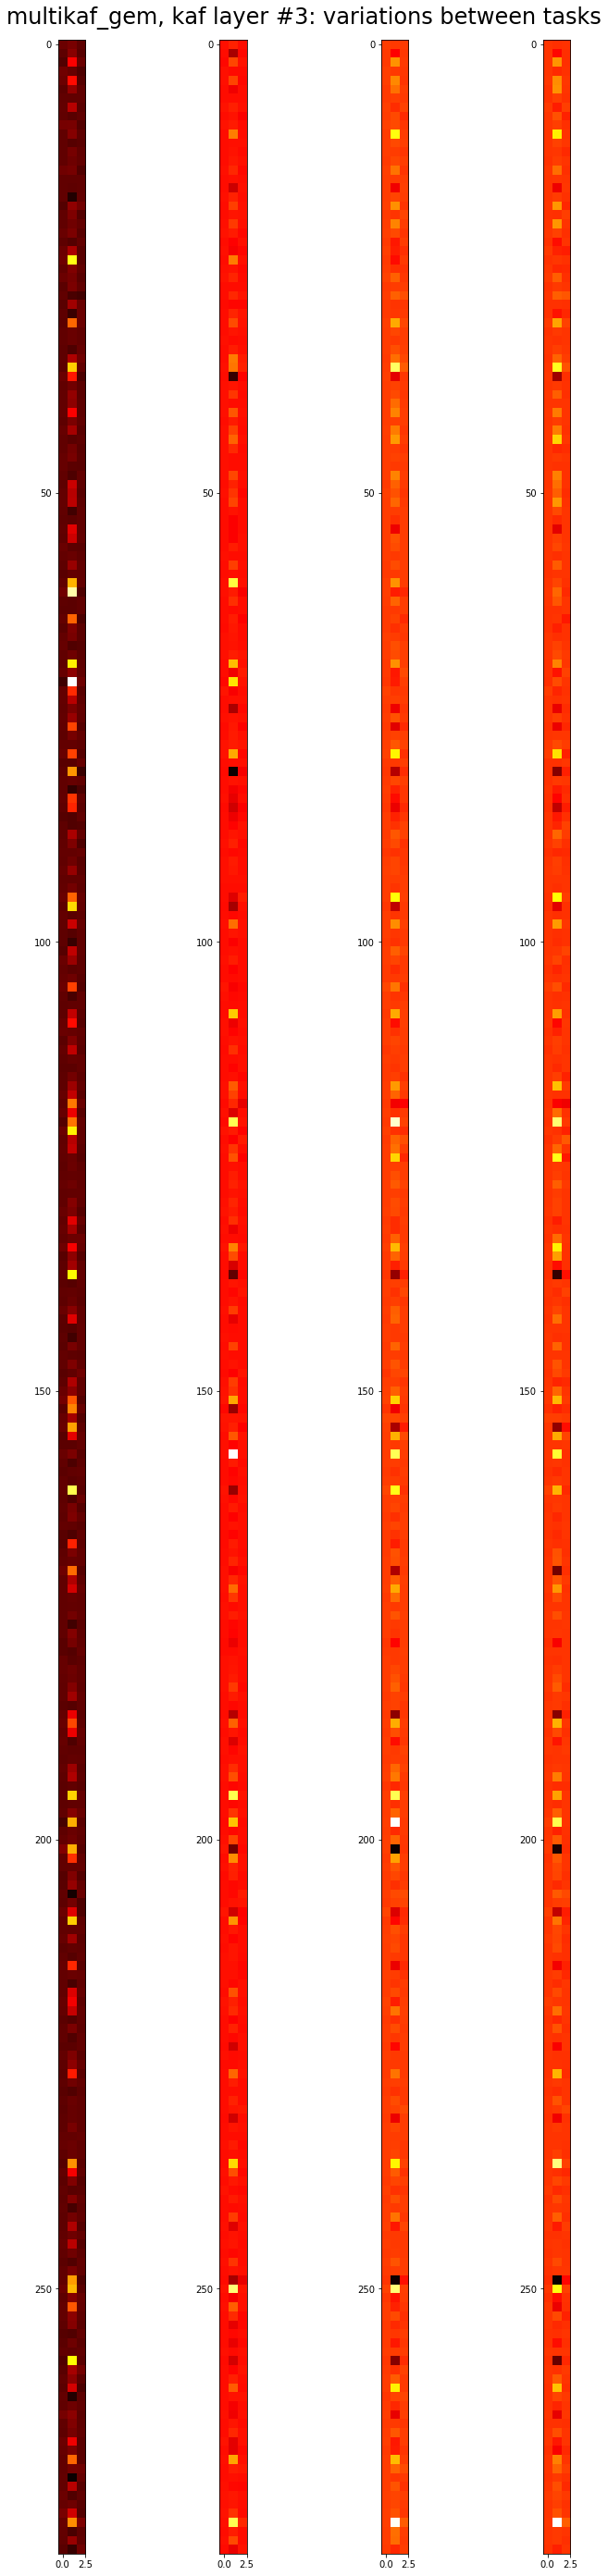

In [62]:
neurons = np.random.randint(low=1, high=int(400*0.7), size=10) 
from scipy.interpolate import make_interp_spline, BSpline

def hook(module, input, output):
    setattr(module, "_value_hook", output)

x = list(range(20))
common_params = {'histtype': 'step'}

# fig = plt.figure(figsize=(22, 22))
# ax = fig.add_subplot(111, projection='3d')

x_labels = []
space = np.linspace(-4.5, 4.5, 100)

for exp_name, _ in experiments_multikaf:
    for l in [1, 2, 3]:
        
        fig = plt.figure(figsize=(12, 50))
        name = 'kaf'+str(l)
        
        
        for i in np.arange(4):
            n = deepcopy(multikaf)
            config = deepcopy(configOnline)
            config.MODEL_NAME = exp_name

            trainer = Trainer(n, deepcopy(dataset), config, save_modality=2)

            r = trainer.load(i)

            model = trainer.model.cpu()

            for _, m in model.named_modules():
                m.register_forward_hook(hook)

            dataset.task = i
            it = dataset.getIterator(1)

            imgs = []
            for _ in range(100):
                imgs.append(torch.Tensor(next(it)[0]))
                
            kaf = getattr(model, name)
            ax = fig.add_subplot(1, 4, i+1)

            ax.imshow(np.squeeze(kaf.mu.detach().numpy(), 0), cmap='hot', interpolation='nearest')
        
        fig.suptitle('{}, kaf layer #{}: variations between tasks'.format(exp_name, l), y=0.89, size=24)
        plt.show()
        